<h1> HUMAN ACTIVITY RECOGNISION USING LSTM AND DIVIDE & CONQUER METHOD

In [0]:
#importing necessary libraries
import pandas as pd
import numpy as np
import talos as ts
import keras 
from keras.regularizers import l2

Using TensorFlow backend.


In [0]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [0]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [0]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [0]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [0]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [0]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [0]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [0]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [0]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [0]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [0]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [0]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [0]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


In [0]:
# Initializing parameters
epochs =30
batch_size = 16
n_hidden = 32

- Defining the Architecture of LSTM

In [0]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [0]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 22s 3ms/step - loss: 1.3008 - accuracy: 0.4645 - val_loss: 1.0891 - val_accuracy: 0.5565
Epoch 2/30
7352/7352 [==============================] - 19s 3ms/step - loss: 0.9056 - accuracy: 0.6171 - val_loss: 0.8277 - val_accuracy: 0.5942
Epoch 3/30
7352/7352 [==============================] - 19s 3ms/step - loss: 0.7434 - accuracy: 0.6549 - val_loss: 0.7569 - val_accuracy: 0.6230
Epoch 4/30
7352/7352 [==============================] - 20s 3ms/step - loss: 0.6725 - accuracy: 0.6800 - val_loss: 0.6941 - val_accuracy: 0.6651
Epoch 5/30
7352/7352 [==============================] - 20s 3ms/step - loss: 0.6236 - accuracy: 0.7116 - val_loss: 0.6568 - val_accuracy: 0.7326
Epoch 6/30
7352/7352 [==============================] - 19s 3ms/step - loss: 0.5866 - accuracy: 0.7333 - val_loss: 0.7696 - val_accu

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 510        0        27        0                   0   
SITTING                  2      381       105        1                   1   
STANDING                 0       86       446        0                   0   
WALKING                  0        0         0      454                  15   
WALKING_DOWNSTAIRS       0        0         0        0                 419   
WALKING_UPSTAIRS         0        7         0        4                  31   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            1  
STANDING                           0  
WALKING                           27  
WALKING_DOWNSTAIRS                 1  
WALKING_UPSTAIRS                 429  


In [0]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 1s 332us/step


In [0]:
score

[0.41655886096877154, 0.8954869508743286]

- With a simple 2 layer architecture we got 90.09% accuracy and a loss of 0.30
- We can further imporve the performace with Hyperparameter tuning

HYPERPARAMETER TUNING THE LSTM MODEL USING TALOS:

In [0]:
# Defining a model for hyperparameter tuning the lstm model https://github.com/autonomio/talos
def model_lstm_1(x_train,y_train,x_val,y_val,params):
    model = Sequential()
    # Configuring the parameters
    model.add(LSTM(params['n_hidden'], input_shape=(timesteps, input_dim)))
    # Adding a dropout layer
    model.add(Dropout(params['Dropout']))
    # Adding a dense output layer with sigmoid activation
    model.add(Dense(n_classes, activation='sigmoid'))
    # Compiling the model
    model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
    # Training the model
    history = model.fit(X_train,
              Y_train,
              batch_size=batch_size,
              validation_data=(X_test, Y_test),
              epochs=epochs)
    return history, model

In [0]:
# hyperparameters to train for increasing accuracy
param = {'n_hidden': [26,28,32,48,64],
         'Dropout': [0.4,0.5,0.6]
         }

In [0]:
tls = ts.Scan(x=X_train,y=Y_train,
              model=model_lstm_1,
              params=param,
              experiment_name='lstm_model1',
              round_limit=10)

  0%|          | 0/10 [00:00<?, ?it/s]

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 20s 3ms/step - loss: 1.4479 - accuracy: 0.3468 - val_loss: 1.4305 - val_accuracy: 0.3264
Epoch 2/30
7352/7352 [==============================] - 20s 3ms/step - loss: 1.1471 - accuracy: 0.5135 - val_loss: 1.3744 - val_accuracy: 0.4092
Epoch 3/30
7352/7352 [==============================] - 20s 3ms/step - loss: 0.8930 - accuracy: 0.6114 - val_loss: 0.8349 - val_accuracy: 0.6121
Epoch 4/30
7352/7352 [==============================] - 20s 3ms/step - loss: 0.7487 - accuracy: 0.6551 - val_loss: 0.7739 - val_accuracy: 0.6159
Epoch 5/30
7352/7352 [==============================] - 20s 3ms/step - loss: 0.6902 - accuracy: 0.6748 - val_loss: 0.7992 - val_accuracy: 0.6227
Epoch 6/30
7352/7352 [==============================] - 19s 3ms/step - loss: 0.6436 - accuracy: 0.6998 - val_loss: 0.7917 - val_accuracy: 0.6963
Epoch 7/30
7352/7352 [==============================] - 20s 3ms/step - loss: 0.608

 10%|█         | 1/10 [09:59<1:29:57, 599.70s/it]

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 20s 3ms/step - loss: 1.3826 - accuracy: 0.4259 - val_loss: 1.2163 - val_accuracy: 0.4978
Epoch 2/30
7352/7352 [==============================] - 20s 3ms/step - loss: 1.1163 - accuracy: 0.5371 - val_loss: 1.1278 - val_accuracy: 0.5382
Epoch 3/30
7352/7352 [==============================] - 19s 3ms/step - loss: 1.0346 - accuracy: 0.5392 - val_loss: 1.1653 - val_accuracy: 0.5042
Epoch 4/30
7352/7352 [==============================] - 19s 3ms/step - loss: 0.8682 - accuracy: 0.6158 - val_loss: 0.8381 - val_accuracy: 0.6339
Epoch 5/30
7352/7352 [==============================] - 19s 3ms/step - loss: 0.7364 - accuracy: 0.6594 - val_loss: 0.7955 - val_accuracy: 0.6600
Epoch 6/30
7352/7352 [==============================] - 19s 3ms/step - loss: 0.6802 - accuracy: 0.7029 - val_loss: 0.7598 - val_accuracy: 0.6732
Epoch 7/30
7352/7352 [==============================] - 19s 3ms/step - loss: 0.600

 20%|██        | 2/10 [19:32<1:18:53, 591.63s/it]

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 20s 3ms/step - loss: 1.2851 - accuracy: 0.4908 - val_loss: 1.0421 - val_accuracy: 0.5562
Epoch 2/30
7352/7352 [==============================] - 19s 3ms/step - loss: 0.9054 - accuracy: 0.6164 - val_loss: 1.0363 - val_accuracy: 0.5724
Epoch 3/30
7352/7352 [==============================] - 19s 3ms/step - loss: 0.8106 - accuracy: 0.6262 - val_loss: 0.7807 - val_accuracy: 0.6200
Epoch 4/30
7352/7352 [==============================] - 19s 3ms/step - loss: 0.7227 - accuracy: 0.6423 - val_loss: 0.7552 - val_accuracy: 0.6111
Epoch 5/30
7352/7352 [==============================] - 19s 3ms/step - loss: 0.6847 - accuracy: 0.6587 - val_loss: 0.7268 - val_accuracy: 0.6152
Epoch 6/30
7352/7352 [==============================] - 19s 3ms/step - loss: 0.6609 - accuracy: 0.6649 - val_loss: 0.6776 - val_accuracy: 0.6149
Epoch 7/30
7352/7352 [==============================] - 19s 3ms/step - loss: 0.608

 30%|███       | 3/10 [29:03<1:08:18, 585.54s/it]

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 26s 4ms/step - loss: 1.2963 - accuracy: 0.4350 - val_loss: 1.1398 - val_accuracy: 0.5039
Epoch 2/30
7352/7352 [==============================] - 26s 4ms/step - loss: 0.8993 - accuracy: 0.5996 - val_loss: 0.8522 - val_accuracy: 0.6485
Epoch 3/30
7352/7352 [==============================] - 26s 4ms/step - loss: 0.7256 - accuracy: 0.6672 - val_loss: 0.8258 - val_accuracy: 0.6216
Epoch 4/30
7352/7352 [==============================] - 26s 4ms/step - loss: 0.6651 - accuracy: 0.7172 - val_loss: 0.6930 - val_accuracy: 0.7296
Epoch 5/30
7352/7352 [==============================] - 26s 4ms/step - loss: 0.6193 - accuracy: 0.7394 - val_loss: 0.8961 - val_accuracy: 0.5925
Epoch 6/30
7352/7352 [==============================] - 26s 4ms/step - loss: 0.6359 - accuracy: 0.7387 - val_loss: 0.6303 - val_accuracy: 0.7499
Epoch 7/30
7352/7352 [==============================] - 26s 4ms/step - loss: 0.495

 40%|████      | 4/10 [42:09<1:04:33, 645.62s/it]

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 27s 4ms/step - loss: 1.2156 - accuracy: 0.4699 - val_loss: 1.1144 - val_accuracy: 0.5063
Epoch 2/30
7352/7352 [==============================] - 26s 4ms/step - loss: 0.8928 - accuracy: 0.6215 - val_loss: 1.0333 - val_accuracy: 0.6233
Epoch 3/30
7352/7352 [==============================] - 26s 4ms/step - loss: 0.6080 - accuracy: 0.7659 - val_loss: 0.7023 - val_accuracy: 0.7509
Epoch 4/30
7352/7352 [==============================] - 26s 4ms/step - loss: 0.4376 - accuracy: 0.8481 - val_loss: 0.6087 - val_accuracy: 0.8100
Epoch 5/30
7352/7352 [==============================] - 26s 4ms/step - loss: 0.3192 - accuracy: 0.9007 - val_loss: 0.3400 - val_accuracy: 0.8843
Epoch 6/30
7352/7352 [==============================] - 27s 4ms/step - loss: 0.2541 - accuracy: 0.9184 - val_loss: 0.3860 - val_accuracy: 0.8728
Epoch 7/30
7352/7352 [==============================] - 26s 4ms/step - loss: 0.228

 50%|█████     | 5/10 [55:20<57:25, 689.05s/it]  

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 27s 4ms/step - loss: 1.2287 - accuracy: 0.4932 - val_loss: 0.9467 - val_accuracy: 0.6135
Epoch 2/30
7352/7352 [==============================] - 26s 4ms/step - loss: 0.8225 - accuracy: 0.6283 - val_loss: 0.8253 - val_accuracy: 0.6345
Epoch 3/30
7352/7352 [==============================] - 27s 4ms/step - loss: 0.7025 - accuracy: 0.6896 - val_loss: 0.7209 - val_accuracy: 0.6495
Epoch 4/30
7352/7352 [==============================] - 26s 4ms/step - loss: 0.5843 - accuracy: 0.7836 - val_loss: 0.7541 - val_accuracy: 0.7458
Epoch 5/30
7352/7352 [==============================] - 26s 4ms/step - loss: 0.4275 - accuracy: 0.8672 - val_loss: 0.5648 - val_accuracy: 0.8300
Epoch 6/30
7352/7352 [==============================] - 26s 4ms/step - loss: 0.3201 - accuracy: 0.9011 - val_loss: 0.6045 - val_accuracy: 0.8378
Epoch 7/30
7352/7352 [==============================] - 26s 4ms/step - loss: 0.273

 60%|██████    | 6/10 [1:08:32<47:59, 719.94s/it]

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 23s 3ms/step - loss: 1.2049 - accuracy: 0.4929 - val_loss: 0.9385 - val_accuracy: 0.6322
Epoch 2/30
7352/7352 [==============================] - 23s 3ms/step - loss: 0.7949 - accuracy: 0.6661 - val_loss: 0.9319 - val_accuracy: 0.6006
Epoch 3/30
7352/7352 [==============================] - 23s 3ms/step - loss: 0.6247 - accuracy: 0.7405 - val_loss: 0.6161 - val_accuracy: 0.7323
Epoch 4/30
7352/7352 [==============================] - 22s 3ms/step - loss: 0.5080 - accuracy: 0.7837 - val_loss: 0.7970 - val_accuracy: 0.6746
Epoch 5/30
7352/7352 [==============================] - 22s 3ms/step - loss: 0.4538 - accuracy: 0.8055 - val_loss: 0.6467 - val_accuracy: 0.7750
Epoch 6/30
7352/7352 [==============================] - 23s 3ms/step - loss: 0.4012 - accuracy: 0.8607 - val_loss: 0.5682 - val_accuracy: 0.8402
Epoch 7/30
7352/7352 [==============================] - 22s 3ms/step - loss: 0.285

 70%|███████   | 7/10 [1:19:44<35:17, 705.76s/it]

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 23s 3ms/step - loss: 1.2435 - accuracy: 0.4789 - val_loss: 1.1839 - val_accuracy: 0.4452
Epoch 2/30
7352/7352 [==============================] - 22s 3ms/step - loss: 0.9257 - accuracy: 0.5854 - val_loss: 0.8277 - val_accuracy: 0.6118
Epoch 3/30
7352/7352 [==============================] - 22s 3ms/step - loss: 0.7383 - accuracy: 0.6472 - val_loss: 0.7362 - val_accuracy: 0.6254
Epoch 4/30
7352/7352 [==============================] - 23s 3ms/step - loss: 0.6330 - accuracy: 0.6904 - val_loss: 0.7190 - val_accuracy: 0.6471
Epoch 5/30
7352/7352 [==============================] - 23s 3ms/step - loss: 0.5343 - accuracy: 0.7986 - val_loss: 0.5692 - val_accuracy: 0.7876
Epoch 6/30
7352/7352 [==============================] - 22s 3ms/step - loss: 0.3822 - accuracy: 0.8764 - val_loss: 0.6934 - val_accuracy: 0.7940
Epoch 7/30
7352/7352 [==============================] - 23s 3ms/step - loss: 0.306

 80%|████████  | 8/10 [1:31:02<23:14, 697.39s/it]

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 19s 3ms/step - loss: 1.3361 - accuracy: 0.4581 - val_loss: 1.2489 - val_accuracy: 0.4842
Epoch 2/30
7352/7352 [==============================] - 19s 3ms/step - loss: 1.1015 - accuracy: 0.5192 - val_loss: 1.0280 - val_accuracy: 0.5942
Epoch 3/30
7352/7352 [==============================] - 19s 3ms/step - loss: 0.9015 - accuracy: 0.6307 - val_loss: 0.8836 - val_accuracy: 0.6318
Epoch 4/30
7352/7352 [==============================] - 19s 3ms/step - loss: 0.7728 - accuracy: 0.6669 - val_loss: 0.7618 - val_accuracy: 0.6481
Epoch 5/30
7352/7352 [==============================] - 20s 3ms/step - loss: 0.7036 - accuracy: 0.6874 - val_loss: 0.7575 - val_accuracy: 0.6692
Epoch 6/30
7352/7352 [==============================] - 19s 3ms/step - loss: 0.6378 - accuracy: 0.7291 - val_loss: 0.6734 - val_accuracy: 0.7289
Epoch 7/30
7352/7352 [==============================] - 19s 3ms/step - loss: 0.636

 90%|█████████ | 9/10 [1:40:38<11:00, 660.87s/it]

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 20s 3ms/step - loss: 1.2644 - accuracy: 0.4808 - val_loss: 1.2881 - val_accuracy: 0.4136
Epoch 2/30
7352/7352 [==============================] - 20s 3ms/step - loss: 0.8803 - accuracy: 0.6412 - val_loss: 0.7958 - val_accuracy: 0.6939
Epoch 3/30
7352/7352 [==============================] - 20s 3ms/step - loss: 0.6552 - accuracy: 0.7399 - val_loss: 0.6496 - val_accuracy: 0.7167
Epoch 4/30
7352/7352 [==============================] - 20s 3ms/step - loss: 0.5202 - accuracy: 0.7810 - val_loss: 0.5352 - val_accuracy: 0.7489
Epoch 5/30
7352/7352 [==============================] - 20s 3ms/step - loss: 0.4836 - accuracy: 0.7924 - val_loss: 0.8535 - val_accuracy: 0.7187
Epoch 6/30
7352/7352 [==============================] - 20s 3ms/step - loss: 0.4180 - accuracy: 0.8413 - val_loss: 0.6190 - val_accuracy: 0.8354
Epoch 7/30
7352/7352 [==============================] - 20s 3ms/step - loss: 0.333

100%|██████████| 10/10 [1:50:35<00:00, 663.50s/it]


In [0]:
# accessing the results data frame
tls.data

,round_epochs,val_loss,val_accuracy,loss,accuracy,Dropout,n_hidden
0,30,0.386972,0.895826,0.208892,0.937976,0.6,32
1,30,0.585735,0.869019,0.215808,0.929135,0.5,28
2,30,0.410754,0.889040,0.165365,0.943009,0.4,26
3,30,0.501327,0.905667,0.150608,0.949129,0.6,64
4,30,0.400501,0.912453,0.131903,0.953074,0.4,64
5,30,1.066754,0.842891,0.150359,0.950082,0.5,64
6,30,0.439808,0.903291,0.135142,0.948721,0.4,48
7,30,0.425577,0.918901,0.131141,0.953618,0.5,48
8,30,0.575761,0.888022,0.178583,0.946273,0.5,26
9,30,0.393714,0.901934,0.145525,0.948721,0.4,32


In [0]:
# accessing summary
tls.details

experiment_name             lstm_model1
random_method          uniform_mersenne
reduction_method                   None
reduction_interval                   50
reduction_window                     20
reduction_threshold                 0.2
reduction_metric                val_acc
complete_time            02/11/20/08:12
x_shape                  (7352, 128, 9)
y_shape                       (7352, 6)
dtype: object

In [0]:
# accessing the saved models
tls.saved_models

['{"class_name": "Sequential", "config": {"name": "sequential_2", "layers": [{"class_name": "LSTM", "config": {"name": "lstm_2", "trainable": true, "batch_input_shape": [null, 128, 9], "dtype": "float32", "return_sequences": false, "return_state": false, "go_backwards": false, "stateful": false, "unroll": false, "units": 32, "activation": "tanh", "recurrent_activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "recurrent_initializer": {"class_name": "Orthogonal", "config": {"gain": 1.0, "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "unit_forget_bias": true, "kernel_regularizer": null, "recurrent_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "recurrent_constraint": null, "bias_constraint": null, "dropout": 0.0, "recurrent_dropout": 0.0, "implementation": 2}}, {"class_name":

In [0]:
# Scan object as input
analyzed_data = ts.Analyze(tls)

In [0]:
# access the dataframe with the results
analyzed_data.high('val_accuracy')

0.9189005494117737

In [0]:
# get the best paramaters
analyzed_data.best_params('val_accuracy', ['accuracy', 'loss', 'val_loss'])

array([[48. ,  0.5, 30. ,  0. ],
       [64. ,  0.4, 30. ,  1. ],
       [64. ,  0.6, 30. ,  2. ],
       [48. ,  0.4, 30. ,  3. ],
       [32. ,  0.4, 30. ,  4. ],
       [32. ,  0.6, 30. ,  5. ],
       [26. ,  0.4, 30. ,  6. ],
       [26. ,  0.5, 30. ,  7. ],
       [28. ,  0.5, 30. ,  8. ],
       [64. ,  0.5, 30. ,  9. ]])

In [0]:
# get correlation for hyperparameters against a metric
analyzed_data.correlate('val_loss', ['accuracy', 'loss', 'val_loss'])

round_epochs         NaN
val_accuracy   -0.869426
Dropout         0.192080
n_hidden        0.345077
Name: val_loss, dtype: float64

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


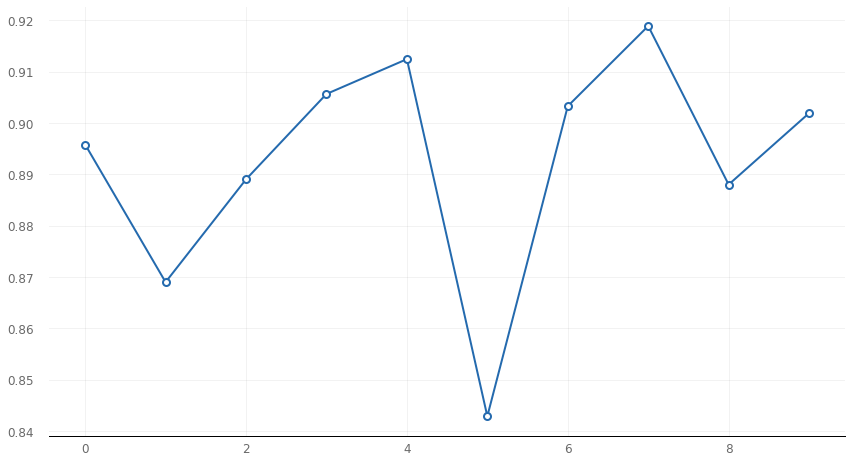

In [0]:
# line plot for all the given parameters
analyzed_data.plot_line('val_accuracy')

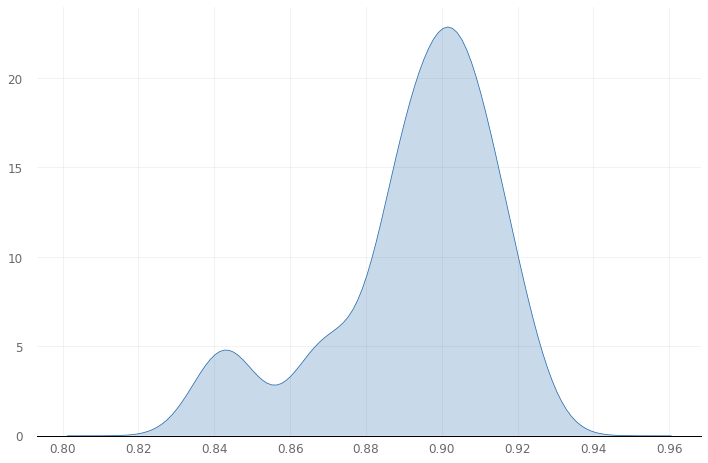

In [0]:
# up to two dimensional kernel density estimator
analyzed_data.plot_kde('val_accuracy')

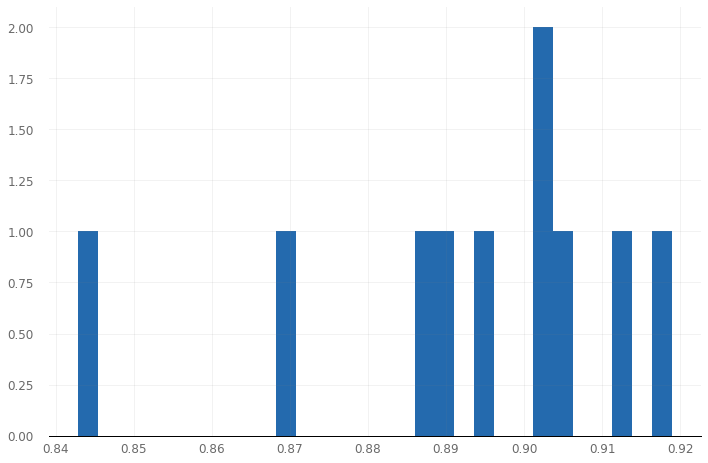

In [0]:
# a simple histogram
analyzed_data.plot_hist('val_accuracy', bins=30)

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

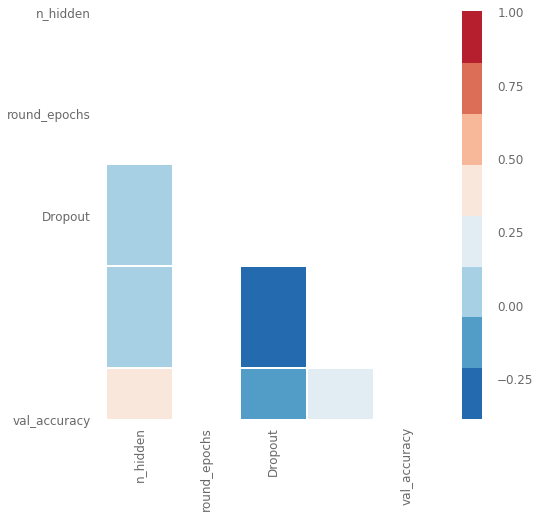

In [0]:
# heatmap correlation
analyzed_data.plot_corr('val_accuracy', ['accuracy', 'loss', 'val_loss'])

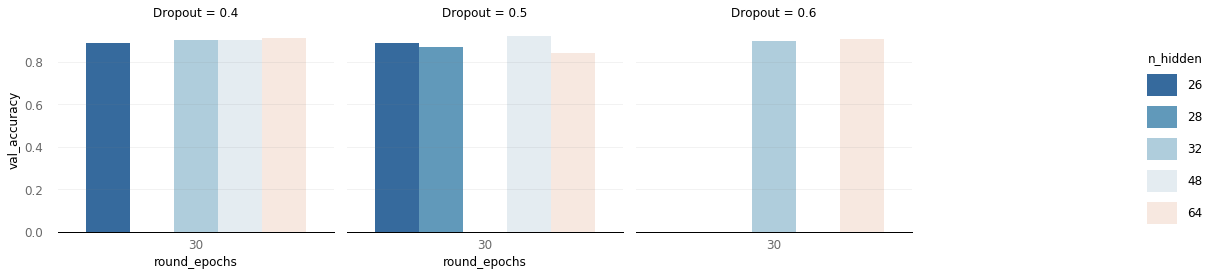

In [0]:
# a four dimensional bar grid
analyzed_data.plot_bars('round_epochs', 'val_accuracy', 'n_hidden', 'Dropout')

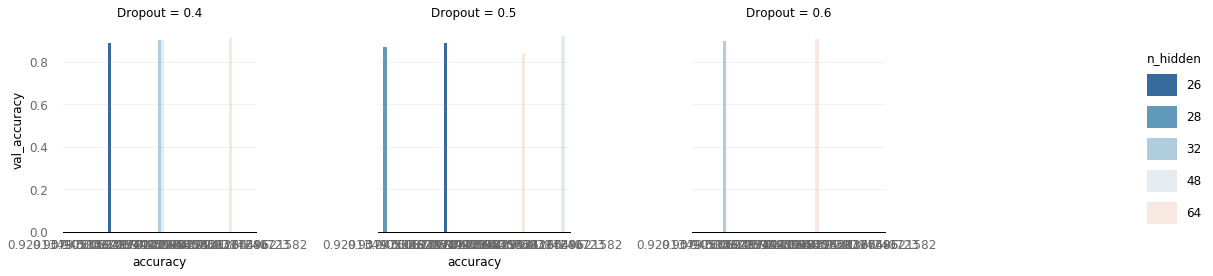

In [0]:
# a four dimensional bar grid
analyzed_data.plot_bars('accuracy', 'val_accuracy', 'n_hidden', 'Dropout')

In [0]:
# Evaluating the best possible outcome withthe hyperparameters
evaluate_data = ts.Evaluate(tls)
evaluate_data.evaluate(X_test, Y_test, folds=6, metric='val_accuracy', task='multi_label')

[0.9005777384116754,
 0.9273553995476083,
 0.9199031835666446,
 0.9111154969359246,
 0.9321189894376553,
 0.9317894615563445]

Thus after 6 folds we can achieve validation accuracy of 93.91%

The Deploy package is a zip file that consist of:

*details of the scan
*model weights
*model json
*results of the experiment
*sample of x data
*sample of y data

# 2-LAYER LSTM

In [0]:
# predicting using the best param 
model = Sequential()
# Configuring the parameters
model.add(LSTM(32,return_sequences=True, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# adding another lstm layer
model.add(LSTM(28,input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.6))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])
# Training the model
history = model.fit(X_train,
              Y_train,
              batch_size=32,
              validation_data=(X_test, Y_test),
              epochs=30)
print(model,history)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 28s 4ms/step - loss: 1.4156 - accuracy: 0.4149 - val_loss: 1.1294 - val_accuracy: 0.5450
Epoch 2/30
7352/7352 [==============================] - 25s 3ms/step - loss: 0.9824 - accuracy: 0.5681 - val_loss: 0.8978 - val_accuracy: 0.5344
Epoch 3/30
7352/7352 [==============================] - 26s 3ms/step - loss: 0.8451 - accuracy: 0.5899 - val_loss: 0.8562 - val_accuracy: 0.6098
Epoch 4/30
7352/7352 [==============================] - 25s 3ms/step - loss: 0.7804 - accuracy: 0.6341 - val_loss: 0.7799 - val_accuracy: 0.6427
Epoch 5/30
7352/7352 [==============================] - 25s 3ms/step - loss: 0.7391 - accuracy: 0.6574 - val_loss: 0.7567 - val_accuracy: 0.6630
Epoch 6/30
7352/7352 [==============================] - 25s 3ms/step - loss: 0.7193 - accuracy: 0.6744 - val_loss: 0.6856 - val_accuracy: 0.6848
Epoch 7/30
7352/7352 [==============================] - 25s 3ms/step - loss: 0.661

* Thus by applying 2 layer lstm we achieved 90% accuracy

In [0]:
model.save('lstm_2.h5')

# Applying Divide and Conquer method from the research paper  https://www.mdpi.com/1424-8220/18/4/1055/pdf 

 * We divide the entire data classess into static and dynamic classess
 * Static classess are standing sitting and laying 
 * Dynamic classess are walking running and jumping

# CLASSIFYING AND DIVIDING STATIC AND DYNAMIC ACTIVITIES

In [0]:
def new1_y(subset):
        """Getting one hot encoded part of the 6 classess
        (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
        """
        filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
        y = _read_csv(filename)[0]
        y[y<=3] = 0
        y[y>3] = 1
        return pd.get_dummies(y).as_matrix()
    
X_train_c1, X_test_c1 = load_signals('train'), load_signals('test')
Y_train_c1, Y_test_c1 = new1_y('train'), new1_y('test')


In [0]:
X_test_c1.shape

(2947, 128, 9)

In [0]:
# scaling the 3-d numpy arrays: https://stackoverflow.com/questions/50125844/how-to-standard-scale-a-3d-matrix
from sklearn.preprocessing import StandardScaler
scalers1 = {}
for i in range(X_train_c1.shape[1]):
    scalers1[i] = StandardScaler()
    X_train_c1[:, i, :] = scalers1[i].fit_transform(X_train_c1[:, i, :]) 

for i in range(X_test_c1.shape[1]):
    X_test_c1[:, i, :] = scalers1[i].transform(X_test_c1[:, i, :]) 

In [0]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM,Flatten,Dropout,Dense
K.clear_session()
np.random.seed(0)
tf.set_random_seed(0)
sess = tf.Session(graph=tf.get_default_graph())
K.set_session(sess)
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='selu',kernel_initializer='he_uniform',input_shape=(128,9)))
model.add(Conv1D(filters=32, kernel_size=3, activation='selu',kernel_initializer='he_uniform'))
model.add(Dropout(0.6))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='selu'))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 126, 32)           896       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 124, 32)           3104      
_________________________________________________________________
dropout_1 (Dropout)          (None, 124, 32)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 62, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1984)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                99250     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                

In [0]:
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(lr=0.01), metrics=['accuracy'])
model.fit(X_train_c1,Y_train_c1, epochs=2, batch_size=32,validation_data=(X_test_c1, Y_test_c1), verbose=1)

Train on 7352 samples, validate on 2947 samples
Epoch 1/2
7352/7352 [==============================] - 5s 650us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0205 - val_accuracy: 0.9990
Epoch 2/2
7352/7352 [==============================] - 4s 546us/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0205 - val_accuracy: 0.9990


In [0]:
print((model.evaluate(X_test_c1,Y_test_c1,verbose=0)))
print(['val_loss','val_acc'])

[0.020487990224001405, 0.9989820122718811]
['val_loss', 'val_acc']


* Thus by using 'selu' and just running two epochs we got val_accuracy 0.999 as test values and val_lost of 0.0205 !

In [0]:
#Saving the above model
model.save('model_c1.h5')

# CLASSIFYING STATIC ACTIVITIES:

In [0]:
def new2_y(subset):
        """
        getting the encoded classess values other than the above classess
        (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
        """
        filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
        y = _read_csv(filename)[0]
        y_con = y>3
        y = y[y_con]
        return pd.get_dummies(y).as_matrix(),y_con

In [0]:
Y_train_c2,train_con = new2_y('train')
Y_test_c2,test_con = new2_y('test')

In [0]:
scalers2 = {}
for i in range(X_train_c1.shape[1]):
    scalers2[i] = StandardScaler()
    X_train_c2[:, i, :] = scalers2[i].fit_transform(X_train_c1[:, i, :]) 

for i in range(X_test_c1.shape[1]):
    X_test_c2[:, i, :] = scalers2[i].transform(X_test_c1[:, i, :]) 

In [0]:
print(X_train_c2.shape,X_test_c2.shape)
print(Y_train_c2.shape,Y_test_c2.shape)

(4067, 128, 9) (1560, 128, 9)
(4067, 3) (1560, 3)


In [0]:
import talos
import wrangle
scalers = {}
for i in range(X_train_c1.shape[1]):
    scalers[i] = StandardScaler()
    X_train_c2[:, i, :] = scalers[i].fit_transform(X_train_c2[:, i, :]) 

for i in range(X_test_c1.shape[1]):
    X_test_c2[:, i, :] = scalers[i].transform(X_test_c2[:, i, :]) 

In [0]:
#Baseline model

from keras.layers import Conv1D ,MaxPooling1D,Flatten
def stat_model(x_train, y_train, x_val, y_val,params):
    tf.set_random_seed(0)
    sess = tf.Session(graph=tf.get_default_graph())
    K.set_session(sess)
    model = Sequential()
    model.add(Conv1D(filters=params['first_filter'], kernel_size=5, activation=params['activation'],kernel_regularizer=l2(0.002),
                     kernel_initializer='he_uniform',input_shape=(128,9)))
    model.add(Conv1D(filters=16, kernel_size=3, activation=params['activation'],kernel_initializer='he_uniform',
                     kernel_regularizer=l2(0.002)))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=3))
    model.add(Flatten())
    model.add(Dense(32, activation=params['activation']))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer=params['optimizer'],
                  metrics=['accuracy'])
    history = model.fit(X_train_c2,Y_train_c2, epochs=params['epochs'], batch_size=64,
                        validation_data=(X_test_c2, Y_test_c2),verbose=1)
    return history,model

In [0]:
from keras.optimizers import Nadam
from keras.optimizers import  Adam ,RMSprop
p = {'first_filter':[16,32],
     'epochs': [10,30,40],
     'optimizer': ['Adam','Rmsprop'],
     'activation':['relu', 'selu']}

In [0]:
%%time
t = ts.Scan(x=X_train_c2,
               y=Y_train_c2,
               model=stat_model,
               params=p,
               experiment_name='static_model')





  0%|          | 0/24 [00:00<?, ?it/s]

Train on 4067 samples, validate on 1560 samples
Epoch 1/10
4067/4067 [==============================] - 3s 640us/step - loss: 0.7657 - accuracy: 0.7578 - val_loss: 0.5008 - val_accuracy: 0.8679
Epoch 2/10
4067/4067 [==============================] - 1s 243us/step - loss: 0.4264 - accuracy: 0.8771 - val_loss: 0.4326 - val_accuracy: 0.8853
Epoch 3/10
4067/4067 [==============================] - 1s 240us/step - loss: 0.3572 - accuracy: 0.9051 - val_loss: 0.4072 - val_accuracy: 0.8949
Epoch 4/10
4067/4067 [==============================] - 1s 249us/step - loss: 0.3282 - accuracy: 0.9149 - val_loss: 0.3810 - val_accuracy: 0.9026
Epoch 5/10
4067/4067 [==============================] - 1s 252us/step - loss: 0.3072 - accuracy: 0.9233 - val_loss: 0.3742 - val_accuracy: 0.9103
Epoch 6/10
4067/4067 [==============================] - 1s 254us/step - loss: 0.2958 - accuracy: 0.9260 - val_loss: 0.3601 - val_accuracy: 0.9083
Epoch 7/10
4067/4067 [==============================] - 1s 253us/step - loss





  4%|▍         | 1/24 [00:18<07:05, 18.50s/it]

Train on 4067 samples, validate on 1560 samples
Epoch 1/10
4067/4067 [==============================] - 1s 283us/step - loss: 0.5747 - accuracy: 0.8289 - val_loss: 0.5262 - val_accuracy: 0.8583
Epoch 2/10
4067/4067 [==============================] - 1s 217us/step - loss: 0.3500 - accuracy: 0.9041 - val_loss: 0.4675 - val_accuracy: 0.8750
Epoch 3/10
4067/4067 [==============================] - 1s 211us/step - loss: 0.3055 - accuracy: 0.9221 - val_loss: 0.4285 - val_accuracy: 0.8795
Epoch 4/10
4067/4067 [==============================] - 1s 213us/step - loss: 0.2864 - accuracy: 0.9228 - val_loss: 0.4409 - val_accuracy: 0.8846
Epoch 5/10
4067/4067 [==============================] - 1s 210us/step - loss: 0.2720 - accuracy: 0.9329 - val_loss: 0.4207 - val_accuracy: 0.8776
Epoch 6/10
4067/4067 [==============================] - 1s 209us/step - loss: 0.2561 - accuracy: 0.9378 - val_loss: 0.3857 - val_accuracy: 0.8897
Epoch 7/10
4067/4067 [==============================] - 1s 212us/step - loss





  8%|▊         | 2/24 [00:28<05:51, 15.96s/it]

Train on 4067 samples, validate on 1560 samples
Epoch 1/10
4067/4067 [==============================] - 1s 351us/step - loss: 0.7727 - accuracy: 0.7971 - val_loss: 0.5363 - val_accuracy: 0.8737
Epoch 2/10
4067/4067 [==============================] - 1s 271us/step - loss: 0.4331 - accuracy: 0.9127 - val_loss: 0.4815 - val_accuracy: 0.8795
Epoch 3/10
4067/4067 [==============================] - 1s 265us/step - loss: 0.3866 - accuracy: 0.9166 - val_loss: 0.4529 - val_accuracy: 0.8917
Epoch 4/10
4067/4067 [==============================] - 1s 268us/step - loss: 0.3539 - accuracy: 0.9307 - val_loss: 0.4259 - val_accuracy: 0.9077
Epoch 5/10
4067/4067 [==============================] - 1s 269us/step - loss: 0.3249 - accuracy: 0.9410 - val_loss: 0.4053 - val_accuracy: 0.9090
Epoch 6/10
4067/4067 [==============================] - 1s 265us/step - loss: 0.3085 - accuracy: 0.9444 - val_loss: 0.3886 - val_accuracy: 0.9173
Epoch 7/10
4067/4067 [==============================] - 1s 264us/step - loss





 12%|█▎        | 3/24 [00:40<05:13, 14.91s/it]

Train on 4067 samples, validate on 1560 samples
Epoch 1/10
4067/4067 [==============================] - 1s 323us/step - loss: 0.5601 - accuracy: 0.8387 - val_loss: 0.4994 - val_accuracy: 0.8712
Epoch 2/10
4067/4067 [==============================] - 1s 259us/step - loss: 0.3869 - accuracy: 0.9090 - val_loss: 0.4503 - val_accuracy: 0.8949
Epoch 3/10
4067/4067 [==============================] - 1s 258us/step - loss: 0.3519 - accuracy: 0.9221 - val_loss: 0.4329 - val_accuracy: 0.8878
Epoch 4/10
4067/4067 [==============================] - 1s 263us/step - loss: 0.3270 - accuracy: 0.9284 - val_loss: 0.4128 - val_accuracy: 0.9141
Epoch 5/10
4067/4067 [==============================] - 1s 268us/step - loss: 0.3046 - accuracy: 0.9314 - val_loss: 0.3707 - val_accuracy: 0.9128
Epoch 6/10
4067/4067 [==============================] - 1s 264us/step - loss: 0.2915 - accuracy: 0.9400 - val_loss: 0.3689 - val_accuracy: 0.9147
Epoch 7/10
4067/4067 [==============================] - 1s 261us/step - loss





 17%|█▋        | 4/24 [00:52<04:40, 14.01s/it]

Train on 4067 samples, validate on 1560 samples
Epoch 1/30
4067/4067 [==============================] - 1s 281us/step - loss: 0.7210 - accuracy: 0.7672 - val_loss: 0.5041 - val_accuracy: 0.8564
Epoch 2/30
4067/4067 [==============================] - 1s 210us/step - loss: 0.3625 - accuracy: 0.9002 - val_loss: 0.4551 - val_accuracy: 0.8801
Epoch 3/30
4067/4067 [==============================] - 1s 209us/step - loss: 0.3295 - accuracy: 0.9147 - val_loss: 0.4493 - val_accuracy: 0.8667
Epoch 4/30
4067/4067 [==============================] - 1s 213us/step - loss: 0.3055 - accuracy: 0.9191 - val_loss: 0.4366 - val_accuracy: 0.8712
Epoch 5/30
4067/4067 [==============================] - 1s 214us/step - loss: 0.2846 - accuracy: 0.9309 - val_loss: 0.4568 - val_accuracy: 0.8622
Epoch 6/30
4067/4067 [==============================] - 1s 213us/step - loss: 0.2767 - accuracy: 0.9324 - val_loss: 0.4156 - val_accuracy: 0.8808
Epoch 7/30
4067/4067 [==============================] - 1s 212us/step - loss





 21%|██        | 5/24 [01:20<05:41, 17.99s/it]

Train on 4067 samples, validate on 1560 samples
Epoch 1/30
4067/4067 [==============================] - 1s 279us/step - loss: 0.6336 - accuracy: 0.8026 - val_loss: 0.4743 - val_accuracy: 0.8641
Epoch 2/30
4067/4067 [==============================] - 1s 214us/step - loss: 0.3515 - accuracy: 0.9085 - val_loss: 0.4176 - val_accuracy: 0.8929
Epoch 3/30
4067/4067 [==============================] - 1s 213us/step - loss: 0.3162 - accuracy: 0.9189 - val_loss: 0.4337 - val_accuracy: 0.8769
Epoch 4/30
4067/4067 [==============================] - 1s 208us/step - loss: 0.2962 - accuracy: 0.9272 - val_loss: 0.4120 - val_accuracy: 0.8885
Epoch 5/30
4067/4067 [==============================] - 1s 211us/step - loss: 0.2784 - accuracy: 0.9282 - val_loss: 0.3923 - val_accuracy: 0.8994
Epoch 6/30
4067/4067 [==============================] - 1s 211us/step - loss: 0.2617 - accuracy: 0.9343 - val_loss: 0.3790 - val_accuracy: 0.8968
Epoch 7/30
4067/4067 [==============================] - 1s 212us/step - loss





 25%|██▌       | 6/24 [01:47<06:16, 20.89s/it]

Train on 4067 samples, validate on 1560 samples
Epoch 1/30
4067/4067 [==============================] - 1s 339us/step - loss: 0.6279 - accuracy: 0.8308 - val_loss: 0.5263 - val_accuracy: 0.8821
Epoch 2/30
4067/4067 [==============================] - 1s 274us/step - loss: 0.4025 - accuracy: 0.9127 - val_loss: 0.4708 - val_accuracy: 0.8859
Epoch 3/30
4067/4067 [==============================] - 1s 271us/step - loss: 0.3654 - accuracy: 0.9223 - val_loss: 0.4487 - val_accuracy: 0.8981
Epoch 4/30
4067/4067 [==============================] - 1s 266us/step - loss: 0.3483 - accuracy: 0.9329 - val_loss: 0.4497 - val_accuracy: 0.9058
Epoch 5/30
4067/4067 [==============================] - 1s 265us/step - loss: 0.3368 - accuracy: 0.9339 - val_loss: 0.4312 - val_accuracy: 0.9019
Epoch 6/30
4067/4067 [==============================] - 1s 265us/step - loss: 0.3229 - accuracy: 0.9390 - val_loss: 0.4118 - val_accuracy: 0.9109
Epoch 7/30
4067/4067 [==============================] - 1s 264us/step - loss





 29%|██▉       | 7/24 [02:22<07:03, 24.90s/it]

Train on 4067 samples, validate on 1560 samples
Epoch 1/30
4067/4067 [==============================] - 1s 320us/step - loss: 0.6634 - accuracy: 0.8198 - val_loss: 0.5335 - val_accuracy: 0.8615
Epoch 2/30
4067/4067 [==============================] - 1s 264us/step - loss: 0.4228 - accuracy: 0.9016 - val_loss: 0.4803 - val_accuracy: 0.8705
Epoch 3/30
4067/4067 [==============================] - 1s 263us/step - loss: 0.3750 - accuracy: 0.9221 - val_loss: 0.4639 - val_accuracy: 0.8724
Epoch 4/30
4067/4067 [==============================] - 1s 265us/step - loss: 0.3455 - accuracy: 0.9289 - val_loss: 0.4290 - val_accuracy: 0.8936
Epoch 5/30
4067/4067 [==============================] - 1s 261us/step - loss: 0.3251 - accuracy: 0.9346 - val_loss: 0.4160 - val_accuracy: 0.8917
Epoch 6/30
4067/4067 [==============================] - 1s 261us/step - loss: 0.3088 - accuracy: 0.9385 - val_loss: 0.4021 - val_accuracy: 0.9096
Epoch 7/30
4067/4067 [==============================] - 1s 266us/step - loss





 33%|███▎      | 8/24 [02:55<07:18, 27.44s/it]

Train on 4067 samples, validate on 1560 samples
Epoch 1/40
4067/4067 [==============================] - 1s 295us/step - loss: 0.5641 - accuracy: 0.8299 - val_loss: 0.4951 - val_accuracy: 0.8635
Epoch 2/40
4067/4067 [==============================] - 1s 218us/step - loss: 0.3431 - accuracy: 0.9090 - val_loss: 0.4298 - val_accuracy: 0.8712
Epoch 3/40
4067/4067 [==============================] - 1s 217us/step - loss: 0.3065 - accuracy: 0.9218 - val_loss: 0.4136 - val_accuracy: 0.8724
Epoch 4/40
4067/4067 [==============================] - 1s 216us/step - loss: 0.2889 - accuracy: 0.9294 - val_loss: 0.3811 - val_accuracy: 0.8936
Epoch 5/40
4067/4067 [==============================] - 1s 218us/step - loss: 0.2757 - accuracy: 0.9358 - val_loss: 0.3750 - val_accuracy: 0.8994
Epoch 6/40
4067/4067 [==============================] - 1s 213us/step - loss: 0.2632 - accuracy: 0.9395 - val_loss: 0.3477 - val_accuracy: 0.9032
Epoch 7/40
4067/4067 [==============================] - 1s 220us/step - loss





 38%|███▊      | 9/24 [03:31<07:31, 30.09s/it]

Train on 4067 samples, validate on 1560 samples
Epoch 1/40
4067/4067 [==============================] - 1s 264us/step - loss: 0.6038 - accuracy: 0.8166 - val_loss: 0.5580 - val_accuracy: 0.8192
Epoch 2/40
4067/4067 [==============================] - 1s 206us/step - loss: 0.3771 - accuracy: 0.8918 - val_loss: 0.4906 - val_accuracy: 0.8750
Epoch 3/40
4067/4067 [==============================] - 1s 206us/step - loss: 0.3287 - accuracy: 0.9088 - val_loss: 0.4950 - val_accuracy: 0.8692
Epoch 4/40
4067/4067 [==============================] - 1s 211us/step - loss: 0.3170 - accuracy: 0.9071 - val_loss: 0.4675 - val_accuracy: 0.8904
Epoch 5/40
4067/4067 [==============================] - 1s 210us/step - loss: 0.2901 - accuracy: 0.9194 - val_loss: 0.4891 - val_accuracy: 0.8776
Epoch 6/40
4067/4067 [==============================] - 1s 208us/step - loss: 0.2832 - accuracy: 0.9216 - val_loss: 0.4619 - val_accuracy: 0.8994
Epoch 7/40
4067/4067 [==============================] - 1s 204us/step - loss





 42%|████▏     | 10/24 [04:06<07:22, 31.63s/it]

Train on 4067 samples, validate on 1560 samples
Epoch 1/40
4067/4067 [==============================] - 1s 340us/step - loss: 0.7774 - accuracy: 0.7755 - val_loss: 0.5492 - val_accuracy: 0.8654
Epoch 2/40
4067/4067 [==============================] - 1s 265us/step - loss: 0.4208 - accuracy: 0.9024 - val_loss: 0.5015 - val_accuracy: 0.8699
Epoch 3/40
4067/4067 [==============================] - 1s 262us/step - loss: 0.3921 - accuracy: 0.9159 - val_loss: 0.4866 - val_accuracy: 0.8756
Epoch 4/40
4067/4067 [==============================] - 1s 264us/step - loss: 0.3684 - accuracy: 0.9257 - val_loss: 0.4774 - val_accuracy: 0.8782
Epoch 5/40
4067/4067 [==============================] - 1s 265us/step - loss: 0.3487 - accuracy: 0.9243 - val_loss: 0.4411 - val_accuracy: 0.8846
Epoch 6/40
4067/4067 [==============================] - 1s 266us/step - loss: 0.3292 - accuracy: 0.9348 - val_loss: 0.4293 - val_accuracy: 0.8878
Epoch 7/40
4067/4067 [==============================] - 1s 264us/step - loss





 46%|████▌     | 11/24 [04:51<07:42, 35.57s/it]

Train on 4067 samples, validate on 1560 samples
Epoch 1/40
4067/4067 [==============================] - 1s 322us/step - loss: 0.6467 - accuracy: 0.8210 - val_loss: 0.4895 - val_accuracy: 0.8750
Epoch 2/40
4067/4067 [==============================] - 1s 258us/step - loss: 0.4119 - accuracy: 0.9039 - val_loss: 0.4303 - val_accuracy: 0.8853
Epoch 3/40
4067/4067 [==============================] - 1s 256us/step - loss: 0.3680 - accuracy: 0.9184 - val_loss: 0.3979 - val_accuracy: 0.9090
Epoch 4/40
4067/4067 [==============================] - 1s 262us/step - loss: 0.3458 - accuracy: 0.9238 - val_loss: 0.3833 - val_accuracy: 0.9071
Epoch 5/40
4067/4067 [==============================] - 1s 265us/step - loss: 0.3107 - accuracy: 0.9358 - val_loss: 0.3788 - val_accuracy: 0.9032
Epoch 6/40
4067/4067 [==============================] - 1s 260us/step - loss: 0.2996 - accuracy: 0.9410 - val_loss: 0.3454 - val_accuracy: 0.9179
Epoch 7/40
4067/4067 [==============================] - 1s 261us/step - loss





 50%|█████     | 12/24 [05:35<07:35, 37.98s/it]

Train on 4067 samples, validate on 1560 samples
Epoch 1/10
4067/4067 [==============================] - 1s 333us/step - loss: 0.6581 - accuracy: 0.8333 - val_loss: 0.5019 - val_accuracy: 0.8673
Epoch 2/10
4067/4067 [==============================] - 1s 262us/step - loss: 0.3970 - accuracy: 0.8965 - val_loss: 0.4784 - val_accuracy: 0.8801
Epoch 3/10
4067/4067 [==============================] - 1s 267us/step - loss: 0.3445 - accuracy: 0.9132 - val_loss: 0.4567 - val_accuracy: 0.8846
Epoch 4/10
4067/4067 [==============================] - 1s 265us/step - loss: 0.3190 - accuracy: 0.9169 - val_loss: 0.4471 - val_accuracy: 0.8923
Epoch 5/10
4067/4067 [==============================] - 1s 265us/step - loss: 0.3158 - accuracy: 0.9218 - val_loss: 0.4422 - val_accuracy: 0.8878
Epoch 6/10
4067/4067 [==============================] - 1s 265us/step - loss: 0.2992 - accuracy: 0.9294 - val_loss: 0.4470 - val_accuracy: 0.8917
Epoch 7/10
4067/4067 [==============================] - 1s 265us/step - loss





 54%|█████▍    | 13/24 [05:47<05:33, 30.31s/it]

Train on 4067 samples, validate on 1560 samples
Epoch 1/10
4067/4067 [==============================] - 1s 335us/step - loss: 0.7184 - accuracy: 0.8163 - val_loss: 0.4978 - val_accuracy: 0.8744
Epoch 2/10
4067/4067 [==============================] - 1s 264us/step - loss: 0.4083 - accuracy: 0.8891 - val_loss: 0.4692 - val_accuracy: 0.8846
Epoch 3/10
4067/4067 [==============================] - 1s 266us/step - loss: 0.3313 - accuracy: 0.9134 - val_loss: 0.4689 - val_accuracy: 0.8878
Epoch 4/10
4067/4067 [==============================] - 1s 262us/step - loss: 0.2965 - accuracy: 0.9225 - val_loss: 0.5574 - val_accuracy: 0.8942
Epoch 5/10
4067/4067 [==============================] - 1s 262us/step - loss: 0.2792 - accuracy: 0.9312 - val_loss: 0.5408 - val_accuracy: 0.8705
Epoch 6/10
4067/4067 [==============================] - 1s 260us/step - loss: 0.2610 - accuracy: 0.9390 - val_loss: 0.6049 - val_accuracy: 0.8891
Epoch 7/10
4067/4067 [==============================] - 1s 265us/step - loss





 58%|█████▊    | 14/24 [05:59<04:08, 24.86s/it]

Train on 4067 samples, validate on 1560 samples
Epoch 1/10
4067/4067 [==============================] - 2s 414us/step - loss: 0.8185 - accuracy: 0.7989 - val_loss: 0.6141 - val_accuracy: 0.8686
Epoch 2/10
4067/4067 [==============================] - 1s 350us/step - loss: 0.4005 - accuracy: 0.9068 - val_loss: 0.5572 - val_accuracy: 0.8865
Epoch 3/10
4067/4067 [==============================] - 1s 348us/step - loss: 0.3869 - accuracy: 0.9125 - val_loss: 0.5397 - val_accuracy: 0.8904
Epoch 4/10
4067/4067 [==============================] - 1s 349us/step - loss: 0.3677 - accuracy: 0.9164 - val_loss: 0.5558 - val_accuracy: 0.8923
Epoch 5/10
4067/4067 [==============================] - 1s 351us/step - loss: 0.3425 - accuracy: 0.9250 - val_loss: 0.6141 - val_accuracy: 0.8897
Epoch 6/10
4067/4067 [==============================] - 1s 349us/step - loss: 0.3256 - accuracy: 0.9366 - val_loss: 0.6001 - val_accuracy: 0.8910
Epoch 7/10
4067/4067 [==============================] - 1s 349us/step - loss





 62%|██████▎   | 15/24 [06:15<03:19, 22.13s/it]

Train on 4067 samples, validate on 1560 samples
Epoch 1/10
4067/4067 [==============================] - 2s 411us/step - loss: 0.7081 - accuracy: 0.8296 - val_loss: 0.6798 - val_accuracy: 0.8436
Epoch 2/10
4067/4067 [==============================] - 1s 342us/step - loss: 0.4295 - accuracy: 0.9012 - val_loss: 0.6618 - val_accuracy: 0.8615
Epoch 3/10
4067/4067 [==============================] - 1s 343us/step - loss: 0.3906 - accuracy: 0.9115 - val_loss: 0.6355 - val_accuracy: 0.8795
Epoch 4/10
4067/4067 [==============================] - 1s 343us/step - loss: 0.3516 - accuracy: 0.9243 - val_loss: 0.6505 - val_accuracy: 0.8936
Epoch 5/10
4067/4067 [==============================] - 1s 341us/step - loss: 0.3401 - accuracy: 0.9257 - val_loss: 0.6417 - val_accuracy: 0.8846
Epoch 6/10
4067/4067 [==============================] - 1s 335us/step - loss: 0.3166 - accuracy: 0.9348 - val_loss: 0.6795 - val_accuracy: 0.9083
Epoch 7/10
4067/4067 [==============================] - 1s 344us/step - loss





 67%|██████▋   | 16/24 [06:31<02:40, 20.10s/it]

Train on 4067 samples, validate on 1560 samples
Epoch 1/30
4067/4067 [==============================] - 1s 336us/step - loss: 0.6433 - accuracy: 0.8171 - val_loss: 0.5375 - val_accuracy: 0.8564
Epoch 2/30
4067/4067 [==============================] - 1s 264us/step - loss: 0.3630 - accuracy: 0.8992 - val_loss: 0.5322 - val_accuracy: 0.8654
Epoch 3/30
4067/4067 [==============================] - 1s 267us/step - loss: 0.3144 - accuracy: 0.9127 - val_loss: 0.4874 - val_accuracy: 0.8853
Epoch 4/30
4067/4067 [==============================] - 1s 268us/step - loss: 0.3060 - accuracy: 0.9171 - val_loss: 0.4750 - val_accuracy: 0.8878
Epoch 5/30
4067/4067 [==============================] - 1s 268us/step - loss: 0.3036 - accuracy: 0.9230 - val_loss: 0.4205 - val_accuracy: 0.8878
Epoch 6/30
4067/4067 [==============================] - 1s 273us/step - loss: 0.2892 - accuracy: 0.9255 - val_loss: 0.4542 - val_accuracy: 0.8846
Epoch 7/30
4067/4067 [==============================] - 1s 274us/step - loss





 71%|███████   | 17/24 [07:05<02:50, 24.38s/it]

Train on 4067 samples, validate on 1560 samples
Epoch 1/30
4067/4067 [==============================] - 1s 342us/step - loss: 0.5784 - accuracy: 0.8446 - val_loss: 0.5267 - val_accuracy: 0.8679
Epoch 2/30
4067/4067 [==============================] - 1s 262us/step - loss: 0.3717 - accuracy: 0.8970 - val_loss: 0.4826 - val_accuracy: 0.8750
Epoch 3/30
4067/4067 [==============================] - 1s 264us/step - loss: 0.3354 - accuracy: 0.9100 - val_loss: 0.5270 - val_accuracy: 0.8744
Epoch 4/30
4067/4067 [==============================] - 1s 262us/step - loss: 0.3130 - accuracy: 0.9132 - val_loss: 0.5340 - val_accuracy: 0.8897
Epoch 5/30
4067/4067 [==============================] - 1s 264us/step - loss: 0.2923 - accuracy: 0.9194 - val_loss: 0.5126 - val_accuracy: 0.8865
Epoch 6/30
4067/4067 [==============================] - 1s 262us/step - loss: 0.2849 - accuracy: 0.9312 - val_loss: 0.5751 - val_accuracy: 0.8840
Epoch 7/30
4067/4067 [==============================] - 1s 262us/step - loss





 75%|███████▌  | 18/24 [07:38<02:42, 27.13s/it]

Train on 4067 samples, validate on 1560 samples
Epoch 1/30
4067/4067 [==============================] - 2s 427us/step - loss: 0.6730 - accuracy: 0.8485 - val_loss: 0.5887 - val_accuracy: 0.8628
Epoch 2/30
4067/4067 [==============================] - 1s 351us/step - loss: 0.4161 - accuracy: 0.9105 - val_loss: 0.5809 - val_accuracy: 0.8577
Epoch 3/30
4067/4067 [==============================] - 1s 349us/step - loss: 0.3838 - accuracy: 0.9203 - val_loss: 0.5475 - val_accuracy: 0.8795
Epoch 4/30
4067/4067 [==============================] - 1s 344us/step - loss: 0.3639 - accuracy: 0.9240 - val_loss: 0.5354 - val_accuracy: 0.8679
Epoch 5/30
4067/4067 [==============================] - 1s 352us/step - loss: 0.3475 - accuracy: 0.9282 - val_loss: 0.4941 - val_accuracy: 0.8795
Epoch 6/30
4067/4067 [==============================] - 1s 350us/step - loss: 0.3258 - accuracy: 0.9346 - val_loss: 0.5291 - val_accuracy: 0.8724
Epoch 7/30
4067/4067 [==============================] - 1s 346us/step - loss





 79%|███████▉  | 19/24 [08:22<02:40, 32.16s/it]

Train on 4067 samples, validate on 1560 samples
Epoch 1/30
4067/4067 [==============================] - 2s 400us/step - loss: 0.6546 - accuracy: 0.8480 - val_loss: 0.5422 - val_accuracy: 0.8814
Epoch 2/30
4067/4067 [==============================] - 1s 341us/step - loss: 0.4203 - accuracy: 0.9120 - val_loss: 0.5626 - val_accuracy: 0.8782
Epoch 3/30
4067/4067 [==============================] - 1s 343us/step - loss: 0.3768 - accuracy: 0.9142 - val_loss: 0.5328 - val_accuracy: 0.8821
Epoch 4/30
4067/4067 [==============================] - 1s 343us/step - loss: 0.3430 - accuracy: 0.9324 - val_loss: 0.5234 - val_accuracy: 0.8885
Epoch 5/30
4067/4067 [==============================] - 1s 345us/step - loss: 0.3261 - accuracy: 0.9356 - val_loss: 0.4932 - val_accuracy: 0.8917
Epoch 6/30
4067/4067 [==============================] - 1s 345us/step - loss: 0.3119 - accuracy: 0.9405 - val_loss: 0.4628 - val_accuracy: 0.8987
Epoch 7/30
4067/4067 [==============================] - 1s 340us/step - loss





 83%|████████▎ | 20/24 [09:06<02:21, 35.49s/it]

Train on 4067 samples, validate on 1560 samples
Epoch 1/40
4067/4067 [==============================] - 1s 352us/step - loss: 0.6681 - accuracy: 0.8358 - val_loss: 0.7281 - val_accuracy: 0.8365
Epoch 2/40
4067/4067 [==============================] - 1s 271us/step - loss: 0.3563 - accuracy: 0.9029 - val_loss: 0.8783 - val_accuracy: 0.8212
Epoch 3/40
4067/4067 [==============================] - 1s 272us/step - loss: 0.3300 - accuracy: 0.9103 - val_loss: 0.7301 - val_accuracy: 0.8474
Epoch 4/40
4067/4067 [==============================] - 1s 268us/step - loss: 0.3168 - accuracy: 0.9196 - val_loss: 0.6420 - val_accuracy: 0.8769
Epoch 5/40
4067/4067 [==============================] - 1s 266us/step - loss: 0.2889 - accuracy: 0.9245 - val_loss: 0.6989 - val_accuracy: 0.8590
Epoch 6/40
4067/4067 [==============================] - 1s 269us/step - loss: 0.2817 - accuracy: 0.9312 - val_loss: 0.6149 - val_accuracy: 0.8891
Epoch 7/40
4067/4067 [==============================] - 1s 270us/step - loss





 88%|████████▊ | 21/24 [09:51<01:55, 38.44s/it]

Train on 4067 samples, validate on 1560 samples
Epoch 1/40
4067/4067 [==============================] - 1s 343us/step - loss: 0.7489 - accuracy: 0.8188 - val_loss: 0.6196 - val_accuracy: 0.8474
Epoch 2/40
4067/4067 [==============================] - 1s 270us/step - loss: 0.3889 - accuracy: 0.8975 - val_loss: 0.6835 - val_accuracy: 0.8212
Epoch 3/40
4067/4067 [==============================] - 1s 271us/step - loss: 0.3408 - accuracy: 0.9144 - val_loss: 0.6922 - val_accuracy: 0.8288
Epoch 4/40
4067/4067 [==============================] - 1s 275us/step - loss: 0.3078 - accuracy: 0.9250 - val_loss: 0.6325 - val_accuracy: 0.8603
Epoch 5/40
4067/4067 [==============================] - 1s 278us/step - loss: 0.2867 - accuracy: 0.9324 - val_loss: 0.5187 - val_accuracy: 0.8776
Epoch 6/40
4067/4067 [==============================] - 1s 279us/step - loss: 0.2733 - accuracy: 0.9348 - val_loss: 0.5806 - val_accuracy: 0.8718
Epoch 7/40
4067/4067 [==============================] - 1s 267us/step - loss





 92%|█████████▏| 22/24 [10:36<01:20, 40.29s/it]

Train on 4067 samples, validate on 1560 samples
Epoch 1/40
4067/4067 [==============================] - 2s 425us/step - loss: 0.6984 - accuracy: 0.8407 - val_loss: 0.6083 - val_accuracy: 0.8596
Epoch 2/40
4067/4067 [==============================] - 1s 349us/step - loss: 0.4156 - accuracy: 0.9083 - val_loss: 0.6105 - val_accuracy: 0.8788
Epoch 3/40
4067/4067 [==============================] - 1s 351us/step - loss: 0.3755 - accuracy: 0.9181 - val_loss: 0.6515 - val_accuracy: 0.8788
Epoch 4/40
4067/4067 [==============================] - 1s 351us/step - loss: 0.3587 - accuracy: 0.9260 - val_loss: 0.5953 - val_accuracy: 0.8968
Epoch 5/40
4067/4067 [==============================] - 1s 347us/step - loss: 0.3469 - accuracy: 0.9304 - val_loss: 0.5663 - val_accuracy: 0.8891
Epoch 6/40
4067/4067 [==============================] - 1s 349us/step - loss: 0.3245 - accuracy: 0.9343 - val_loss: 0.5047 - val_accuracy: 0.8917
Epoch 7/40
4067/4067 [==============================] - 1s 359us/step - loss





 96%|█████████▌| 23/24 [11:34<00:45, 45.73s/it]

Train on 4067 samples, validate on 1560 samples
Epoch 1/40
4067/4067 [==============================] - 2s 404us/step - loss: 0.7637 - accuracy: 0.8178 - val_loss: 0.5600 - val_accuracy: 0.8692
Epoch 2/40
4067/4067 [==============================] - 1s 339us/step - loss: 0.4253 - accuracy: 0.8987 - val_loss: 0.6194 - val_accuracy: 0.8750
Epoch 3/40
4067/4067 [==============================] - 1s 342us/step - loss: 0.3781 - accuracy: 0.9206 - val_loss: 0.5424 - val_accuracy: 0.8949
Epoch 4/40
4067/4067 [==============================] - 1s 339us/step - loss: 0.3522 - accuracy: 0.9334 - val_loss: 0.5418 - val_accuracy: 0.8859
Epoch 5/40
4067/4067 [==============================] - 1s 342us/step - loss: 0.3323 - accuracy: 0.9331 - val_loss: 0.5442 - val_accuracy: 0.8936
Epoch 6/40
4067/4067 [==============================] - 1s 349us/step - loss: 0.3113 - accuracy: 0.9410 - val_loss: 0.6838 - val_accuracy: 0.8596
Epoch 7/40
4067/4067 [==============================] - 1s 354us/step - loss





100%|██████████| 24/24 [12:31<00:00, 31.33s/it]

CPU times: user 12min 34s, sys: 9.12 s, total: 12min 43s
Wall time: 12min 32s


In [0]:
t.data

,round_epochs,val_loss,val_accuracy,loss,accuracy,activation,epochs,first_filter,optimizer
0,10,0.312875,0.922436,0.246405,0.943447,relu,10,16,Adam
1,10,0.384560,0.900641,0.204354,0.953774,relu,10,16,Rmsprop
2,10,0.332651,0.926923,0.256032,0.958446,relu,10,32,Adam
3,10,0.365489,0.910897,0.222597,0.961643,relu,10,32,Rmsprop
4,30,0.391689,0.900000,0.122708,0.980821,relu,30,16,Adam
5,30,0.354797,0.933333,0.118630,0.980575,relu,30,16,Rmsprop
6,30,0.298249,0.930128,0.158269,0.974920,relu,30,32,Adam
7,30,0.308937,0.946154,0.119788,0.986477,relu,30,32,Rmsprop
8,40,0.251792,0.929487,0.108341,0.982051,relu,40,16,Adam
9,40,0.703432,0.900641,0.098550,0.985985,relu,40,16,Rmsprop


In [0]:
analysis_stat = ts.Analyze(t)
analysis_stat.high('val_accuracy')

0.9480769038200378

In [0]:
analysis_stat.best_params('val_accuracy', ['accuracy', 'loss', 'val_loss'])

array([[32, 40, 'Rmsprop', 40, 'relu', 0],
       [32, 30, 'Rmsprop', 30, 'relu', 1],
       [32, 40, 'Adam', 40, 'relu', 2],
       [16, 30, 'Rmsprop', 30, 'relu', 3],
       [32, 30, 'Adam', 30, 'relu', 4],
       [16, 40, 'Adam', 40, 'relu', 5],
       [32, 10, 'Adam', 10, 'relu', 6],
       [32, 30, 'Rmsprop', 30, 'selu', 7],
       [16, 30, 'Adam', 30, 'selu', 8],
       [16, 10, 'Adam', 10, 'relu', 9]], dtype=object)

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


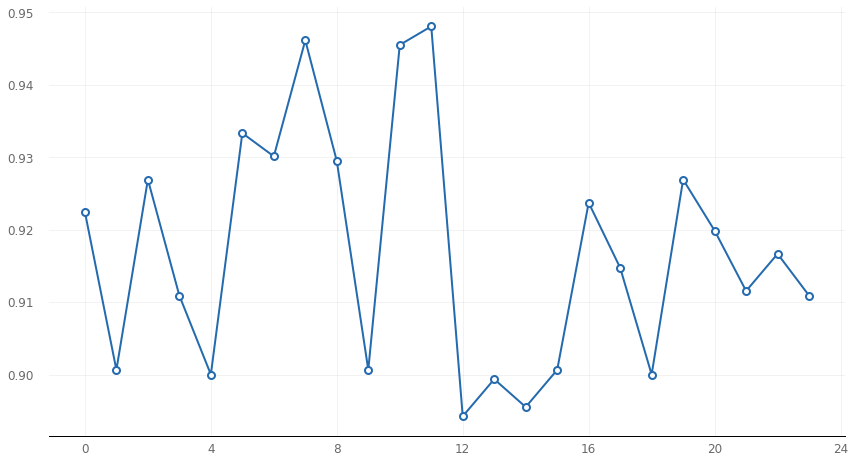

In [0]:
analysis_stat.plot_line('val_accuracy')

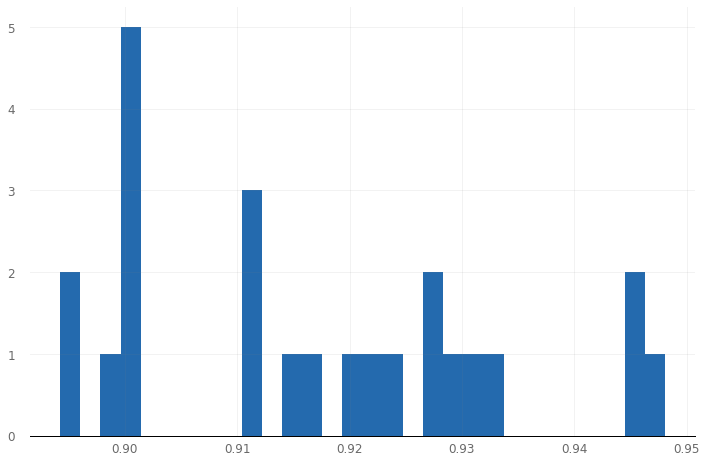

In [0]:
analysis_stat.plot_hist('val_accuracy',bins=30)

In [0]:
p_l={'first_filter':32,
     'epochs': 20,
     'optimizer':'Nadam',
     'activation':'relu'}

In [0]:
sess = tf.Session(graph=tf.get_default_graph())
K.set_session(sess)
# Initiliazing the sequential model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5,activation='relu',
                    kernel_initializer='he_uniform',
                    kernel_regularizer=l2(0.001),input_shape=(128,9)))
model.add(Conv1D(filters=16, kernel_size=3, 
                activation='relu',kernel_regularizer=l2(0.001),kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='RMSprop')
result = model.fit(X_train_c2, Y_train_c2,
                    batch_size=64,
                    nb_epoch=30,
                    verbose=1,
                    validation_data=(X_test_c2, Y_test_c2))

Train on 4067 samples, validate on 1560 samples
Epoch 1/30
4067/4067 [==============================] - 2s 471us/step - loss: 0.5600 - accuracy: 0.8276 - val_loss: 0.4126 - val_accuracy: 0.8885
Epoch 2/30
4067/4067 [==============================] - 1s 305us/step - loss: 0.3097 - accuracy: 0.9093 - val_loss: 0.3576 - val_accuracy: 0.9071
Epoch 3/30
4067/4067 [==============================] - 1s 304us/step - loss: 0.2714 - accuracy: 0.9284 - val_loss: 0.3698 - val_accuracy: 0.9083
Epoch 4/30
4067/4067 [==============================] - 1s 305us/step - loss: 0.2457 - accuracy: 0.9336 - val_loss: 0.3710 - val_accuracy: 0.9141
Epoch 5/30
4067/4067 [==============================] - 1s 305us/step - loss: 0.2323 - accuracy: 0.9405 - val_loss: 0.3942 - val_accuracy: 0.9160
Epoch 6/30
4067/4067 [==============================] - 1s 304us/step - loss: 0.2234 - accuracy: 0.9400 - val_loss: 0.3508 - val_accuracy: 0.8968
Epoch 7/30
4067/4067 [==============================] - 1s 303us/step - loss

In [0]:
# Improving the above model
sess = tf.Session(graph=tf.get_default_graph())
K.set_session(sess)
# Initiliazing the sequential model
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=5,activation='relu',
                    kernel_initializer='he_uniform',
                    kernel_regularizer=l2(0.001),input_shape=(128,9)))
model.add(Conv1D(filters=16, kernel_size=3, 
                activation='relu',kernel_regularizer=l2(0.001),kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='RMSprop')
result = model.fit(X_train_c2, Y_train_c2,
                    batch_size=64,
                    nb_epoch=60,
                    verbose=1,
                    validation_data=(X_test_c2, Y_test_c2))

Train on 4067 samples, validate on 1560 samples
Epoch 1/60
4067/4067 [==============================] - 2s 475us/step - loss: 0.5613 - accuracy: 0.8365 - val_loss: 0.5143 - val_accuracy: 0.8596
Epoch 2/60
4067/4067 [==============================] - 1s 303us/step - loss: 0.3050 - accuracy: 0.9110 - val_loss: 0.5122 - val_accuracy: 0.8705
Epoch 3/60
4067/4067 [==============================] - 1s 302us/step - loss: 0.2798 - accuracy: 0.9233 - val_loss: 0.5326 - val_accuracy: 0.8917
Epoch 4/60
4067/4067 [==============================] - 1s 301us/step - loss: 0.2526 - accuracy: 0.9341 - val_loss: 0.5687 - val_accuracy: 0.8865
Epoch 5/60
4067/4067 [==============================] - 1s 301us/step - loss: 0.2370 - accuracy: 0.9430 - val_loss: 0.5497 - val_accuracy: 0.8974
Epoch 6/60
4067/4067 [==============================] - 1s 304us/step - loss: 0.2227 - accuracy: 0.9432 - val_loss: 0.5336 - val_accuracy: 0.9045
Epoch 7/60
4067/4067 [==============================] - 1s 304us/step - loss

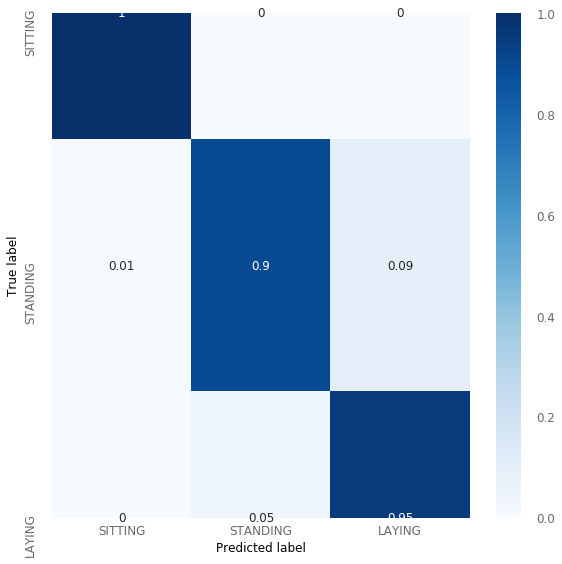

In [0]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns


ACTIVITIES = {
    0: 'SITTING',
    1: 'STANDING',
    2: 'LAYING',
}
classes = list(ACTIVITIES.values())
Y_pred = model.predict(X_test_c2)
y_test = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test_c2, axis=1)])
Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])
#confusion matrix https://androidkt.com/keras-confusion-matrix-in-tensorboard/
con_mat = confusion_matrix(y_test,Y_pred)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm,index = classes, columns = classes)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

* We could see that we have classified  the activities very accurately

In [0]:
#saving model
model.save('model_static.h5')

# Classifying of Dynamic Activities

In [0]:
def load_dyn_y(subset):
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    y_subset = y<=3
    y = y[y_subset]
    return pd.get_dummies(y).as_matrix(),y_subset

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append( _read_csv(filename).as_matrix()) 

In [0]:
Y_train_dyn,y_train_s = load_dyn_y('train')
Y_test_dyn,y_test_s = load_dyn_y('test')
X_train_dyn, X_test_dyn = load_signals('train'), load_signals('test')
X_train_dyn = X_train[y_train_s]
X_test_dyn = X_test[y_test_s]

In [0]:
import wrangle
from sklearn.preprocessing import StandardScaler
#scaling the features
scalers3 = {}
for i in range(X_train_dyn.shape[1]):
    scalers3[i] = StandardScaler()
    X_train_dyn[:, i, :] = scalers3[i].fit_transform(X_train_dyn[:, i, :]) 

for i in range(X_test_dyn.shape[1]):
    X_test_dyn[:, i, :] = scalers3[i].transform(X_test_dyn[:, i, :]) 

In [0]:
print(X_train_dyn.shape,Y_train_dyn.shape)
print(X_test_dyn.shape,Y_test_dyn.shape)

(3285, 128, 9) (3285, 3)
(1387, 128, 9) (1387, 3)


In [0]:
# Baseline using selu
from keras.layers import Conv1D,MaxPooling1D,Flatten
np.random.seed(0)
tf.set_random_seed(0)
sess = tf.Session(graph=tf.get_default_graph())
K.set_session(sess)
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=7, activation='selu',kernel_initializer='he_uniform',input_shape=(128,9)))
model.add(Conv1D(filters=32, kernel_size=5, activation='selu',kernel_initializer='he_uniform'))
model.add(Dropout(0.6))
model.add(MaxPooling1D(pool_size=3))
model.add(Flatten())
model.add(Dense(30, activation='selu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.fit(X_train_dyn,Y_train_dyn, epochs=7, batch_size=32,validation_data=(X_test_dyn, Y_test_dyn), verbose=1)

Train on 3285 samples, validate on 1387 samples
Epoch 1/7
3285/3285 [==============================] - 3s 820us/step - loss: 0.9109 - accuracy: 0.6886 - val_loss: 0.6026 - val_accuracy: 0.8025
Epoch 2/7
3285/3285 [==============================] - 2s 562us/step - loss: 0.1404 - accuracy: 0.9525 - val_loss: 0.3248 - val_accuracy: 0.8940
Epoch 3/7
3285/3285 [==============================] - 2s 556us/step - loss: 0.0570 - accuracy: 0.9799 - val_loss: 0.3805 - val_accuracy: 0.8926
Epoch 4/7
3285/3285 [==============================] - 2s 557us/step - loss: 0.0234 - accuracy: 0.9921 - val_loss: 0.2870 - val_accuracy: 0.9265
Epoch 5/7
3285/3285 [==============================] - 2s 558us/step - loss: 0.0130 - accuracy: 0.9954 - val_loss: 0.2599 - val_accuracy: 0.9257
Epoch 6/7
3285/3285 [==============================] - 2s 565us/step - loss: 0.0057 - accuracy: 0.9982 - val_loss: 0.2781 - val_accuracy: 0.9279
Epoch 7/7
3285/3285 [==============================] - 2s 557us/step - loss: 0.010

In [0]:
np.random.seed(0)
tf.set_random_seed(0)
sess = tf.Session(graph=tf.get_default_graph())
K.set_session(sess)
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=7, activation='relu',kernel_initializer='he_uniform',input_shape=(128,9)))
model.add(Conv1D(filters=32, kernel_size=5, activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.6))
model.add(MaxPooling1D(pool_size=5))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.fit(X_train_dyn,Y_train_dyn, epochs=20, batch_size=64,validation_data=(X_test_dyn, Y_test_dyn), verbose=1)

Train on 3285 samples, validate on 1387 samples
Epoch 1/20
3285/3285 [==============================] - 2s 742us/step - loss: 0.9614 - accuracy: 0.6274 - val_loss: 0.5849 - val_accuracy: 0.8291
Epoch 2/20
3285/3285 [==============================] - 1s 450us/step - loss: 0.2090 - accuracy: 0.9254 - val_loss: 0.2919 - val_accuracy: 0.9106
Epoch 3/20
3285/3285 [==============================] - 1s 452us/step - loss: 0.0632 - accuracy: 0.9775 - val_loss: 0.2299 - val_accuracy: 0.9351
Epoch 4/20
3285/3285 [==============================] - 1s 438us/step - loss: 0.0410 - accuracy: 0.9863 - val_loss: 0.1946 - val_accuracy: 0.9510
Epoch 5/20
3285/3285 [==============================] - 1s 431us/step - loss: 0.0340 - accuracy: 0.9893 - val_loss: 0.1969 - val_accuracy: 0.9560
Epoch 6/20
3285/3285 [==============================] - 1s 433us/step - loss: 0.0172 - accuracy: 0.9936 - val_loss: 0.2022 - val_accuracy: 0.9315
Epoch 7/20
3285/3285 [==============================] - 1s 448us/step - loss

In [0]:
# Baseline using selu
# Note: the feature values and attributes are taken with prior models estimations
np.random.seed(0)
tf.set_random_seed(0)
sess = tf.Session(graph=tf.get_default_graph())
K.set_session(sess)
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=7, activation='relu',kernel_initializer='he_uniform',input_shape=(128,9)))
model.add(Conv1D(filters=32, kernel_size=5, activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.6))
model.add(MaxPooling1D(pool_size=5))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
model.fit(X_train_dyn,Y_train_dyn, epochs=9, batch_size=32,validation_data=(X_test_dyn, Y_test_dyn), verbose=1)

Train on 3285 samples, validate on 1387 samples
Epoch 1/9
3285/3285 [==============================] - 3s 768us/step - loss: 0.5897 - accuracy: 0.7839 - val_loss: 0.2413 - val_accuracy: 0.9387
Epoch 2/9
3285/3285 [==============================] - 2s 519us/step - loss: 0.0271 - accuracy: 0.9924 - val_loss: 0.1762 - val_accuracy: 0.9611
Epoch 3/9
3285/3285 [==============================] - 2s 507us/step - loss: 0.0318 - accuracy: 0.9912 - val_loss: 0.1865 - val_accuracy: 0.9596
Epoch 4/9
3285/3285 [==============================] - 2s 520us/step - loss: 0.0074 - accuracy: 0.9994 - val_loss: 0.1392 - val_accuracy: 0.9676
Epoch 5/9
3285/3285 [==============================] - 2s 524us/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.1454 - val_accuracy: 0.9683
Epoch 6/9
3285/3285 [==============================] - 2s 525us/step - loss: 8.1111e-04 - accuracy: 1.0000 - val_loss: 0.1453 - val_accuracy: 0.9719
Epoch 7/9
3285/3285 [==============================] - 2s 512us/step - loss: 5

* By running the baseline with selu and Adam we just achieved 95% accuracy
* By running the baseline with selu and RMSprop we just achieved 96.2% accuracy
* By running the baseline with selu and Nadam we outperformed and achieved 97.6% accuracy

In [0]:
def dyn_model(X_train_dyn,Y_train_dyn,X_test_dyn,Y_test_dyn,params):
    np.random.seed(0)
    tf.set_random_seed(0)
    sess = tf.Session(graph=tf.get_default_graph())
    K.set_session(sess)
    model = Sequential()
    model.add(Conv1D(filters=params['filter1'], kernel_size=7, activation=params['active'],
                      kernel_initializer='he_uniform',input_shape=(128,9)))
    model.add(Conv1D(filters=params['filter2'], kernel_size=params['k_size'], activation=params['active'],
                      kernel_initializer='he_uniform'))
    model.add(Dropout(0.6))
    model.add(MaxPooling1D(pool_size=params['pool']))
    model.add(Flatten())
    model.add(Dense(30, activation=params['active']))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=params['optim'])
    history = model.fit(X_train_dyn, Y_train_dyn,
                    batch_size=32,
                    nb_epoch=params['epoch'],
                    verbose=1,
                    validation_data=(X_test_dyn, Y_test_dyn))
    return history,model

In [0]:
p_dyn = {'filter1':[32,64],
         'filter2':[32],
         'k_size':[5,7],
         'pool':[3,5],
         'active':['relu','selu'],
         'optim':['RMSprop','Adam'],
         'epoch':[20,30,40]}

In [0]:
%%time
from keras.layers import Conv1D ,MaxPooling1D,Flatten
from keras.activations import relu,selu
import talos as ts
td = ts.Scan(x=X_train_dyn,
               y=Y_train_dyn,
               model=dyn_model,
               params=p_dyn,
               experiment_name='dyn_model')



  0%|          | 0/96 [00:00<?, ?it/s]

Train on 2299 samples, validate on 986 samples
Epoch 1/20
2299/2299 [==============================] - 2s 963us/step - loss: 0.9008 - accuracy: 0.6281 - val_loss: 0.3482 - val_accuracy: 0.9361
Epoch 2/20
2299/2299 [==============================] - 1s 526us/step - loss: 0.1659 - accuracy: 0.9430 - val_loss: 0.1031 - val_accuracy: 0.9736
Epoch 3/20
2299/2299 [==============================] - 1s 527us/step - loss: 0.0584 - accuracy: 0.9804 - val_loss: 0.0232 - val_accuracy: 0.9980
Epoch 4/20
2299/2299 [==============================] - 1s 542us/step - loss: 0.0277 - accuracy: 0.9913 - val_loss: 0.0119 - val_accuracy: 0.9959
Epoch 5/20
2299/2299 [==============================] - 1s 551us/step - loss: 0.0242 - accuracy: 0.9952 - val_loss: 0.0079 - val_accuracy: 1.0000
Epoch 6/20
2299/2299 [==============================] - 1s 547us/step - loss: 0.0187 - accuracy: 0.9926 - val_loss: 0.0075 - val_accuracy: 1.0000
Epoch 7/20
2299/2299 [==============================] - 1s 555us/step - loss:



  1%|          | 1/96 [00:30<47:38, 30.09s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/20
2299/2299 [==============================] - 1s 605us/step - loss: 0.9010 - accuracy: 0.6538 - val_loss: 0.3963 - val_accuracy: 0.9006
Epoch 2/20
2299/2299 [==============================] - 1s 469us/step - loss: 0.1721 - accuracy: 0.9439 - val_loss: 0.1085 - val_accuracy: 0.9858
Epoch 3/20
2299/2299 [==============================] - 1s 456us/step - loss: 0.0658 - accuracy: 0.9774 - val_loss: 0.0434 - val_accuracy: 0.9970
Epoch 4/20
2299/2299 [==============================] - 1s 449us/step - loss: 0.0356 - accuracy: 0.9896 - val_loss: 0.0250 - val_accuracy: 0.9949
Epoch 5/20
2299/2299 [==============================] - 1s 459us/step - loss: 0.0169 - accuracy: 0.9943 - val_loss: 0.0170 - val_accuracy: 0.9990
Epoch 6/20
2299/2299 [==============================] - 1s 461us/step - loss: 0.0115 - accuracy: 0.9961 - val_loss: 0.1369 - val_accuracy: 0.9391
Epoch 7/20
2299/2299 [==============================] - 1s 465us/step - loss:



  2%|▏         | 2/96 [00:52<43:43, 27.91s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/20
2299/2299 [==============================] - 1s 650us/step - loss: 1.0199 - accuracy: 0.5515 - val_loss: 0.5655 - val_accuracy: 0.8266
Epoch 2/20
2299/2299 [==============================] - 1s 500us/step - loss: 0.2270 - accuracy: 0.9269 - val_loss: 0.0998 - val_accuracy: 0.9899
Epoch 3/20
2299/2299 [==============================] - 1s 496us/step - loss: 0.0537 - accuracy: 0.9817 - val_loss: 0.0526 - val_accuracy: 0.9899
Epoch 4/20
2299/2299 [==============================] - 1s 481us/step - loss: 0.0165 - accuracy: 0.9965 - val_loss: 0.0381 - val_accuracy: 0.9939
Epoch 5/20
2299/2299 [==============================] - 1s 491us/step - loss: 0.0089 - accuracy: 0.9974 - val_loss: 0.0269 - val_accuracy: 0.9949
Epoch 6/20
2299/2299 [==============================] - 1s 486us/step - loss: 0.0097 - accuracy: 0.9970 - val_loss: 0.0122 - val_accuracy: 1.0000
Epoch 7/20
2299/2299 [==============================] - 1s 496us/step - loss:



  3%|▎         | 3/96 [01:17<41:36, 26.85s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/20
2299/2299 [==============================] - 1s 628us/step - loss: 0.9906 - accuracy: 0.5942 - val_loss: 0.5800 - val_accuracy: 0.8225
Epoch 2/20
2299/2299 [==============================] - 1s 487us/step - loss: 0.2033 - accuracy: 0.9417 - val_loss: 0.1441 - val_accuracy: 0.9899
Epoch 3/20
2299/2299 [==============================] - 1s 480us/step - loss: 0.0694 - accuracy: 0.9787 - val_loss: 0.0782 - val_accuracy: 0.9909
Epoch 4/20
2299/2299 [==============================] - 1s 480us/step - loss: 0.0203 - accuracy: 0.9965 - val_loss: 0.0531 - val_accuracy: 0.9949
Epoch 5/20
2299/2299 [==============================] - 1s 480us/step - loss: 0.0130 - accuracy: 0.9970 - val_loss: 0.0368 - val_accuracy: 0.9949
Epoch 6/20
2299/2299 [==============================] - 1s 479us/step - loss: 0.0069 - accuracy: 0.9987 - val_loss: 0.0216 - val_accuracy: 1.0000
Epoch 7/20
2299/2299 [==============================] - 1s 478us/step - loss:



  4%|▍         | 4/96 [01:40<39:36, 25.83s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/20
2299/2299 [==============================] - 2s 654us/step - loss: 0.7874 - accuracy: 0.6738 - val_loss: 0.2612 - val_accuracy: 0.9554
Epoch 2/20
2299/2299 [==============================] - 1s 530us/step - loss: 0.1303 - accuracy: 0.9582 - val_loss: 0.0900 - val_accuracy: 0.9777
Epoch 3/20
2299/2299 [==============================] - 1s 537us/step - loss: 0.0467 - accuracy: 0.9843 - val_loss: 0.0260 - val_accuracy: 0.9949
Epoch 4/20
2299/2299 [==============================] - 1s 522us/step - loss: 0.0323 - accuracy: 0.9896 - val_loss: 0.0197 - val_accuracy: 0.9959
Epoch 5/20
2299/2299 [==============================] - 1s 518us/step - loss: 0.0147 - accuracy: 0.9952 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 6/20
2299/2299 [==============================] - 1s 513us/step - loss: 0.0043 - accuracy: 0.9983 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 7/20
2299/2299 [==============================] - 1s 522us/step - loss:



  5%|▌         | 5/96 [02:06<39:04, 25.76s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/20
2299/2299 [==============================] - 1s 646us/step - loss: 0.7399 - accuracy: 0.7086 - val_loss: 0.2662 - val_accuracy: 0.9655
Epoch 2/20
2299/2299 [==============================] - 1s 531us/step - loss: 0.1300 - accuracy: 0.9561 - val_loss: 0.0944 - val_accuracy: 0.9878
Epoch 3/20
2299/2299 [==============================] - 1s 531us/step - loss: 0.0463 - accuracy: 0.9839 - val_loss: 0.0381 - val_accuracy: 0.9980
Epoch 4/20
2299/2299 [==============================] - 1s 532us/step - loss: 0.0214 - accuracy: 0.9926 - val_loss: 0.0955 - val_accuracy: 0.9655
Epoch 5/20
2299/2299 [==============================] - 1s 537us/step - loss: 0.0136 - accuracy: 0.9948 - val_loss: 0.0105 - val_accuracy: 1.0000
Epoch 6/20
2299/2299 [==============================] - 1s 538us/step - loss: 0.0116 - accuracy: 0.9970 - val_loss: 0.0095 - val_accuracy: 0.9990
Epoch 7/20
2299/2299 [==============================] - 1s 534us/step - loss:



  6%|▋         | 6/96 [02:32<38:39, 25.77s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/20
2299/2299 [==============================] - 2s 668us/step - loss: 0.8554 - accuracy: 0.6364 - val_loss: 0.3436 - val_accuracy: 0.9158
Epoch 2/20
2299/2299 [==============================] - 1s 533us/step - loss: 0.1430 - accuracy: 0.9574 - val_loss: 0.0768 - val_accuracy: 0.9899
Epoch 3/20
2299/2299 [==============================] - 1s 529us/step - loss: 0.0356 - accuracy: 0.9904 - val_loss: 0.0373 - val_accuracy: 0.9970
Epoch 4/20
2299/2299 [==============================] - 1s 543us/step - loss: 0.0173 - accuracy: 0.9939 - val_loss: 0.0283 - val_accuracy: 0.9970
Epoch 5/20
2299/2299 [==============================] - 1s 536us/step - loss: 0.0072 - accuracy: 0.9983 - val_loss: 0.0172 - val_accuracy: 0.9970
Epoch 6/20
2299/2299 [==============================] - 1s 545us/step - loss: 0.0045 - accuracy: 0.9991 - val_loss: 0.0561 - val_accuracy: 0.9828
Epoch 7/20
2299/2299 [==============================] - 1s 550us/step - loss:



  7%|▋         | 7/96 [02:58<38:34, 26.01s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/20
2299/2299 [==============================] - 2s 658us/step - loss: 0.8261 - accuracy: 0.6599 - val_loss: 0.4023 - val_accuracy: 0.8854
Epoch 2/20
2299/2299 [==============================] - 1s 529us/step - loss: 0.1464 - accuracy: 0.9569 - val_loss: 0.1024 - val_accuracy: 0.9929
Epoch 3/20
2299/2299 [==============================] - 1s 533us/step - loss: 0.0463 - accuracy: 0.9826 - val_loss: 0.0542 - val_accuracy: 0.9990
Epoch 4/20
2299/2299 [==============================] - 1s 534us/step - loss: 0.0230 - accuracy: 0.9930 - val_loss: 0.0360 - val_accuracy: 0.9980
Epoch 5/20
2299/2299 [==============================] - 1s 528us/step - loss: 0.0077 - accuracy: 0.9991 - val_loss: 0.0243 - val_accuracy: 0.9990
Epoch 6/20
2299/2299 [==============================] - 1s 535us/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0238 - val_accuracy: 0.9990
Epoch 7/20
2299/2299 [==============================] - 1s 540us/step - loss:



  8%|▊         | 8/96 [03:25<38:16, 26.10s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/20
2299/2299 [==============================] - 2s 812us/step - loss: 0.6756 - accuracy: 0.7255 - val_loss: 0.1687 - val_accuracy: 0.9888
Epoch 2/20
2299/2299 [==============================] - 2s 687us/step - loss: 0.0720 - accuracy: 0.9769 - val_loss: 0.0655 - val_accuracy: 0.9848
Epoch 3/20
2299/2299 [==============================] - 2s 680us/step - loss: 0.0363 - accuracy: 0.9917 - val_loss: 0.0128 - val_accuracy: 0.9980
Epoch 4/20
2299/2299 [==============================] - 2s 686us/step - loss: 0.0078 - accuracy: 0.9983 - val_loss: 0.0081 - val_accuracy: 0.9990
Epoch 5/20
2299/2299 [==============================] - 2s 675us/step - loss: 0.0051 - accuracy: 0.9978 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 6/20
2299/2299 [==============================] - 2s 662us/step - loss: 0.0222 - accuracy: 0.9957 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 7/20
2299/2299 [==============================] - 2s 669us/step - loss:



  9%|▉         | 9/96 [03:57<40:48, 28.14s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/20
2299/2299 [==============================] - 2s 789us/step - loss: 0.7583 - accuracy: 0.7003 - val_loss: 0.2929 - val_accuracy: 0.9655
Epoch 2/20
2299/2299 [==============================] - 2s 674us/step - loss: 0.1103 - accuracy: 0.9678 - val_loss: 0.1342 - val_accuracy: 0.9757
Epoch 3/20
2299/2299 [==============================] - 2s 672us/step - loss: 0.0391 - accuracy: 0.9856 - val_loss: 0.0285 - val_accuracy: 0.9970
Epoch 4/20
2299/2299 [==============================] - 2s 675us/step - loss: 0.0239 - accuracy: 0.9922 - val_loss: 0.0443 - val_accuracy: 0.9909
Epoch 5/20
2299/2299 [==============================] - 2s 679us/step - loss: 0.0116 - accuracy: 0.9943 - val_loss: 0.1408 - val_accuracy: 0.9391
Epoch 6/20
2299/2299 [==============================] - 2s 689us/step - loss: 0.0065 - accuracy: 0.9983 - val_loss: 0.0090 - val_accuracy: 0.9970
Epoch 7/20
2299/2299 [==============================] - 2s 692us/step - loss:



 10%|█         | 10/96 [04:30<42:20, 29.54s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/20
2299/2299 [==============================] - 2s 840us/step - loss: 0.8461 - accuracy: 0.6216 - val_loss: 0.3183 - val_accuracy: 0.9432
Epoch 2/20
2299/2299 [==============================] - 2s 671us/step - loss: 0.0876 - accuracy: 0.9730 - val_loss: 0.0818 - val_accuracy: 0.9878
Epoch 3/20
2299/2299 [==============================] - 2s 683us/step - loss: 0.0193 - accuracy: 0.9952 - val_loss: 0.0312 - val_accuracy: 0.9970
Epoch 4/20
2299/2299 [==============================] - 2s 705us/step - loss: 0.0085 - accuracy: 0.9987 - val_loss: 0.0292 - val_accuracy: 0.9970
Epoch 5/20
2299/2299 [==============================] - 2s 697us/step - loss: 0.0098 - accuracy: 0.9974 - val_loss: 0.0260 - val_accuracy: 0.9959
Epoch 6/20
2299/2299 [==============================] - 2s 696us/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0118 - val_accuracy: 0.9990
Epoch 7/20
2299/2299 [==============================] - 2s 712us/step - loss:



 11%|█▏        | 11/96 [05:04<43:42, 30.85s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/20
2299/2299 [==============================] - 2s 849us/step - loss: 0.8264 - accuracy: 0.6603 - val_loss: 0.4320 - val_accuracy: 0.8895
Epoch 2/20
2299/2299 [==============================] - 2s 706us/step - loss: 0.1126 - accuracy: 0.9661 - val_loss: 0.1101 - val_accuracy: 0.9878
Epoch 3/20
2299/2299 [==============================] - 2s 694us/step - loss: 0.0322 - accuracy: 0.9896 - val_loss: 0.0661 - val_accuracy: 0.9959
Epoch 4/20
2299/2299 [==============================] - 2s 688us/step - loss: 0.0132 - accuracy: 0.9961 - val_loss: 0.0399 - val_accuracy: 0.9980
Epoch 5/20
2299/2299 [==============================] - 2s 698us/step - loss: 0.0053 - accuracy: 0.9996 - val_loss: 0.0274 - val_accuracy: 0.9980
Epoch 6/20
2299/2299 [==============================] - 2s 712us/step - loss: 0.0039 - accuracy: 0.9996 - val_loss: 0.0249 - val_accuracy: 0.9980
Epoch 7/20
2299/2299 [==============================] - 2s 701us/step - loss:



 12%|█▎        | 12/96 [05:38<44:30, 31.79s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/20
2299/2299 [==============================] - 2s 972us/step - loss: 0.7214 - accuracy: 0.6951 - val_loss: 0.2088 - val_accuracy: 0.9665
Epoch 2/20
2299/2299 [==============================] - 2s 854us/step - loss: 0.0918 - accuracy: 0.9674 - val_loss: 0.0405 - val_accuracy: 0.9959
Epoch 3/20
2299/2299 [==============================] - 2s 837us/step - loss: 0.0291 - accuracy: 0.9896 - val_loss: 0.0149 - val_accuracy: 0.9990
Epoch 4/20
2299/2299 [==============================] - 2s 820us/step - loss: 0.0268 - accuracy: 0.9930 - val_loss: 0.0071 - val_accuracy: 1.0000
Epoch 5/20
2299/2299 [==============================] - 2s 833us/step - loss: 0.0188 - accuracy: 0.9930 - val_loss: 0.0087 - val_accuracy: 0.9990
Epoch 6/20
2299/2299 [==============================] - 2s 844us/step - loss: 0.0334 - accuracy: 0.9930 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 7/20
2299/2299 [==============================] - 2s 846us/step - loss:



 14%|█▎        | 13/96 [06:18<47:27, 34.31s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/20
2299/2299 [==============================] - 2s 966us/step - loss: 0.7571 - accuracy: 0.6903 - val_loss: 0.2782 - val_accuracy: 0.9807
Epoch 2/20
2299/2299 [==============================] - 2s 840us/step - loss: 0.1275 - accuracy: 0.9582 - val_loss: 0.2220 - val_accuracy: 0.9168
Epoch 3/20
2299/2299 [==============================] - 2s 823us/step - loss: 0.0416 - accuracy: 0.9852 - val_loss: 0.0249 - val_accuracy: 1.0000
Epoch 4/20
2299/2299 [==============================] - 2s 822us/step - loss: 0.0279 - accuracy: 0.9939 - val_loss: 0.0097 - val_accuracy: 1.0000
Epoch 5/20
2299/2299 [==============================] - 2s 827us/step - loss: 0.0225 - accuracy: 0.9948 - val_loss: 0.0101 - val_accuracy: 1.0000
Epoch 6/20
2299/2299 [==============================] - 2s 835us/step - loss: 0.0102 - accuracy: 0.9974 - val_loss: 0.0083 - val_accuracy: 0.9990
Epoch 7/20
2299/2299 [==============================] - 2s 829us/step - loss:



 15%|█▍        | 14/96 [06:58<49:00, 35.86s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/20
2299/2299 [==============================] - 2s 996us/step - loss: 0.8132 - accuracy: 0.6612 - val_loss: 0.3313 - val_accuracy: 0.9402
Epoch 2/20
2299/2299 [==============================] - 2s 871us/step - loss: 0.0873 - accuracy: 0.9769 - val_loss: 0.0525 - val_accuracy: 0.9939
Epoch 3/20
2299/2299 [==============================] - 2s 856us/step - loss: 0.0210 - accuracy: 0.9943 - val_loss: 0.0297 - val_accuracy: 0.9959
Epoch 4/20
2299/2299 [==============================] - 2s 856us/step - loss: 0.0074 - accuracy: 0.9974 - val_loss: 0.0142 - val_accuracy: 0.9990
Epoch 5/20
2299/2299 [==============================] - 2s 863us/step - loss: 0.0060 - accuracy: 0.9983 - val_loss: 0.0187 - val_accuracy: 0.9959
Epoch 6/20
2299/2299 [==============================] - 2s 865us/step - loss: 0.0059 - accuracy: 0.9987 - val_loss: 0.0082 - val_accuracy: 0.9990
Epoch 7/20
2299/2299 [==============================] - 2s 855us/step - loss:



 16%|█▌        | 15/96 [07:39<50:29, 37.40s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/20
2299/2299 [==============================] - 2s 983us/step - loss: 0.8446 - accuracy: 0.6612 - val_loss: 0.3854 - val_accuracy: 0.9290
Epoch 2/20
2299/2299 [==============================] - 2s 835us/step - loss: 0.1051 - accuracy: 0.9704 - val_loss: 0.0918 - val_accuracy: 0.9939
Epoch 3/20
2299/2299 [==============================] - 2s 847us/step - loss: 0.0238 - accuracy: 0.9939 - val_loss: 0.0647 - val_accuracy: 0.9899
Epoch 4/20
2299/2299 [==============================] - 2s 826us/step - loss: 0.0143 - accuracy: 0.9952 - val_loss: 0.0372 - val_accuracy: 0.9939
Epoch 5/20
2299/2299 [==============================] - 2s 833us/step - loss: 0.0061 - accuracy: 0.9991 - val_loss: 0.0203 - val_accuracy: 1.0000
Epoch 6/20
2299/2299 [==============================] - 2s 851us/step - loss: 0.0066 - accuracy: 0.9978 - val_loss: 0.0173 - val_accuracy: 0.9990
Epoch 7/20
2299/2299 [==============================] - 2s 848us/step - loss:



 17%|█▋        | 16/96 [08:19<51:05, 38.32s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/30
2299/2299 [==============================] - 1s 614us/step - loss: 0.9008 - accuracy: 0.6281 - val_loss: 0.3482 - val_accuracy: 0.9361
Epoch 2/30
2299/2299 [==============================] - 1s 490us/step - loss: 0.1659 - accuracy: 0.9430 - val_loss: 0.1031 - val_accuracy: 0.9736
Epoch 3/30
2299/2299 [==============================] - 1s 482us/step - loss: 0.0584 - accuracy: 0.9804 - val_loss: 0.0232 - val_accuracy: 0.9980
Epoch 4/30
2299/2299 [==============================] - 1s 490us/step - loss: 0.0277 - accuracy: 0.9913 - val_loss: 0.0119 - val_accuracy: 0.9959
Epoch 5/30
2299/2299 [==============================] - 1s 485us/step - loss: 0.0242 - accuracy: 0.9952 - val_loss: 0.0079 - val_accuracy: 1.0000
Epoch 6/30
2299/2299 [==============================] - 1s 491us/step - loss: 0.0187 - accuracy: 0.9926 - val_loss: 0.0075 - val_accuracy: 1.0000
Epoch 7/30
2299/2299 [==============================] - 1s 487us/step - loss:



 18%|█▊        | 17/96 [08:54<49:01, 37.24s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/30
2299/2299 [==============================] - 1s 596us/step - loss: 0.9010 - accuracy: 0.6538 - val_loss: 0.3963 - val_accuracy: 0.9006
Epoch 2/30
2299/2299 [==============================] - 1s 469us/step - loss: 0.1721 - accuracy: 0.9439 - val_loss: 0.1085 - val_accuracy: 0.9858
Epoch 3/30
2299/2299 [==============================] - 1s 465us/step - loss: 0.0658 - accuracy: 0.9774 - val_loss: 0.0434 - val_accuracy: 0.9970
Epoch 4/30
2299/2299 [==============================] - 1s 467us/step - loss: 0.0356 - accuracy: 0.9896 - val_loss: 0.0250 - val_accuracy: 0.9949
Epoch 5/30
2299/2299 [==============================] - 1s 469us/step - loss: 0.0169 - accuracy: 0.9943 - val_loss: 0.0170 - val_accuracy: 0.9990
Epoch 6/30
2299/2299 [==============================] - 1s 476us/step - loss: 0.0115 - accuracy: 0.9961 - val_loss: 0.1369 - val_accuracy: 0.9391
Epoch 7/30
2299/2299 [==============================] - 1s 472us/step - loss:



 19%|█▉        | 18/96 [09:28<47:10, 36.29s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/30
2299/2299 [==============================] - 1s 638us/step - loss: 1.0199 - accuracy: 0.5515 - val_loss: 0.5655 - val_accuracy: 0.8266
Epoch 2/30
2299/2299 [==============================] - 1s 505us/step - loss: 0.2270 - accuracy: 0.9269 - val_loss: 0.0998 - val_accuracy: 0.9899
Epoch 3/30
2299/2299 [==============================] - 1s 517us/step - loss: 0.0537 - accuracy: 0.9817 - val_loss: 0.0526 - val_accuracy: 0.9899
Epoch 4/30
2299/2299 [==============================] - 1s 506us/step - loss: 0.0165 - accuracy: 0.9965 - val_loss: 0.0381 - val_accuracy: 0.9939
Epoch 5/30
2299/2299 [==============================] - 1s 494us/step - loss: 0.0089 - accuracy: 0.9974 - val_loss: 0.0269 - val_accuracy: 0.9949
Epoch 6/30
2299/2299 [==============================] - 1s 493us/step - loss: 0.0097 - accuracy: 0.9970 - val_loss: 0.0122 - val_accuracy: 1.0000
Epoch 7/30
2299/2299 [==============================] - 1s 510us/step - loss:



 20%|█▉        | 19/96 [10:04<46:26, 36.19s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/30
2299/2299 [==============================] - 1s 634us/step - loss: 0.9906 - accuracy: 0.5942 - val_loss: 0.5800 - val_accuracy: 0.8225
Epoch 2/30
2299/2299 [==============================] - 1s 482us/step - loss: 0.2033 - accuracy: 0.9417 - val_loss: 0.1441 - val_accuracy: 0.9899
Epoch 3/30
2299/2299 [==============================] - 1s 480us/step - loss: 0.0694 - accuracy: 0.9787 - val_loss: 0.0782 - val_accuracy: 0.9909
Epoch 4/30
2299/2299 [==============================] - 1s 484us/step - loss: 0.0203 - accuracy: 0.9965 - val_loss: 0.0531 - val_accuracy: 0.9949
Epoch 5/30
2299/2299 [==============================] - 1s 482us/step - loss: 0.0130 - accuracy: 0.9970 - val_loss: 0.0368 - val_accuracy: 0.9949
Epoch 6/30
2299/2299 [==============================] - 1s 484us/step - loss: 0.0069 - accuracy: 0.9987 - val_loss: 0.0216 - val_accuracy: 1.0000
Epoch 7/30
2299/2299 [==============================] - 1s 486us/step - loss:



 21%|██        | 20/96 [10:39<45:22, 35.82s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/30
2299/2299 [==============================] - 2s 674us/step - loss: 0.7874 - accuracy: 0.6738 - val_loss: 0.2612 - val_accuracy: 0.9554
Epoch 2/30
2299/2299 [==============================] - 1s 561us/step - loss: 0.1303 - accuracy: 0.9582 - val_loss: 0.0900 - val_accuracy: 0.9777
Epoch 3/30
2299/2299 [==============================] - 1s 544us/step - loss: 0.0467 - accuracy: 0.9843 - val_loss: 0.0260 - val_accuracy: 0.9949
Epoch 4/30
2299/2299 [==============================] - 1s 535us/step - loss: 0.0323 - accuracy: 0.9896 - val_loss: 0.0197 - val_accuracy: 0.9959
Epoch 5/30
2299/2299 [==============================] - 1s 518us/step - loss: 0.0147 - accuracy: 0.9952 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 6/30
2299/2299 [==============================] - 1s 518us/step - loss: 0.0043 - accuracy: 0.9983 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 7/30
2299/2299 [==============================] - 1s 520us/step - loss:



 22%|██▏       | 21/96 [11:17<45:46, 36.62s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/30
2299/2299 [==============================] - 2s 655us/step - loss: 0.7399 - accuracy: 0.7086 - val_loss: 0.2662 - val_accuracy: 0.9655
Epoch 2/30
2299/2299 [==============================] - 1s 532us/step - loss: 0.1300 - accuracy: 0.9561 - val_loss: 0.0944 - val_accuracy: 0.9878
Epoch 3/30
2299/2299 [==============================] - 1s 545us/step - loss: 0.0463 - accuracy: 0.9839 - val_loss: 0.0381 - val_accuracy: 0.9980
Epoch 4/30
2299/2299 [==============================] - 1s 537us/step - loss: 0.0214 - accuracy: 0.9926 - val_loss: 0.0955 - val_accuracy: 0.9655
Epoch 5/30
2299/2299 [==============================] - 1s 531us/step - loss: 0.0136 - accuracy: 0.9948 - val_loss: 0.0105 - val_accuracy: 1.0000
Epoch 6/30
2299/2299 [==============================] - 1s 539us/step - loss: 0.0116 - accuracy: 0.9970 - val_loss: 0.0095 - val_accuracy: 0.9990
Epoch 7/30
2299/2299 [==============================] - 1s 540us/step - loss:



 23%|██▎       | 22/96 [11:55<45:35, 36.97s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/30
2299/2299 [==============================] - 2s 691us/step - loss: 0.8554 - accuracy: 0.6364 - val_loss: 0.3436 - val_accuracy: 0.9158
Epoch 2/30
2299/2299 [==============================] - 1s 541us/step - loss: 0.1430 - accuracy: 0.9574 - val_loss: 0.0768 - val_accuracy: 0.9899
Epoch 3/30
2299/2299 [==============================] - 1s 539us/step - loss: 0.0356 - accuracy: 0.9904 - val_loss: 0.0373 - val_accuracy: 0.9970
Epoch 4/30
2299/2299 [==============================] - 1s 541us/step - loss: 0.0173 - accuracy: 0.9939 - val_loss: 0.0283 - val_accuracy: 0.9970
Epoch 5/30
2299/2299 [==============================] - 1s 548us/step - loss: 0.0072 - accuracy: 0.9983 - val_loss: 0.0172 - val_accuracy: 0.9970
Epoch 6/30
2299/2299 [==============================] - 1s 548us/step - loss: 0.0045 - accuracy: 0.9991 - val_loss: 0.0561 - val_accuracy: 0.9828
Epoch 7/30
2299/2299 [==============================] - 1s 550us/step - loss:



 24%|██▍       | 23/96 [12:34<45:45, 37.61s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/30
2299/2299 [==============================] - 1s 646us/step - loss: 0.8261 - accuracy: 0.6599 - val_loss: 0.4023 - val_accuracy: 0.8854
Epoch 2/30
2299/2299 [==============================] - 1s 525us/step - loss: 0.1464 - accuracy: 0.9569 - val_loss: 0.1024 - val_accuracy: 0.9929
Epoch 3/30
2299/2299 [==============================] - 1s 525us/step - loss: 0.0464 - accuracy: 0.9826 - val_loss: 0.0541 - val_accuracy: 0.9990
Epoch 4/30
2299/2299 [==============================] - 1s 537us/step - loss: 0.0227 - accuracy: 0.9926 - val_loss: 0.0357 - val_accuracy: 0.9990
Epoch 5/30
2299/2299 [==============================] - 1s 538us/step - loss: 0.0081 - accuracy: 0.9987 - val_loss: 0.0235 - val_accuracy: 0.9990
Epoch 6/30
2299/2299 [==============================] - 1s 538us/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0238 - val_accuracy: 0.9980
Epoch 7/30
2299/2299 [==============================] - 1s 532us/step - loss:



 25%|██▌       | 24/96 [13:13<45:26, 37.87s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/30
2299/2299 [==============================] - 2s 818us/step - loss: 0.6756 - accuracy: 0.7255 - val_loss: 0.1687 - val_accuracy: 0.9888
Epoch 2/30
2299/2299 [==============================] - 2s 691us/step - loss: 0.0720 - accuracy: 0.9769 - val_loss: 0.0655 - val_accuracy: 0.9848
Epoch 3/30
2299/2299 [==============================] - 2s 709us/step - loss: 0.0363 - accuracy: 0.9917 - val_loss: 0.0128 - val_accuracy: 0.9980
Epoch 4/30
2299/2299 [==============================] - 2s 702us/step - loss: 0.0078 - accuracy: 0.9983 - val_loss: 0.0081 - val_accuracy: 0.9990
Epoch 5/30
2299/2299 [==============================] - 2s 702us/step - loss: 0.0051 - accuracy: 0.9978 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 6/30
2299/2299 [==============================] - 2s 699us/step - loss: 0.0222 - accuracy: 0.9957 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 7/30
2299/2299 [==============================] - 2s 690us/step - loss:



 26%|██▌       | 25/96 [14:02<48:48, 41.25s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/30
2299/2299 [==============================] - 2s 827us/step - loss: 0.7583 - accuracy: 0.7003 - val_loss: 0.2929 - val_accuracy: 0.9655
Epoch 2/30
2299/2299 [==============================] - 2s 696us/step - loss: 0.1103 - accuracy: 0.9678 - val_loss: 0.1342 - val_accuracy: 0.9757
Epoch 3/30
2299/2299 [==============================] - 2s 677us/step - loss: 0.0391 - accuracy: 0.9856 - val_loss: 0.0285 - val_accuracy: 0.9970
Epoch 4/30
2299/2299 [==============================] - 2s 686us/step - loss: 0.0239 - accuracy: 0.9922 - val_loss: 0.0443 - val_accuracy: 0.9909
Epoch 5/30
2299/2299 [==============================] - 2s 693us/step - loss: 0.0116 - accuracy: 0.9943 - val_loss: 0.1408 - val_accuracy: 0.9391
Epoch 6/30
2299/2299 [==============================] - 2s 689us/step - loss: 0.0065 - accuracy: 0.9983 - val_loss: 0.0090 - val_accuracy: 0.9970
Epoch 7/30
2299/2299 [==============================] - 2s 689us/step - loss:



 27%|██▋       | 26/96 [14:51<50:43, 43.48s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/30
2299/2299 [==============================] - 2s 856us/step - loss: 0.8461 - accuracy: 0.6216 - val_loss: 0.3183 - val_accuracy: 0.9432
Epoch 2/30
2299/2299 [==============================] - 2s 713us/step - loss: 0.0876 - accuracy: 0.9730 - val_loss: 0.0818 - val_accuracy: 0.9878
Epoch 3/30
2299/2299 [==============================] - 2s 694us/step - loss: 0.0193 - accuracy: 0.9952 - val_loss: 0.0312 - val_accuracy: 0.9970
Epoch 4/30
2299/2299 [==============================] - 2s 705us/step - loss: 0.0085 - accuracy: 0.9987 - val_loss: 0.0292 - val_accuracy: 0.9970
Epoch 5/30
2299/2299 [==============================] - 2s 703us/step - loss: 0.0098 - accuracy: 0.9974 - val_loss: 0.0260 - val_accuracy: 0.9959
Epoch 6/30
2299/2299 [==============================] - 2s 692us/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0118 - val_accuracy: 0.9990
Epoch 7/30
2299/2299 [==============================] - 2s 695us/step - loss:



 28%|██▊       | 27/96 [15:40<52:08, 45.34s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/30
2299/2299 [==============================] - 2s 826us/step - loss: 0.8264 - accuracy: 0.6603 - val_loss: 0.4320 - val_accuracy: 0.8895
Epoch 2/30
2299/2299 [==============================] - 2s 708us/step - loss: 0.1126 - accuracy: 0.9661 - val_loss: 0.1101 - val_accuracy: 0.9878
Epoch 3/30
2299/2299 [==============================] - 2s 692us/step - loss: 0.0322 - accuracy: 0.9896 - val_loss: 0.0661 - val_accuracy: 0.9959
Epoch 4/30
2299/2299 [==============================] - 2s 684us/step - loss: 0.0132 - accuracy: 0.9961 - val_loss: 0.0399 - val_accuracy: 0.9980
Epoch 5/30
2299/2299 [==============================] - 2s 702us/step - loss: 0.0053 - accuracy: 0.9996 - val_loss: 0.0274 - val_accuracy: 0.9980
Epoch 6/30
2299/2299 [==============================] - 2s 718us/step - loss: 0.0039 - accuracy: 0.9996 - val_loss: 0.0249 - val_accuracy: 0.9980
Epoch 7/30
2299/2299 [==============================] - 2s 729us/step - loss:



 29%|██▉       | 28/96 [16:30<52:50, 46.63s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/30
2299/2299 [==============================] - 2s 959us/step - loss: 0.7214 - accuracy: 0.6951 - val_loss: 0.2088 - val_accuracy: 0.9665
Epoch 2/30
2299/2299 [==============================] - 2s 808us/step - loss: 0.0918 - accuracy: 0.9674 - val_loss: 0.0405 - val_accuracy: 0.9959
Epoch 3/30
2299/2299 [==============================] - 2s 818us/step - loss: 0.0291 - accuracy: 0.9896 - val_loss: 0.0149 - val_accuracy: 0.9990
Epoch 4/30
2299/2299 [==============================] - 2s 814us/step - loss: 0.0268 - accuracy: 0.9930 - val_loss: 0.0071 - val_accuracy: 1.0000
Epoch 5/30
2299/2299 [==============================] - 2s 837us/step - loss: 0.0188 - accuracy: 0.9930 - val_loss: 0.0087 - val_accuracy: 0.9990
Epoch 6/30
2299/2299 [==============================] - 2s 847us/step - loss: 0.0334 - accuracy: 0.9930 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 7/30
2299/2299 [==============================] - 2s 838us/step - loss:



 30%|███       | 29/96 [17:29<56:23, 50.50s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/30
2299/2299 [==============================] - 2s 956us/step - loss: 0.7571 - accuracy: 0.6903 - val_loss: 0.2782 - val_accuracy: 0.9807
Epoch 2/30
2299/2299 [==============================] - 2s 799us/step - loss: 0.1275 - accuracy: 0.9582 - val_loss: 0.2220 - val_accuracy: 0.9168
Epoch 3/30
2299/2299 [==============================] - 2s 801us/step - loss: 0.0416 - accuracy: 0.9852 - val_loss: 0.0249 - val_accuracy: 1.0000
Epoch 4/30
2299/2299 [==============================] - 2s 825us/step - loss: 0.0279 - accuracy: 0.9939 - val_loss: 0.0097 - val_accuracy: 1.0000
Epoch 5/30
2299/2299 [==============================] - 2s 826us/step - loss: 0.0225 - accuracy: 0.9948 - val_loss: 0.0101 - val_accuracy: 1.0000
Epoch 6/30
2299/2299 [==============================] - 2s 834us/step - loss: 0.0102 - accuracy: 0.9974 - val_loss: 0.0083 - val_accuracy: 0.9990
Epoch 7/30
2299/2299 [==============================] - 2s 851us/step - loss:



 31%|███▏      | 30/96 [18:28<58:20, 53.04s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/30
2299/2299 [==============================] - 2s 988us/step - loss: 0.8132 - accuracy: 0.6612 - val_loss: 0.3313 - val_accuracy: 0.9402
Epoch 2/30
2299/2299 [==============================] - 2s 836us/step - loss: 0.0873 - accuracy: 0.9769 - val_loss: 0.0525 - val_accuracy: 0.9939
Epoch 3/30
2299/2299 [==============================] - 2s 823us/step - loss: 0.0210 - accuracy: 0.9943 - val_loss: 0.0297 - val_accuracy: 0.9959
Epoch 4/30
2299/2299 [==============================] - 2s 829us/step - loss: 0.0074 - accuracy: 0.9974 - val_loss: 0.0142 - val_accuracy: 0.9990
Epoch 5/30
2299/2299 [==============================] - 2s 831us/step - loss: 0.0060 - accuracy: 0.9983 - val_loss: 0.0187 - val_accuracy: 0.9959
Epoch 6/30
2299/2299 [==============================] - 2s 839us/step - loss: 0.0059 - accuracy: 0.9987 - val_loss: 0.0082 - val_accuracy: 0.9990
Epoch 7/30
2299/2299 [==============================] - 2s 843us/step - loss:



 32%|███▏      | 31/96 [19:29<59:46, 55.17s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/30
2299/2299 [==============================] - 2s 971us/step - loss: 0.8446 - accuracy: 0.6612 - val_loss: 0.3854 - val_accuracy: 0.9290
Epoch 2/30
2299/2299 [==============================] - 2s 830us/step - loss: 0.1051 - accuracy: 0.9704 - val_loss: 0.0918 - val_accuracy: 0.9939
Epoch 3/30
2299/2299 [==============================] - 2s 815us/step - loss: 0.0238 - accuracy: 0.9939 - val_loss: 0.0648 - val_accuracy: 0.9899
Epoch 4/30
2299/2299 [==============================] - 2s 829us/step - loss: 0.0144 - accuracy: 0.9948 - val_loss: 0.0354 - val_accuracy: 0.9949
Epoch 5/30
2299/2299 [==============================] - 2s 820us/step - loss: 0.0056 - accuracy: 0.9991 - val_loss: 0.0201 - val_accuracy: 1.0000
Epoch 6/30
2299/2299 [==============================] - 2s 833us/step - loss: 0.0107 - accuracy: 0.9974 - val_loss: 0.0284 - val_accuracy: 0.9949
Epoch 7/30
2299/2299 [==============================] - 2s 840us/step - loss:



 33%|███▎      | 32/96 [20:29<1:00:28, 56.70s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/40
2299/2299 [==============================] - 1s 606us/step - loss: 0.9008 - accuracy: 0.6281 - val_loss: 0.3482 - val_accuracy: 0.9361
Epoch 2/40
2299/2299 [==============================] - 1s 491us/step - loss: 0.1659 - accuracy: 0.9430 - val_loss: 0.1031 - val_accuracy: 0.9736
Epoch 3/40
2299/2299 [==============================] - 1s 477us/step - loss: 0.0584 - accuracy: 0.9804 - val_loss: 0.0232 - val_accuracy: 0.9980
Epoch 4/40
2299/2299 [==============================] - 1s 465us/step - loss: 0.0277 - accuracy: 0.9913 - val_loss: 0.0119 - val_accuracy: 0.9959
Epoch 5/40
2299/2299 [==============================] - 1s 472us/step - loss: 0.0242 - accuracy: 0.9952 - val_loss: 0.0079 - val_accuracy: 1.0000
Epoch 6/40
2299/2299 [==============================] - 1s 474us/step - loss: 0.0187 - accuracy: 0.9926 - val_loss: 0.0075 - val_accuracy: 1.0000
Epoch 7/40
2299/2299 [==============================] - 1s 488us/step - loss:



 34%|███▍      | 33/96 [21:15<56:18, 53.62s/it]  

Train on 2299 samples, validate on 986 samples
Epoch 1/40
2299/2299 [==============================] - 1s 607us/step - loss: 0.9010 - accuracy: 0.6538 - val_loss: 0.3963 - val_accuracy: 0.9006
Epoch 2/40
2299/2299 [==============================] - 1s 484us/step - loss: 0.1721 - accuracy: 0.9439 - val_loss: 0.1085 - val_accuracy: 0.9858
Epoch 3/40
2299/2299 [==============================] - 1s 481us/step - loss: 0.0658 - accuracy: 0.9774 - val_loss: 0.0434 - val_accuracy: 0.9970
Epoch 4/40
2299/2299 [==============================] - 1s 486us/step - loss: 0.0356 - accuracy: 0.9896 - val_loss: 0.0250 - val_accuracy: 0.9949
Epoch 5/40
2299/2299 [==============================] - 1s 484us/step - loss: 0.0169 - accuracy: 0.9943 - val_loss: 0.0170 - val_accuracy: 0.9990
Epoch 6/40
2299/2299 [==============================] - 1s 473us/step - loss: 0.0115 - accuracy: 0.9961 - val_loss: 0.1369 - val_accuracy: 0.9391
Epoch 7/40
2299/2299 [==============================] - 1s 487us/step - loss:



 35%|███▌      | 34/96 [22:00<52:45, 51.05s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/40
2299/2299 [==============================] - 1s 638us/step - loss: 1.0199 - accuracy: 0.5515 - val_loss: 0.5655 - val_accuracy: 0.8266
Epoch 2/40
2299/2299 [==============================] - 1s 497us/step - loss: 0.2270 - accuracy: 0.9269 - val_loss: 0.0998 - val_accuracy: 0.9899
Epoch 3/40
2299/2299 [==============================] - 1s 489us/step - loss: 0.0537 - accuracy: 0.9817 - val_loss: 0.0526 - val_accuracy: 0.9899
Epoch 4/40
2299/2299 [==============================] - 1s 496us/step - loss: 0.0165 - accuracy: 0.9965 - val_loss: 0.0381 - val_accuracy: 0.9939
Epoch 5/40
2299/2299 [==============================] - 1s 497us/step - loss: 0.0089 - accuracy: 0.9974 - val_loss: 0.0269 - val_accuracy: 0.9949
Epoch 6/40
2299/2299 [==============================] - 1s 499us/step - loss: 0.0097 - accuracy: 0.9970 - val_loss: 0.0122 - val_accuracy: 1.0000
Epoch 7/40
2299/2299 [==============================] - 1s 497us/step - loss:



 36%|███▋      | 35/96 [22:47<50:34, 49.74s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/40
2299/2299 [==============================] - 1s 610us/step - loss: 0.9906 - accuracy: 0.5942 - val_loss: 0.5800 - val_accuracy: 0.8225
Epoch 2/40
2299/2299 [==============================] - 1s 485us/step - loss: 0.2033 - accuracy: 0.9417 - val_loss: 0.1441 - val_accuracy: 0.9899
Epoch 3/40
2299/2299 [==============================] - 1s 486us/step - loss: 0.0694 - accuracy: 0.9787 - val_loss: 0.0782 - val_accuracy: 0.9909
Epoch 4/40
2299/2299 [==============================] - 1s 478us/step - loss: 0.0203 - accuracy: 0.9965 - val_loss: 0.0531 - val_accuracy: 0.9949
Epoch 5/40
2299/2299 [==============================] - 1s 492us/step - loss: 0.0130 - accuracy: 0.9970 - val_loss: 0.0368 - val_accuracy: 0.9949
Epoch 6/40
2299/2299 [==============================] - 1s 486us/step - loss: 0.0069 - accuracy: 0.9987 - val_loss: 0.0216 - val_accuracy: 1.0000
Epoch 7/40
2299/2299 [==============================] - 1s 476us/step - loss:



 38%|███▊      | 36/96 [23:33<48:33, 48.56s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/40
2299/2299 [==============================] - 1s 622us/step - loss: 0.7874 - accuracy: 0.6738 - val_loss: 0.2612 - val_accuracy: 0.9554
Epoch 2/40
2299/2299 [==============================] - 1s 522us/step - loss: 0.1303 - accuracy: 0.9582 - val_loss: 0.0900 - val_accuracy: 0.9777
Epoch 3/40
2299/2299 [==============================] - 1s 533us/step - loss: 0.0467 - accuracy: 0.9843 - val_loss: 0.0260 - val_accuracy: 0.9949
Epoch 4/40
2299/2299 [==============================] - 1s 525us/step - loss: 0.0323 - accuracy: 0.9896 - val_loss: 0.0197 - val_accuracy: 0.9959
Epoch 5/40
2299/2299 [==============================] - 1s 538us/step - loss: 0.0147 - accuracy: 0.9952 - val_loss: 0.0049 - val_accuracy: 1.0000
Epoch 6/40
2299/2299 [==============================] - 1s 538us/step - loss: 0.0043 - accuracy: 0.9983 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 7/40
2299/2299 [==============================] - 1s 538us/step - loss:



 39%|███▊      | 37/96 [24:23<48:21, 49.18s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/40
2299/2299 [==============================] - 1s 649us/step - loss: 0.7399 - accuracy: 0.7086 - val_loss: 0.2662 - val_accuracy: 0.9655
Epoch 2/40
2299/2299 [==============================] - 1s 531us/step - loss: 0.1300 - accuracy: 0.9561 - val_loss: 0.0944 - val_accuracy: 0.9878
Epoch 3/40
2299/2299 [==============================] - 1s 528us/step - loss: 0.0463 - accuracy: 0.9839 - val_loss: 0.0381 - val_accuracy: 0.9980
Epoch 4/40
2299/2299 [==============================] - 1s 518us/step - loss: 0.0214 - accuracy: 0.9926 - val_loss: 0.0955 - val_accuracy: 0.9655
Epoch 5/40
2299/2299 [==============================] - 1s 521us/step - loss: 0.0136 - accuracy: 0.9948 - val_loss: 0.0105 - val_accuracy: 1.0000
Epoch 6/40
2299/2299 [==============================] - 1s 524us/step - loss: 0.0116 - accuracy: 0.9970 - val_loss: 0.0095 - val_accuracy: 0.9990
Epoch 7/40
2299/2299 [==============================] - 1s 523us/step - loss:



 40%|███▉      | 38/96 [25:13<47:39, 49.31s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/40
2299/2299 [==============================] - 2s 698us/step - loss: 0.8554 - accuracy: 0.6364 - val_loss: 0.3436 - val_accuracy: 0.9158
Epoch 2/40
2299/2299 [==============================] - 1s 556us/step - loss: 0.1430 - accuracy: 0.9574 - val_loss: 0.0768 - val_accuracy: 0.9899
Epoch 3/40
2299/2299 [==============================] - 1s 555us/step - loss: 0.0356 - accuracy: 0.9904 - val_loss: 0.0373 - val_accuracy: 0.9970
Epoch 4/40
2299/2299 [==============================] - 1s 557us/step - loss: 0.0173 - accuracy: 0.9939 - val_loss: 0.0283 - val_accuracy: 0.9970
Epoch 5/40
2299/2299 [==============================] - 1s 551us/step - loss: 0.0072 - accuracy: 0.9983 - val_loss: 0.0172 - val_accuracy: 0.9970
Epoch 6/40
2299/2299 [==============================] - 1s 554us/step - loss: 0.0045 - accuracy: 0.9991 - val_loss: 0.0561 - val_accuracy: 0.9828
Epoch 7/40
2299/2299 [==============================] - 1s 549us/step - loss:



 41%|████      | 39/96 [26:05<47:32, 50.04s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/40
2299/2299 [==============================] - 2s 688us/step - loss: 0.8261 - accuracy: 0.6599 - val_loss: 0.4023 - val_accuracy: 0.8854
Epoch 2/40
2299/2299 [==============================] - 1s 549us/step - loss: 0.1464 - accuracy: 0.9569 - val_loss: 0.1024 - val_accuracy: 0.9929
Epoch 3/40
2299/2299 [==============================] - 1s 553us/step - loss: 0.0463 - accuracy: 0.9826 - val_loss: 0.0542 - val_accuracy: 0.9990
Epoch 4/40
2299/2299 [==============================] - 1s 547us/step - loss: 0.0230 - accuracy: 0.9930 - val_loss: 0.0360 - val_accuracy: 0.9980
Epoch 5/40
2299/2299 [==============================] - 1s 554us/step - loss: 0.0077 - accuracy: 0.9991 - val_loss: 0.0243 - val_accuracy: 0.9990
Epoch 6/40
2299/2299 [==============================] - 1s 561us/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0238 - val_accuracy: 0.9990
Epoch 7/40
2299/2299 [==============================] - 1s 550us/step - loss:



 42%|████▏     | 40/96 [26:56<46:53, 50.24s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/40
2299/2299 [==============================] - 2s 781us/step - loss: 0.6756 - accuracy: 0.7255 - val_loss: 0.1687 - val_accuracy: 0.9888
Epoch 2/40
2299/2299 [==============================] - 2s 667us/step - loss: 0.0720 - accuracy: 0.9769 - val_loss: 0.0655 - val_accuracy: 0.9848
Epoch 3/40
2299/2299 [==============================] - 2s 692us/step - loss: 0.0363 - accuracy: 0.9917 - val_loss: 0.0128 - val_accuracy: 0.9980
Epoch 4/40
2299/2299 [==============================] - 2s 686us/step - loss: 0.0078 - accuracy: 0.9983 - val_loss: 0.0081 - val_accuracy: 0.9990
Epoch 5/40
2299/2299 [==============================] - 2s 686us/step - loss: 0.0051 - accuracy: 0.9978 - val_loss: 0.0033 - val_accuracy: 1.0000
Epoch 6/40
2299/2299 [==============================] - 2s 688us/step - loss: 0.0222 - accuracy: 0.9957 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 7/40
2299/2299 [==============================] - 2s 687us/step - loss:



 43%|████▎     | 41/96 [28:00<49:58, 54.53s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/40
2299/2299 [==============================] - 2s 808us/step - loss: 0.7583 - accuracy: 0.7003 - val_loss: 0.2929 - val_accuracy: 0.9655
Epoch 2/40
2299/2299 [==============================] - 2s 690us/step - loss: 0.1103 - accuracy: 0.9678 - val_loss: 0.1342 - val_accuracy: 0.9757
Epoch 3/40
2299/2299 [==============================] - 2s 678us/step - loss: 0.0391 - accuracy: 0.9856 - val_loss: 0.0285 - val_accuracy: 0.9970
Epoch 4/40
2299/2299 [==============================] - 2s 677us/step - loss: 0.0239 - accuracy: 0.9922 - val_loss: 0.0443 - val_accuracy: 0.9909
Epoch 5/40
2299/2299 [==============================] - 2s 671us/step - loss: 0.0116 - accuracy: 0.9943 - val_loss: 0.1408 - val_accuracy: 0.9391
Epoch 6/40
2299/2299 [==============================] - 2s 680us/step - loss: 0.0065 - accuracy: 0.9983 - val_loss: 0.0090 - val_accuracy: 0.9970
Epoch 7/40
2299/2299 [==============================] - 2s 676us/step - loss:



 44%|████▍     | 42/96 [29:04<51:34, 57.31s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/40
2299/2299 [==============================] - 2s 843us/step - loss: 0.8461 - accuracy: 0.6216 - val_loss: 0.3183 - val_accuracy: 0.9432
Epoch 2/40
2299/2299 [==============================] - 2s 709us/step - loss: 0.0876 - accuracy: 0.9730 - val_loss: 0.0818 - val_accuracy: 0.9878
Epoch 3/40
2299/2299 [==============================] - 2s 710us/step - loss: 0.0193 - accuracy: 0.9952 - val_loss: 0.0312 - val_accuracy: 0.9970
Epoch 4/40
2299/2299 [==============================] - 2s 712us/step - loss: 0.0085 - accuracy: 0.9987 - val_loss: 0.0292 - val_accuracy: 0.9970
Epoch 5/40
2299/2299 [==============================] - 2s 706us/step - loss: 0.0098 - accuracy: 0.9974 - val_loss: 0.0260 - val_accuracy: 0.9959
Epoch 6/40
2299/2299 [==============================] - 2s 713us/step - loss: 0.0025 - accuracy: 1.0000 - val_loss: 0.0118 - val_accuracy: 0.9990
Epoch 7/40
2299/2299 [==============================] - 2s 701us/step - loss:



 45%|████▍     | 43/96 [30:10<52:56, 59.93s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/40
2299/2299 [==============================] - 2s 828us/step - loss: 0.8264 - accuracy: 0.6603 - val_loss: 0.4320 - val_accuracy: 0.8895
Epoch 2/40
2299/2299 [==============================] - 2s 687us/step - loss: 0.1126 - accuracy: 0.9661 - val_loss: 0.1101 - val_accuracy: 0.9878
Epoch 3/40
2299/2299 [==============================] - 2s 685us/step - loss: 0.0322 - accuracy: 0.9896 - val_loss: 0.0661 - val_accuracy: 0.9959
Epoch 4/40
2299/2299 [==============================] - 2s 696us/step - loss: 0.0132 - accuracy: 0.9961 - val_loss: 0.0399 - val_accuracy: 0.9980
Epoch 5/40
2299/2299 [==============================] - 2s 696us/step - loss: 0.0053 - accuracy: 0.9996 - val_loss: 0.0274 - val_accuracy: 0.9980
Epoch 6/40
2299/2299 [==============================] - 2s 694us/step - loss: 0.0039 - accuracy: 0.9996 - val_loss: 0.0249 - val_accuracy: 0.9980
Epoch 7/40
2299/2299 [==============================] - 2s 692us/step - loss:



 46%|████▌     | 44/96 [31:15<53:10, 61.35s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/40
2299/2299 [==============================] - 2s 972us/step - loss: 0.7214 - accuracy: 0.6951 - val_loss: 0.2088 - val_accuracy: 0.9665
Epoch 2/40
2299/2299 [==============================] - 2s 873us/step - loss: 0.0918 - accuracy: 0.9674 - val_loss: 0.0405 - val_accuracy: 0.9959
Epoch 3/40
2299/2299 [==============================] - 2s 869us/step - loss: 0.0291 - accuracy: 0.9896 - val_loss: 0.0149 - val_accuracy: 0.9990
Epoch 4/40
2299/2299 [==============================] - 2s 866us/step - loss: 0.0268 - accuracy: 0.9930 - val_loss: 0.0071 - val_accuracy: 1.0000
Epoch 5/40
2299/2299 [==============================] - 2s 870us/step - loss: 0.0188 - accuracy: 0.9930 - val_loss: 0.0087 - val_accuracy: 0.9990
Epoch 6/40
2299/2299 [==============================] - 2s 859us/step - loss: 0.0334 - accuracy: 0.9930 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 7/40
2299/2299 [==============================] - 2s 851us/step - loss:



 47%|████▋     | 45/96 [32:33<56:33, 66.54s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/40
2299/2299 [==============================] - 2s 912us/step - loss: 0.7571 - accuracy: 0.6903 - val_loss: 0.2782 - val_accuracy: 0.9807
Epoch 2/40
2299/2299 [==============================] - 2s 826us/step - loss: 0.1275 - accuracy: 0.9582 - val_loss: 0.2220 - val_accuracy: 0.9168
Epoch 3/40
2299/2299 [==============================] - 2s 817us/step - loss: 0.0416 - accuracy: 0.9852 - val_loss: 0.0249 - val_accuracy: 1.0000
Epoch 4/40
2299/2299 [==============================] - 2s 827us/step - loss: 0.0279 - accuracy: 0.9939 - val_loss: 0.0097 - val_accuracy: 1.0000
Epoch 5/40
2299/2299 [==============================] - 2s 825us/step - loss: 0.0225 - accuracy: 0.9948 - val_loss: 0.0101 - val_accuracy: 1.0000
Epoch 6/40
2299/2299 [==============================] - 2s 803us/step - loss: 0.0102 - accuracy: 0.9974 - val_loss: 0.0083 - val_accuracy: 0.9990
Epoch 7/40
2299/2299 [==============================] - 2s 795us/step - loss:



 48%|████▊     | 46/96 [33:50<58:00, 69.61s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/40
2299/2299 [==============================] - 2s 980us/step - loss: 0.8132 - accuracy: 0.6612 - val_loss: 0.3313 - val_accuracy: 0.9402
Epoch 2/40
2299/2299 [==============================] - 2s 862us/step - loss: 0.0872 - accuracy: 0.9769 - val_loss: 0.0525 - val_accuracy: 0.9939
Epoch 3/40
2299/2299 [==============================] - 2s 840us/step - loss: 0.0209 - accuracy: 0.9948 - val_loss: 0.0305 - val_accuracy: 0.9959
Epoch 4/40
2299/2299 [==============================] - 2s 810us/step - loss: 0.0076 - accuracy: 0.9983 - val_loss: 0.0143 - val_accuracy: 0.9990
Epoch 5/40
2299/2299 [==============================] - 2s 845us/step - loss: 0.0049 - accuracy: 0.9996 - val_loss: 0.0098 - val_accuracy: 0.9980
Epoch 6/40
2299/2299 [==============================] - 2s 863us/step - loss: 0.0070 - accuracy: 0.9974 - val_loss: 0.0246 - val_accuracy: 0.9929
Epoch 7/40
2299/2299 [==============================] - 2s 854us/step - loss:



 49%|████▉     | 47/96 [35:09<59:14, 72.54s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/40
2299/2299 [==============================] - 2s 983us/step - loss: 0.8446 - accuracy: 0.6612 - val_loss: 0.3854 - val_accuracy: 0.9290
Epoch 2/40
2299/2299 [==============================] - 2s 818us/step - loss: 0.1051 - accuracy: 0.9704 - val_loss: 0.0918 - val_accuracy: 0.9939
Epoch 3/40
2299/2299 [==============================] - 2s 831us/step - loss: 0.0238 - accuracy: 0.9939 - val_loss: 0.0648 - val_accuracy: 0.9899
Epoch 4/40
2299/2299 [==============================] - 2s 849us/step - loss: 0.0144 - accuracy: 0.9948 - val_loss: 0.0354 - val_accuracy: 0.9949
Epoch 5/40
2299/2299 [==============================] - 2s 855us/step - loss: 0.0056 - accuracy: 0.9991 - val_loss: 0.0201 - val_accuracy: 1.0000
Epoch 6/40
2299/2299 [==============================] - 2s 846us/step - loss: 0.0107 - accuracy: 0.9974 - val_loss: 0.0284 - val_accuracy: 0.9949
Epoch 7/40
2299/2299 [==============================] - 2s 847us/step - loss:



 50%|█████     | 48/96 [36:28<59:26, 74.30s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/20
2299/2299 [==============================] - 2s 742us/step - loss: 1.1501 - accuracy: 0.6268 - val_loss: 0.3699 - val_accuracy: 0.8844
Epoch 2/20
2299/2299 [==============================] - 1s 623us/step - loss: 0.2176 - accuracy: 0.9291 - val_loss: 0.1243 - val_accuracy: 0.9523
Epoch 3/20
2299/2299 [==============================] - 1s 622us/step - loss: 0.0788 - accuracy: 0.9717 - val_loss: 0.0865 - val_accuracy: 0.9696
Epoch 4/20
2299/2299 [==============================] - 1s 599us/step - loss: 0.0538 - accuracy: 0.9826 - val_loss: 0.0573 - val_accuracy: 0.9787
Epoch 5/20
2299/2299 [==============================] - 1s 601us/step - loss: 0.0253 - accuracy: 0.9904 - val_loss: 0.0561 - val_accuracy: 0.9746
Epoch 6/20
2299/2299 [==============================] - 1s 610us/step - loss: 0.0222 - accuracy: 0.9913 - val_loss: 0.0355 - val_accuracy: 0.9909
Epoch 7/20
2299/2299 [==============================] - 1s 603us/step - loss:



 51%|█████     | 49/96 [36:57<47:35, 60.77s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/20
2299/2299 [==============================] - 2s 699us/step - loss: 1.0962 - accuracy: 0.6655 - val_loss: 0.4399 - val_accuracy: 0.8032
Epoch 2/20
2299/2299 [==============================] - 1s 576us/step - loss: 0.2231 - accuracy: 0.9191 - val_loss: 0.1596 - val_accuracy: 0.9473
Epoch 3/20
2299/2299 [==============================] - 1s 578us/step - loss: 0.0818 - accuracy: 0.9735 - val_loss: 0.1708 - val_accuracy: 0.9290
Epoch 4/20
2299/2299 [==============================] - 1s 582us/step - loss: 0.0530 - accuracy: 0.9800 - val_loss: 0.0563 - val_accuracy: 0.9838
Epoch 5/20
2299/2299 [==============================] - 1s 593us/step - loss: 0.0301 - accuracy: 0.9896 - val_loss: 0.0665 - val_accuracy: 0.9767
Epoch 6/20
2299/2299 [==============================] - 1s 596us/step - loss: 0.0225 - accuracy: 0.9917 - val_loss: 0.0310 - val_accuracy: 0.9878
Epoch 7/20
2299/2299 [==============================] - 1s 598us/step - loss:



 52%|█████▏    | 50/96 [37:25<39:09, 51.08s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/20
2299/2299 [==============================] - 2s 777us/step - loss: 1.1980 - accuracy: 0.6042 - val_loss: 0.4745 - val_accuracy: 0.8195
Epoch 2/20
2299/2299 [==============================] - 1s 607us/step - loss: 0.2578 - accuracy: 0.9130 - val_loss: 0.2207 - val_accuracy: 0.9189
Epoch 3/20
2299/2299 [==============================] - 1s 615us/step - loss: 0.0894 - accuracy: 0.9696 - val_loss: 0.0911 - val_accuracy: 0.9696
Epoch 4/20
2299/2299 [==============================] - 1s 602us/step - loss: 0.0496 - accuracy: 0.9830 - val_loss: 0.0699 - val_accuracy: 0.9777
Epoch 5/20
2299/2299 [==============================] - 1s 594us/step - loss: 0.0375 - accuracy: 0.9865 - val_loss: 0.0694 - val_accuracy: 0.9767
Epoch 6/20
2299/2299 [==============================] - 1s 594us/step - loss: 0.0322 - accuracy: 0.9896 - val_loss: 0.0530 - val_accuracy: 0.9787
Epoch 7/20
2299/2299 [==============================] - 1s 596us/step - loss:



 53%|█████▎    | 51/96 [37:55<33:30, 44.67s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/20
2299/2299 [==============================] - 2s 740us/step - loss: 1.1558 - accuracy: 0.6177 - val_loss: 0.5271 - val_accuracy: 0.7769
Epoch 2/20
2299/2299 [==============================] - 1s 591us/step - loss: 0.2725 - accuracy: 0.9039 - val_loss: 0.2743 - val_accuracy: 0.8874
Epoch 3/20
2299/2299 [==============================] - 1s 585us/step - loss: 0.0928 - accuracy: 0.9691 - val_loss: 0.1199 - val_accuracy: 0.9645
Epoch 4/20
2299/2299 [==============================] - 1s 600us/step - loss: 0.0515 - accuracy: 0.9839 - val_loss: 0.1027 - val_accuracy: 0.9635
Epoch 5/20
2299/2299 [==============================] - 1s 605us/step - loss: 0.0241 - accuracy: 0.9922 - val_loss: 0.0637 - val_accuracy: 0.9838
Epoch 6/20
2299/2299 [==============================] - 1s 594us/step - loss: 0.0296 - accuracy: 0.9900 - val_loss: 0.0544 - val_accuracy: 0.9858
Epoch 7/20
2299/2299 [==============================] - 1s 606us/step - loss:



 54%|█████▍    | 52/96 [38:24<29:22, 40.05s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/20
2299/2299 [==============================] - 2s 801us/step - loss: 1.1073 - accuracy: 0.6472 - val_loss: 0.3066 - val_accuracy: 0.9067
Epoch 2/20
2299/2299 [==============================] - 2s 658us/step - loss: 0.2146 - accuracy: 0.9278 - val_loss: 0.1002 - val_accuracy: 0.9716
Epoch 3/20
2299/2299 [==============================] - 2s 661us/step - loss: 0.0784 - accuracy: 0.9739 - val_loss: 0.0760 - val_accuracy: 0.9726
Epoch 4/20
2299/2299 [==============================] - 2s 656us/step - loss: 0.0390 - accuracy: 0.9856 - val_loss: 0.0870 - val_accuracy: 0.9767
Epoch 5/20
2299/2299 [==============================] - 2s 658us/step - loss: 0.0309 - accuracy: 0.9896 - val_loss: 0.0813 - val_accuracy: 0.9726
Epoch 6/20
2299/2299 [==============================] - 1s 646us/step - loss: 0.0226 - accuracy: 0.9939 - val_loss: 0.0425 - val_accuracy: 0.9828
Epoch 7/20
2299/2299 [==============================] - 1s 641us/step - loss:



 55%|█████▌    | 53/96 [38:56<26:52, 37.50s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/20
2299/2299 [==============================] - 2s 776us/step - loss: 1.0774 - accuracy: 0.6860 - val_loss: 0.3581 - val_accuracy: 0.8834
Epoch 2/20
2299/2299 [==============================] - 1s 638us/step - loss: 0.1960 - accuracy: 0.9313 - val_loss: 0.2170 - val_accuracy: 0.9168
Epoch 3/20
2299/2299 [==============================] - 1s 647us/step - loss: 0.0899 - accuracy: 0.9704 - val_loss: 0.0802 - val_accuracy: 0.9746
Epoch 4/20
2299/2299 [==============================] - 1s 647us/step - loss: 0.0403 - accuracy: 0.9865 - val_loss: 0.0479 - val_accuracy: 0.9797
Epoch 5/20
2299/2299 [==============================] - 1s 648us/step - loss: 0.0265 - accuracy: 0.9917 - val_loss: 0.1647 - val_accuracy: 0.9391
Epoch 6/20
2299/2299 [==============================] - 1s 645us/step - loss: 0.0210 - accuracy: 0.9926 - val_loss: 0.0424 - val_accuracy: 0.9817
Epoch 7/20
2299/2299 [==============================] - 2s 656us/step - loss:



 56%|█████▋    | 54/96 [39:27<24:55, 35.61s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/20
2299/2299 [==============================] - 2s 833us/step - loss: 1.1942 - accuracy: 0.6024 - val_loss: 0.4475 - val_accuracy: 0.8276
Epoch 2/20
2299/2299 [==============================] - 2s 667us/step - loss: 0.2642 - accuracy: 0.9056 - val_loss: 0.1917 - val_accuracy: 0.9361
Epoch 3/20
2299/2299 [==============================] - 2s 670us/step - loss: 0.0942 - accuracy: 0.9661 - val_loss: 0.1378 - val_accuracy: 0.9554
Epoch 4/20
2299/2299 [==============================] - 1s 644us/step - loss: 0.0465 - accuracy: 0.9856 - val_loss: 0.0621 - val_accuracy: 0.9807
Epoch 5/20
2299/2299 [==============================] - 1s 648us/step - loss: 0.0308 - accuracy: 0.9909 - val_loss: 0.1148 - val_accuracy: 0.9635
Epoch 6/20
2299/2299 [==============================] - 2s 673us/step - loss: 0.0196 - accuracy: 0.9939 - val_loss: 0.0487 - val_accuracy: 0.9828
Epoch 7/20
2299/2299 [==============================] - 2s 657us/step - loss:



 57%|█████▋    | 55/96 [39:59<23:37, 34.56s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/20
2299/2299 [==============================] - 2s 814us/step - loss: 1.1712 - accuracy: 0.6172 - val_loss: 0.4745 - val_accuracy: 0.8144
Epoch 2/20
2299/2299 [==============================] - 2s 655us/step - loss: 0.2292 - accuracy: 0.9208 - val_loss: 0.1797 - val_accuracy: 0.9473
Epoch 3/20
2299/2299 [==============================] - 1s 651us/step - loss: 0.0871 - accuracy: 0.9730 - val_loss: 0.0960 - val_accuracy: 0.9777
Epoch 4/20
2299/2299 [==============================] - 1s 650us/step - loss: 0.0305 - accuracy: 0.9917 - val_loss: 0.0733 - val_accuracy: 0.9838
Epoch 5/20
2299/2299 [==============================] - 2s 657us/step - loss: 0.0210 - accuracy: 0.9952 - val_loss: 0.0612 - val_accuracy: 0.9848
Epoch 6/20
2299/2299 [==============================] - 2s 661us/step - loss: 0.0160 - accuracy: 0.9939 - val_loss: 0.0583 - val_accuracy: 0.9807
Epoch 7/20
2299/2299 [==============================] - 2s 666us/step - loss:



 58%|█████▊    | 56/96 [40:31<22:30, 33.77s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/20
2299/2299 [==============================] - 2s 946us/step - loss: 1.0463 - accuracy: 0.7107 - val_loss: 0.3248 - val_accuracy: 0.8986
Epoch 2/20
2299/2299 [==============================] - 2s 829us/step - loss: 0.1251 - accuracy: 0.9552 - val_loss: 0.1390 - val_accuracy: 0.9645
Epoch 3/20
2299/2299 [==============================] - 2s 859us/step - loss: 0.0524 - accuracy: 0.9809 - val_loss: 0.1440 - val_accuracy: 0.9554
Epoch 4/20
2299/2299 [==============================] - 2s 854us/step - loss: 0.0333 - accuracy: 0.9900 - val_loss: 0.0323 - val_accuracy: 0.9909
Epoch 5/20
2299/2299 [==============================] - 2s 875us/step - loss: 0.0182 - accuracy: 0.9939 - val_loss: 0.0162 - val_accuracy: 0.9949
Epoch 6/20
2299/2299 [==============================] - 2s 870us/step - loss: 0.0192 - accuracy: 0.9939 - val_loss: 0.0424 - val_accuracy: 0.9878
Epoch 7/20
2299/2299 [==============================] - 2s 854us/step - loss:



 59%|█████▉    | 57/96 [41:12<23:22, 35.97s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/20
2299/2299 [==============================] - 2s 986us/step - loss: 0.9705 - accuracy: 0.7177 - val_loss: 0.2608 - val_accuracy: 0.9199
Epoch 2/20
2299/2299 [==============================] - 2s 854us/step - loss: 0.1361 - accuracy: 0.9504 - val_loss: 0.1054 - val_accuracy: 0.9665
Epoch 3/20
2299/2299 [==============================] - 2s 866us/step - loss: 0.0605 - accuracy: 0.9748 - val_loss: 0.0576 - val_accuracy: 0.9828
Epoch 4/20
2299/2299 [==============================] - 2s 858us/step - loss: 0.0396 - accuracy: 0.9878 - val_loss: 0.0345 - val_accuracy: 0.9868
Epoch 5/20
2299/2299 [==============================] - 2s 843us/step - loss: 0.0230 - accuracy: 0.9926 - val_loss: 0.0769 - val_accuracy: 0.9726
Epoch 6/20
2299/2299 [==============================] - 2s 842us/step - loss: 0.0202 - accuracy: 0.9943 - val_loss: 0.0172 - val_accuracy: 0.9909
Epoch 7/20
2299/2299 [==============================] - 2s 857us/step - loss:



 60%|██████    | 58/96 [41:53<23:41, 37.41s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/20
2299/2299 [==============================] - 2s 1ms/step - loss: 1.0676 - accuracy: 0.6620 - val_loss: 0.3195 - val_accuracy: 0.9047
Epoch 2/20
2299/2299 [==============================] - 2s 853us/step - loss: 0.1107 - accuracy: 0.9609 - val_loss: 0.1447 - val_accuracy: 0.9533
Epoch 3/20
2299/2299 [==============================] - 2s 875us/step - loss: 0.0427 - accuracy: 0.9835 - val_loss: 0.0959 - val_accuracy: 0.9736
Epoch 4/20
2299/2299 [==============================] - 2s 879us/step - loss: 0.0219 - accuracy: 0.9930 - val_loss: 0.0556 - val_accuracy: 0.9828
Epoch 5/20
2299/2299 [==============================] - 2s 891us/step - loss: 0.0141 - accuracy: 0.9952 - val_loss: 0.0409 - val_accuracy: 0.9888
Epoch 6/20
2299/2299 [==============================] - 2s 881us/step - loss: 0.0089 - accuracy: 0.9952 - val_loss: 0.0581 - val_accuracy: 0.9828
Epoch 7/20
2299/2299 [==============================] - 2s 872us/step - loss: 0



 61%|██████▏   | 59/96 [42:35<23:54, 38.76s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/20
2299/2299 [==============================] - 2s 993us/step - loss: 1.0942 - accuracy: 0.6668 - val_loss: 0.4271 - val_accuracy: 0.8519
Epoch 2/20
2299/2299 [==============================] - 2s 845us/step - loss: 0.1515 - accuracy: 0.9526 - val_loss: 0.1754 - val_accuracy: 0.9584
Epoch 3/20
2299/2299 [==============================] - 2s 855us/step - loss: 0.0628 - accuracy: 0.9765 - val_loss: 0.0995 - val_accuracy: 0.9757
Epoch 4/20
2299/2299 [==============================] - 2s 858us/step - loss: 0.0274 - accuracy: 0.9922 - val_loss: 0.0988 - val_accuracy: 0.9736
Epoch 5/20
2299/2299 [==============================] - 2s 831us/step - loss: 0.0158 - accuracy: 0.9943 - val_loss: 0.0680 - val_accuracy: 0.9797
Epoch 6/20
2299/2299 [==============================] - 2s 833us/step - loss: 0.0073 - accuracy: 0.9978 - val_loss: 0.0687 - val_accuracy: 0.9797
Epoch 7/20
2299/2299 [==============================] - 2s 854us/step - loss:



 62%|██████▎   | 60/96 [43:16<23:38, 39.40s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/20
2299/2299 [==============================] - 3s 1ms/step - loss: 0.9626 - accuracy: 0.7138 - val_loss: 0.2109 - val_accuracy: 0.9371
Epoch 2/20
2299/2299 [==============================] - 2s 1ms/step - loss: 0.1309 - accuracy: 0.9504 - val_loss: 0.0754 - val_accuracy: 0.9787
Epoch 3/20
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0551 - accuracy: 0.9856 - val_loss: 0.0690 - val_accuracy: 0.9777
Epoch 4/20
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0359 - accuracy: 0.9896 - val_loss: 0.0091 - val_accuracy: 0.9980
Epoch 5/20
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0250 - accuracy: 0.9904 - val_loss: 0.0177 - val_accuracy: 0.9919
Epoch 6/20
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0283 - accuracy: 0.9904 - val_loss: 0.0327 - val_accuracy: 0.9878
Epoch 7/20
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0176 - accu



 64%|██████▎   | 61/96 [44:04<24:28, 41.95s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/20
2299/2299 [==============================] - 3s 1ms/step - loss: 0.9435 - accuracy: 0.7190 - val_loss: 0.1846 - val_accuracy: 0.9452
Epoch 2/20
2299/2299 [==============================] - 2s 1ms/step - loss: 0.1111 - accuracy: 0.9556 - val_loss: 0.1191 - val_accuracy: 0.9584
Epoch 3/20
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0519 - accuracy: 0.9843 - val_loss: 0.0435 - val_accuracy: 0.9838
Epoch 4/20
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0420 - accuracy: 0.9904 - val_loss: 0.0524 - val_accuracy: 0.9807
Epoch 5/20
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0476 - accuracy: 0.9891 - val_loss: 0.0128 - val_accuracy: 0.9959
Epoch 6/20
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0190 - accuracy: 0.9952 - val_loss: 0.8752 - val_accuracy: 0.8235
Epoch 7/20
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0476 - accu



 65%|██████▍   | 62/96 [44:51<24:43, 43.63s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/20
2299/2299 [==============================] - 3s 1ms/step - loss: 0.9469 - accuracy: 0.6938 - val_loss: 0.2588 - val_accuracy: 0.9128
Epoch 2/20
2299/2299 [==============================] - 2s 1ms/step - loss: 0.1034 - accuracy: 0.9656 - val_loss: 0.0934 - val_accuracy: 0.9746
Epoch 3/20
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0310 - accuracy: 0.9896 - val_loss: 0.0702 - val_accuracy: 0.9777
Epoch 4/20
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0144 - accuracy: 0.9957 - val_loss: 0.0330 - val_accuracy: 0.9899
Epoch 5/20
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0050 - accuracy: 0.9991 - val_loss: 0.0386 - val_accuracy: 0.9878
Epoch 6/20
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0030 - accuracy: 0.9996 - val_loss: 0.0333 - val_accuracy: 0.9888
Epoch 7/20
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0147 - accu



 66%|██████▌   | 63/96 [45:40<24:54, 45.29s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/20
2299/2299 [==============================] - 3s 1ms/step - loss: 1.0071 - accuracy: 0.6990 - val_loss: 0.3261 - val_accuracy: 0.8773
Epoch 2/20
2299/2299 [==============================] - 2s 996us/step - loss: 0.1146 - accuracy: 0.9630 - val_loss: 0.1655 - val_accuracy: 0.9442
Epoch 3/20
2299/2299 [==============================] - 2s 996us/step - loss: 0.0490 - accuracy: 0.9822 - val_loss: 0.0709 - val_accuracy: 0.9777
Epoch 4/20
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0147 - accuracy: 0.9965 - val_loss: 0.0828 - val_accuracy: 0.9716
Epoch 5/20
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0126 - accuracy: 0.9965 - val_loss: 0.0397 - val_accuracy: 0.9878
Epoch 6/20
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0159 - accuracy: 0.9935 - val_loss: 0.0481 - val_accuracy: 0.9858
Epoch 7/20
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0198 - 



 67%|██████▋   | 64/96 [46:29<24:41, 46.29s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/30
2299/2299 [==============================] - 2s 741us/step - loss: 1.1501 - accuracy: 0.6268 - val_loss: 0.3699 - val_accuracy: 0.8844
Epoch 2/30
2299/2299 [==============================] - 1s 594us/step - loss: 0.2176 - accuracy: 0.9291 - val_loss: 0.1243 - val_accuracy: 0.9523
Epoch 3/30
2299/2299 [==============================] - 1s 582us/step - loss: 0.0788 - accuracy: 0.9717 - val_loss: 0.0865 - val_accuracy: 0.9696
Epoch 4/30
2299/2299 [==============================] - 1s 593us/step - loss: 0.0538 - accuracy: 0.9826 - val_loss: 0.0573 - val_accuracy: 0.9787
Epoch 5/30
2299/2299 [==============================] - 1s 583us/step - loss: 0.0253 - accuracy: 0.9904 - val_loss: 0.0561 - val_accuracy: 0.9746
Epoch 6/30
2299/2299 [==============================] - 1s 583us/step - loss: 0.0222 - accuracy: 0.9913 - val_loss: 0.0355 - val_accuracy: 0.9909
Epoch 7/30
2299/2299 [==============================] - 1s 594us/step - loss:



 68%|██████▊   | 65/96 [47:13<23:28, 45.43s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/30
2299/2299 [==============================] - 2s 733us/step - loss: 1.0962 - accuracy: 0.6655 - val_loss: 0.4399 - val_accuracy: 0.8032
Epoch 2/30
2299/2299 [==============================] - 1s 594us/step - loss: 0.2231 - accuracy: 0.9191 - val_loss: 0.1596 - val_accuracy: 0.9473
Epoch 3/30
2299/2299 [==============================] - 1s 598us/step - loss: 0.0818 - accuracy: 0.9735 - val_loss: 0.1708 - val_accuracy: 0.9290
Epoch 4/30
2299/2299 [==============================] - 1s 592us/step - loss: 0.0530 - accuracy: 0.9800 - val_loss: 0.0563 - val_accuracy: 0.9838
Epoch 5/30
2299/2299 [==============================] - 1s 599us/step - loss: 0.0301 - accuracy: 0.9896 - val_loss: 0.0665 - val_accuracy: 0.9767
Epoch 6/30
2299/2299 [==============================] - 1s 594us/step - loss: 0.0225 - accuracy: 0.9917 - val_loss: 0.0310 - val_accuracy: 0.9878
Epoch 7/30
2299/2299 [==============================] - 1s 592us/step - loss:



 69%|██████▉   | 66/96 [47:54<22:10, 44.36s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/30
2299/2299 [==============================] - 2s 776us/step - loss: 1.1980 - accuracy: 0.6042 - val_loss: 0.4745 - val_accuracy: 0.8195
Epoch 2/30
2299/2299 [==============================] - 1s 598us/step - loss: 0.2578 - accuracy: 0.9130 - val_loss: 0.2207 - val_accuracy: 0.9189
Epoch 3/30
2299/2299 [==============================] - 1s 609us/step - loss: 0.0895 - accuracy: 0.9696 - val_loss: 0.0910 - val_accuracy: 0.9706
Epoch 4/30
2299/2299 [==============================] - 1s 612us/step - loss: 0.0499 - accuracy: 0.9826 - val_loss: 0.0701 - val_accuracy: 0.9767
Epoch 5/30
2299/2299 [==============================] - 1s 625us/step - loss: 0.0356 - accuracy: 0.9883 - val_loss: 0.0673 - val_accuracy: 0.9777
Epoch 6/30
2299/2299 [==============================] - 1s 620us/step - loss: 0.0358 - accuracy: 0.9874 - val_loss: 0.0519 - val_accuracy: 0.9807
Epoch 7/30
2299/2299 [==============================] - 1s 615us/step - loss:



 70%|██████▉   | 67/96 [48:38<21:23, 44.26s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/30
2299/2299 [==============================] - 2s 758us/step - loss: 1.1558 - accuracy: 0.6177 - val_loss: 0.5271 - val_accuracy: 0.7769
Epoch 2/30
2299/2299 [==============================] - 1s 597us/step - loss: 0.2725 - accuracy: 0.9039 - val_loss: 0.2743 - val_accuracy: 0.8874
Epoch 3/30
2299/2299 [==============================] - 1s 598us/step - loss: 0.0928 - accuracy: 0.9691 - val_loss: 0.1199 - val_accuracy: 0.9645
Epoch 4/30
2299/2299 [==============================] - 1s 594us/step - loss: 0.0515 - accuracy: 0.9839 - val_loss: 0.1027 - val_accuracy: 0.9635
Epoch 5/30
2299/2299 [==============================] - 1s 582us/step - loss: 0.0241 - accuracy: 0.9922 - val_loss: 0.0637 - val_accuracy: 0.9838
Epoch 6/30
2299/2299 [==============================] - 1s 584us/step - loss: 0.0296 - accuracy: 0.9900 - val_loss: 0.0544 - val_accuracy: 0.9858
Epoch 7/30
2299/2299 [==============================] - 1s 588us/step - loss:



 71%|███████   | 68/96 [49:21<20:28, 43.86s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/30
2299/2299 [==============================] - 2s 794us/step - loss: 1.1073 - accuracy: 0.6472 - val_loss: 0.3066 - val_accuracy: 0.9067
Epoch 2/30
2299/2299 [==============================] - 2s 657us/step - loss: 0.2146 - accuracy: 0.9278 - val_loss: 0.1002 - val_accuracy: 0.9716
Epoch 3/30
2299/2299 [==============================] - 2s 658us/step - loss: 0.0784 - accuracy: 0.9739 - val_loss: 0.0760 - val_accuracy: 0.9726
Epoch 4/30
2299/2299 [==============================] - 1s 649us/step - loss: 0.0390 - accuracy: 0.9856 - val_loss: 0.0870 - val_accuracy: 0.9767
Epoch 5/30
2299/2299 [==============================] - 1s 649us/step - loss: 0.0309 - accuracy: 0.9896 - val_loss: 0.0813 - val_accuracy: 0.9726
Epoch 6/30
2299/2299 [==============================] - 2s 659us/step - loss: 0.0226 - accuracy: 0.9939 - val_loss: 0.0425 - val_accuracy: 0.9828
Epoch 7/30
2299/2299 [==============================] - 2s 657us/step - loss:



 72%|███████▏  | 69/96 [50:08<20:04, 44.63s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/30
2299/2299 [==============================] - 2s 784us/step - loss: 1.0774 - accuracy: 0.6860 - val_loss: 0.3581 - val_accuracy: 0.8834
Epoch 2/30
2299/2299 [==============================] - 1s 647us/step - loss: 0.1960 - accuracy: 0.9313 - val_loss: 0.2170 - val_accuracy: 0.9168
Epoch 3/30
2299/2299 [==============================] - 2s 654us/step - loss: 0.0899 - accuracy: 0.9704 - val_loss: 0.0802 - val_accuracy: 0.9746
Epoch 4/30
2299/2299 [==============================] - 2s 653us/step - loss: 0.0403 - accuracy: 0.9865 - val_loss: 0.0479 - val_accuracy: 0.9797
Epoch 5/30
2299/2299 [==============================] - 1s 649us/step - loss: 0.0265 - accuracy: 0.9917 - val_loss: 0.1647 - val_accuracy: 0.9391
Epoch 6/30
2299/2299 [==============================] - 2s 660us/step - loss: 0.0210 - accuracy: 0.9926 - val_loss: 0.0424 - val_accuracy: 0.9817
Epoch 7/30
2299/2299 [==============================] - 2s 660us/step - loss:



 73%|███████▎  | 70/96 [50:54<19:31, 45.07s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/30
2299/2299 [==============================] - 2s 827us/step - loss: 1.1942 - accuracy: 0.6024 - val_loss: 0.4475 - val_accuracy: 0.8276
Epoch 2/30
2299/2299 [==============================] - 1s 636us/step - loss: 0.2642 - accuracy: 0.9056 - val_loss: 0.1917 - val_accuracy: 0.9361
Epoch 3/30
2299/2299 [==============================] - 2s 653us/step - loss: 0.0942 - accuracy: 0.9661 - val_loss: 0.1378 - val_accuracy: 0.9554
Epoch 4/30
2299/2299 [==============================] - 2s 664us/step - loss: 0.0465 - accuracy: 0.9856 - val_loss: 0.0621 - val_accuracy: 0.9807
Epoch 5/30
2299/2299 [==============================] - 2s 666us/step - loss: 0.0308 - accuracy: 0.9909 - val_loss: 0.1148 - val_accuracy: 0.9635
Epoch 6/30
2299/2299 [==============================] - 2s 662us/step - loss: 0.0196 - accuracy: 0.9939 - val_loss: 0.0487 - val_accuracy: 0.9828
Epoch 7/30
2299/2299 [==============================] - 2s 661us/step - loss:



 74%|███████▍  | 71/96 [51:41<19:04, 45.79s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/30
2299/2299 [==============================] - 2s 816us/step - loss: 1.1712 - accuracy: 0.6172 - val_loss: 0.4745 - val_accuracy: 0.8144
Epoch 2/30
2299/2299 [==============================] - 1s 642us/step - loss: 0.2292 - accuracy: 0.9208 - val_loss: 0.1797 - val_accuracy: 0.9473
Epoch 3/30
2299/2299 [==============================] - 1s 639us/step - loss: 0.0871 - accuracy: 0.9730 - val_loss: 0.0960 - val_accuracy: 0.9777
Epoch 4/30
2299/2299 [==============================] - 1s 639us/step - loss: 0.0305 - accuracy: 0.9917 - val_loss: 0.0733 - val_accuracy: 0.9838
Epoch 5/30
2299/2299 [==============================] - 2s 652us/step - loss: 0.0210 - accuracy: 0.9952 - val_loss: 0.0612 - val_accuracy: 0.9848
Epoch 6/30
2299/2299 [==============================] - 1s 646us/step - loss: 0.0160 - accuracy: 0.9939 - val_loss: 0.0583 - val_accuracy: 0.9807
Epoch 7/30
2299/2299 [==============================] - 2s 657us/step - loss:



 75%|███████▌  | 72/96 [52:29<18:30, 46.26s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/30
2299/2299 [==============================] - 2s 1ms/step - loss: 1.0463 - accuracy: 0.7107 - val_loss: 0.3248 - val_accuracy: 0.8986
Epoch 2/30
2299/2299 [==============================] - 2s 846us/step - loss: 0.1251 - accuracy: 0.9552 - val_loss: 0.1390 - val_accuracy: 0.9645
Epoch 3/30
2299/2299 [==============================] - 2s 844us/step - loss: 0.0524 - accuracy: 0.9809 - val_loss: 0.1440 - val_accuracy: 0.9554
Epoch 4/30
2299/2299 [==============================] - 2s 850us/step - loss: 0.0333 - accuracy: 0.9900 - val_loss: 0.0323 - val_accuracy: 0.9909
Epoch 5/30
2299/2299 [==============================] - 2s 846us/step - loss: 0.0182 - accuracy: 0.9939 - val_loss: 0.0162 - val_accuracy: 0.9949
Epoch 6/30
2299/2299 [==============================] - 2s 862us/step - loss: 0.0192 - accuracy: 0.9939 - val_loss: 0.0424 - val_accuracy: 0.9878
Epoch 7/30
2299/2299 [==============================] - 2s 870us/step - loss: 0



 76%|███████▌  | 73/96 [53:29<19:24, 50.62s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/30
2299/2299 [==============================] - 2s 998us/step - loss: 0.9705 - accuracy: 0.7177 - val_loss: 0.2608 - val_accuracy: 0.9199
Epoch 2/30
2299/2299 [==============================] - 2s 822us/step - loss: 0.1361 - accuracy: 0.9504 - val_loss: 0.1054 - val_accuracy: 0.9665
Epoch 3/30
2299/2299 [==============================] - 2s 815us/step - loss: 0.0605 - accuracy: 0.9748 - val_loss: 0.0576 - val_accuracy: 0.9828
Epoch 4/30
2299/2299 [==============================] - 2s 842us/step - loss: 0.0396 - accuracy: 0.9878 - val_loss: 0.0345 - val_accuracy: 0.9868
Epoch 5/30
2299/2299 [==============================] - 2s 839us/step - loss: 0.0230 - accuracy: 0.9926 - val_loss: 0.0769 - val_accuracy: 0.9726
Epoch 6/30
2299/2299 [==============================] - 2s 849us/step - loss: 0.0202 - accuracy: 0.9943 - val_loss: 0.0172 - val_accuracy: 0.9909
Epoch 7/30
2299/2299 [==============================] - 2s 838us/step - loss:



 77%|███████▋  | 74/96 [54:29<19:35, 53.42s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/30
2299/2299 [==============================] - 2s 1ms/step - loss: 1.0676 - accuracy: 0.6620 - val_loss: 0.3195 - val_accuracy: 0.9047
Epoch 2/30
2299/2299 [==============================] - 2s 837us/step - loss: 0.1107 - accuracy: 0.9609 - val_loss: 0.1447 - val_accuracy: 0.9533
Epoch 3/30
2299/2299 [==============================] - 2s 853us/step - loss: 0.0427 - accuracy: 0.9835 - val_loss: 0.0959 - val_accuracy: 0.9736
Epoch 4/30
2299/2299 [==============================] - 2s 851us/step - loss: 0.0219 - accuracy: 0.9930 - val_loss: 0.0556 - val_accuracy: 0.9828
Epoch 5/30
2299/2299 [==============================] - 2s 864us/step - loss: 0.0141 - accuracy: 0.9952 - val_loss: 0.0409 - val_accuracy: 0.9888
Epoch 6/30
2299/2299 [==============================] - 2s 869us/step - loss: 0.0089 - accuracy: 0.9952 - val_loss: 0.0581 - val_accuracy: 0.9828
Epoch 7/30
2299/2299 [==============================] - 2s 862us/step - loss: 0



 78%|███████▊  | 75/96 [55:31<19:34, 55.91s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/30
2299/2299 [==============================] - 2s 1ms/step - loss: 1.0942 - accuracy: 0.6668 - val_loss: 0.4271 - val_accuracy: 0.8519
Epoch 2/30
2299/2299 [==============================] - 2s 846us/step - loss: 0.1515 - accuracy: 0.9526 - val_loss: 0.1754 - val_accuracy: 0.9584
Epoch 3/30
2299/2299 [==============================] - 2s 840us/step - loss: 0.0628 - accuracy: 0.9765 - val_loss: 0.0995 - val_accuracy: 0.9757
Epoch 4/30
2299/2299 [==============================] - 2s 851us/step - loss: 0.0274 - accuracy: 0.9922 - val_loss: 0.0988 - val_accuracy: 0.9736
Epoch 5/30
2299/2299 [==============================] - 2s 854us/step - loss: 0.0158 - accuracy: 0.9943 - val_loss: 0.0680 - val_accuracy: 0.9797
Epoch 6/30
2299/2299 [==============================] - 2s 847us/step - loss: 0.0073 - accuracy: 0.9978 - val_loss: 0.0687 - val_accuracy: 0.9797
Epoch 7/30
2299/2299 [==============================] - 2s 840us/step - loss: 0



 79%|███████▉  | 76/96 [56:32<19:09, 57.47s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/30
2299/2299 [==============================] - 3s 1ms/step - loss: 0.9626 - accuracy: 0.7138 - val_loss: 0.2109 - val_accuracy: 0.9371
Epoch 2/30
2299/2299 [==============================] - 2s 1ms/step - loss: 0.1309 - accuracy: 0.9504 - val_loss: 0.0754 - val_accuracy: 0.9787
Epoch 3/30
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0551 - accuracy: 0.9856 - val_loss: 0.0690 - val_accuracy: 0.9777
Epoch 4/30
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0359 - accuracy: 0.9896 - val_loss: 0.0091 - val_accuracy: 0.9980
Epoch 5/30
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0250 - accuracy: 0.9904 - val_loss: 0.0177 - val_accuracy: 0.9919
Epoch 6/30
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0283 - accuracy: 0.9904 - val_loss: 0.0327 - val_accuracy: 0.9878
Epoch 7/30
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0176 - accu



 80%|████████  | 77/96 [57:44<19:34, 61.80s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/30
2299/2299 [==============================] - 3s 1ms/step - loss: 0.9435 - accuracy: 0.7190 - val_loss: 0.1846 - val_accuracy: 0.9452
Epoch 2/30
2299/2299 [==============================] - 2s 992us/step - loss: 0.1111 - accuracy: 0.9556 - val_loss: 0.1191 - val_accuracy: 0.9584
Epoch 3/30
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0519 - accuracy: 0.9843 - val_loss: 0.0435 - val_accuracy: 0.9838
Epoch 4/30
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0420 - accuracy: 0.9904 - val_loss: 0.0524 - val_accuracy: 0.9807
Epoch 5/30
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0476 - accuracy: 0.9891 - val_loss: 0.0128 - val_accuracy: 0.9959
Epoch 6/30
2299/2299 [==============================] - 2s 997us/step - loss: 0.0190 - accuracy: 0.9952 - val_loss: 0.8752 - val_accuracy: 0.8235
Epoch 7/30
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0476 - 



 83%|████████▎ | 80/96 [1:01:20<18:15, 68.47s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/40
2299/2299 [==============================] - 2s 757us/step - loss: 1.1501 - accuracy: 0.6268 - val_loss: 0.3699 - val_accuracy: 0.8844
Epoch 2/40
2299/2299 [==============================] - 1s 610us/step - loss: 0.2176 - accuracy: 0.9291 - val_loss: 0.1243 - val_accuracy: 0.9523
Epoch 3/40
2299/2299 [==============================] - 1s 603us/step - loss: 0.0788 - accuracy: 0.9717 - val_loss: 0.0865 - val_accuracy: 0.9696
Epoch 4/40
2299/2299 [==============================] - 1s 605us/step - loss: 0.0538 - accuracy: 0.9826 - val_loss: 0.0573 - val_accuracy: 0.9787
Epoch 5/40
2299/2299 [==============================] - 1s 603us/step - loss: 0.0253 - accuracy: 0.9904 - val_loss: 0.0561 - val_accuracy: 0.9746
Epoch 6/40
2299/2299 [==============================] - 1s 613us/step - loss: 0.0222 - accuracy: 0.9913 - val_loss: 0.0355 - val_accuracy: 0.9909
Epoch 7/40
2299/2299 [==============================] - 1s 602us/step - loss:



 84%|████████▍ | 81/96 [1:02:17<16:15, 65.06s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/40
2299/2299 [==============================] - 2s 760us/step - loss: 1.0962 - accuracy: 0.6655 - val_loss: 0.4399 - val_accuracy: 0.8032
Epoch 2/40
2299/2299 [==============================] - 1s 595us/step - loss: 0.2231 - accuracy: 0.9191 - val_loss: 0.1596 - val_accuracy: 0.9473
Epoch 3/40
2299/2299 [==============================] - 1s 587us/step - loss: 0.0818 - accuracy: 0.9735 - val_loss: 0.1708 - val_accuracy: 0.9290
Epoch 4/40
2299/2299 [==============================] - 1s 590us/step - loss: 0.0530 - accuracy: 0.9800 - val_loss: 0.0563 - val_accuracy: 0.9838
Epoch 5/40
2299/2299 [==============================] - 1s 596us/step - loss: 0.0301 - accuracy: 0.9896 - val_loss: 0.0665 - val_accuracy: 0.9767
Epoch 6/40
2299/2299 [==============================] - 1s 597us/step - loss: 0.0225 - accuracy: 0.9917 - val_loss: 0.0310 - val_accuracy: 0.9878
Epoch 7/40
2299/2299 [==============================] - 1s 594us/step - loss:



 85%|████████▌ | 82/96 [1:03:13<14:32, 62.29s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/40
2299/2299 [==============================] - 2s 770us/step - loss: 1.1980 - accuracy: 0.6042 - val_loss: 0.4745 - val_accuracy: 0.8195
Epoch 2/40
2299/2299 [==============================] - 1s 622us/step - loss: 0.2578 - accuracy: 0.9130 - val_loss: 0.2207 - val_accuracy: 0.9189
Epoch 3/40
2299/2299 [==============================] - 1s 622us/step - loss: 0.0894 - accuracy: 0.9696 - val_loss: 0.0911 - val_accuracy: 0.9696
Epoch 4/40
2299/2299 [==============================] - 1s 629us/step - loss: 0.0496 - accuracy: 0.9830 - val_loss: 0.0699 - val_accuracy: 0.9777
Epoch 5/40
2299/2299 [==============================] - 1s 629us/step - loss: 0.0375 - accuracy: 0.9865 - val_loss: 0.0694 - val_accuracy: 0.9767
Epoch 6/40
2299/2299 [==============================] - 1s 635us/step - loss: 0.0322 - accuracy: 0.9896 - val_loss: 0.0530 - val_accuracy: 0.9787
Epoch 7/40
2299/2299 [==============================] - 1s 621us/step - loss:



 86%|████████▋ | 83/96 [1:04:11<13:14, 61.12s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/40
2299/2299 [==============================] - 2s 776us/step - loss: 1.1558 - accuracy: 0.6177 - val_loss: 0.5271 - val_accuracy: 0.7769
Epoch 2/40
2299/2299 [==============================] - 1s 602us/step - loss: 0.2725 - accuracy: 0.9039 - val_loss: 0.2743 - val_accuracy: 0.8874
Epoch 3/40
2299/2299 [==============================] - 1s 609us/step - loss: 0.0928 - accuracy: 0.9691 - val_loss: 0.1199 - val_accuracy: 0.9645
Epoch 4/40
2299/2299 [==============================] - 1s 614us/step - loss: 0.0515 - accuracy: 0.9839 - val_loss: 0.1027 - val_accuracy: 0.9635
Epoch 5/40
2299/2299 [==============================] - 1s 609us/step - loss: 0.0241 - accuracy: 0.9922 - val_loss: 0.0637 - val_accuracy: 0.9838
Epoch 6/40
2299/2299 [==============================] - 1s 607us/step - loss: 0.0296 - accuracy: 0.9900 - val_loss: 0.0544 - val_accuracy: 0.9858
Epoch 7/40
2299/2299 [==============================] - 1s 609us/step - loss:



 88%|████████▊ | 84/96 [1:05:08<11:57, 59.77s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/40
2299/2299 [==============================] - 2s 802us/step - loss: 1.1073 - accuracy: 0.6472 - val_loss: 0.3066 - val_accuracy: 0.9067
Epoch 2/40
2299/2299 [==============================] - 2s 661us/step - loss: 0.2146 - accuracy: 0.9278 - val_loss: 0.1002 - val_accuracy: 0.9716
Epoch 3/40
2299/2299 [==============================] - 2s 664us/step - loss: 0.0784 - accuracy: 0.9739 - val_loss: 0.0760 - val_accuracy: 0.9726
Epoch 4/40
2299/2299 [==============================] - 2s 653us/step - loss: 0.0390 - accuracy: 0.9856 - val_loss: 0.0870 - val_accuracy: 0.9767
Epoch 5/40
2299/2299 [==============================] - 2s 661us/step - loss: 0.0309 - accuracy: 0.9896 - val_loss: 0.0813 - val_accuracy: 0.9726
Epoch 6/40
2299/2299 [==============================] - 2s 669us/step - loss: 0.0226 - accuracy: 0.9939 - val_loss: 0.0425 - val_accuracy: 0.9828
Epoch 7/40
2299/2299 [==============================] - 2s 659us/step - loss:



 89%|████████▊ | 85/96 [1:06:10<11:04, 60.38s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/40
2299/2299 [==============================] - 2s 790us/step - loss: 1.0774 - accuracy: 0.6860 - val_loss: 0.3581 - val_accuracy: 0.8834
Epoch 2/40
2299/2299 [==============================] - 1s 641us/step - loss: 0.1960 - accuracy: 0.9313 - val_loss: 0.2170 - val_accuracy: 0.9168
Epoch 3/40
2299/2299 [==============================] - 1s 645us/step - loss: 0.0899 - accuracy: 0.9704 - val_loss: 0.0802 - val_accuracy: 0.9746
Epoch 4/40
2299/2299 [==============================] - 2s 653us/step - loss: 0.0403 - accuracy: 0.9865 - val_loss: 0.0479 - val_accuracy: 0.9797
Epoch 5/40
2299/2299 [==============================] - 1s 643us/step - loss: 0.0265 - accuracy: 0.9917 - val_loss: 0.1647 - val_accuracy: 0.9391
Epoch 6/40
2299/2299 [==============================] - 2s 653us/step - loss: 0.0210 - accuracy: 0.9926 - val_loss: 0.0424 - val_accuracy: 0.9817
Epoch 7/40
2299/2299 [==============================] - 1s 648us/step - loss:



 90%|████████▉ | 86/96 [1:07:10<10:04, 60.45s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/40
2299/2299 [==============================] - 2s 825us/step - loss: 1.1942 - accuracy: 0.6024 - val_loss: 0.4475 - val_accuracy: 0.8276
Epoch 2/40
2299/2299 [==============================] - 2s 659us/step - loss: 0.2642 - accuracy: 0.9056 - val_loss: 0.1917 - val_accuracy: 0.9361
Epoch 3/40
2299/2299 [==============================] - 2s 661us/step - loss: 0.0942 - accuracy: 0.9661 - val_loss: 0.1378 - val_accuracy: 0.9554
Epoch 4/40
2299/2299 [==============================] - 2s 669us/step - loss: 0.0465 - accuracy: 0.9856 - val_loss: 0.0621 - val_accuracy: 0.9807
Epoch 5/40
2299/2299 [==============================] - 2s 671us/step - loss: 0.0308 - accuracy: 0.9909 - val_loss: 0.1148 - val_accuracy: 0.9635
Epoch 6/40
2299/2299 [==============================] - 2s 671us/step - loss: 0.0196 - accuracy: 0.9939 - val_loss: 0.0487 - val_accuracy: 0.9828
Epoch 7/40
2299/2299 [==============================] - 2s 671us/step - loss:



 91%|█████████ | 87/96 [1:08:13<09:10, 61.18s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/40
2299/2299 [==============================] - 2s 805us/step - loss: 1.1712 - accuracy: 0.6172 - val_loss: 0.4745 - val_accuracy: 0.8144
Epoch 2/40
2299/2299 [==============================] - 1s 648us/step - loss: 0.2292 - accuracy: 0.9208 - val_loss: 0.1797 - val_accuracy: 0.9473
Epoch 3/40
2299/2299 [==============================] - 2s 657us/step - loss: 0.0871 - accuracy: 0.9730 - val_loss: 0.0960 - val_accuracy: 0.9777
Epoch 4/40
2299/2299 [==============================] - 2s 663us/step - loss: 0.0305 - accuracy: 0.9917 - val_loss: 0.0733 - val_accuracy: 0.9838
Epoch 5/40
2299/2299 [==============================] - 2s 670us/step - loss: 0.0210 - accuracy: 0.9952 - val_loss: 0.0612 - val_accuracy: 0.9848
Epoch 6/40
2299/2299 [==============================] - 2s 656us/step - loss: 0.0160 - accuracy: 0.9939 - val_loss: 0.0583 - val_accuracy: 0.9807
Epoch 7/40
2299/2299 [==============================] - 2s 663us/step - loss:



 92%|█████████▏| 88/96 [1:09:15<08:11, 61.49s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/40
2299/2299 [==============================] - 2s 1ms/step - loss: 1.0463 - accuracy: 0.7107 - val_loss: 0.3248 - val_accuracy: 0.8986
Epoch 2/40
2299/2299 [==============================] - 2s 859us/step - loss: 0.1251 - accuracy: 0.9552 - val_loss: 0.1390 - val_accuracy: 0.9645
Epoch 3/40
2299/2299 [==============================] - 2s 848us/step - loss: 0.0524 - accuracy: 0.9809 - val_loss: 0.1440 - val_accuracy: 0.9554
Epoch 4/40
2299/2299 [==============================] - 2s 858us/step - loss: 0.0333 - accuracy: 0.9900 - val_loss: 0.0323 - val_accuracy: 0.9909
Epoch 5/40
2299/2299 [==============================] - 2s 854us/step - loss: 0.0182 - accuracy: 0.9939 - val_loss: 0.0162 - val_accuracy: 0.9949
Epoch 6/40
2299/2299 [==============================] - 2s 865us/step - loss: 0.0192 - accuracy: 0.9939 - val_loss: 0.0424 - val_accuracy: 0.9878
Epoch 7/40
2299/2299 [==============================] - 2s 863us/step - loss: 0



 93%|█████████▎| 89/96 [1:10:36<07:50, 67.21s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/40
2299/2299 [==============================] - 2s 962us/step - loss: 0.9705 - accuracy: 0.7177 - val_loss: 0.2608 - val_accuracy: 0.9199
Epoch 2/40
2299/2299 [==============================] - 2s 845us/step - loss: 0.1361 - accuracy: 0.9504 - val_loss: 0.1054 - val_accuracy: 0.9665
Epoch 3/40
2299/2299 [==============================] - 2s 855us/step - loss: 0.0605 - accuracy: 0.9748 - val_loss: 0.0576 - val_accuracy: 0.9828
Epoch 4/40
2299/2299 [==============================] - 2s 844us/step - loss: 0.0396 - accuracy: 0.9878 - val_loss: 0.0345 - val_accuracy: 0.9868
Epoch 5/40
2299/2299 [==============================] - 2s 810us/step - loss: 0.0230 - accuracy: 0.9926 - val_loss: 0.0769 - val_accuracy: 0.9726
Epoch 6/40
2299/2299 [==============================] - 2s 808us/step - loss: 0.0202 - accuracy: 0.9943 - val_loss: 0.0172 - val_accuracy: 0.9909
Epoch 7/40
2299/2299 [==============================] - 2s 868us/step - loss:



 94%|█████████▍| 90/96 [1:11:55<07:04, 70.77s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/40
2299/2299 [==============================] - 2s 1ms/step - loss: 1.0676 - accuracy: 0.6620 - val_loss: 0.3195 - val_accuracy: 0.9047
Epoch 2/40
2299/2299 [==============================] - 2s 867us/step - loss: 0.1107 - accuracy: 0.9609 - val_loss: 0.1447 - val_accuracy: 0.9533
Epoch 3/40
2299/2299 [==============================] - 2s 889us/step - loss: 0.0427 - accuracy: 0.9835 - val_loss: 0.0973 - val_accuracy: 0.9736
Epoch 4/40
2299/2299 [==============================] - 2s 882us/step - loss: 0.0220 - accuracy: 0.9926 - val_loss: 0.0561 - val_accuracy: 0.9817
Epoch 5/40
2299/2299 [==============================] - 2s 884us/step - loss: 0.0144 - accuracy: 0.9952 - val_loss: 0.0404 - val_accuracy: 0.9878
Epoch 6/40
2299/2299 [==============================] - 2s 871us/step - loss: 0.0077 - accuracy: 0.9970 - val_loss: 0.0538 - val_accuracy: 0.9838
Epoch 7/40
2299/2299 [==============================] - 2s 885us/step - loss: 0



 95%|█████████▍| 91/96 [1:13:17<06:10, 74.13s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/40
2299/2299 [==============================] - 2s 1ms/step - loss: 1.0942 - accuracy: 0.6668 - val_loss: 0.4271 - val_accuracy: 0.8519
Epoch 2/40
2299/2299 [==============================] - 2s 862us/step - loss: 0.1515 - accuracy: 0.9526 - val_loss: 0.1754 - val_accuracy: 0.9584
Epoch 3/40
2299/2299 [==============================] - 2s 861us/step - loss: 0.0628 - accuracy: 0.9765 - val_loss: 0.0995 - val_accuracy: 0.9757
Epoch 4/40
2299/2299 [==============================] - 2s 872us/step - loss: 0.0274 - accuracy: 0.9922 - val_loss: 0.0988 - val_accuracy: 0.9736
Epoch 5/40
2299/2299 [==============================] - 2s 860us/step - loss: 0.0158 - accuracy: 0.9943 - val_loss: 0.0680 - val_accuracy: 0.9797
Epoch 6/40
2299/2299 [==============================] - 2s 853us/step - loss: 0.0073 - accuracy: 0.9978 - val_loss: 0.0687 - val_accuracy: 0.9797
Epoch 7/40
2299/2299 [==============================] - 2s 858us/step - loss: 0



 96%|█████████▌| 92/96 [1:14:38<05:04, 76.15s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/40
2299/2299 [==============================] - 3s 1ms/step - loss: 0.9626 - accuracy: 0.7138 - val_loss: 0.2109 - val_accuracy: 0.9371
Epoch 2/40
2299/2299 [==============================] - 2s 1ms/step - loss: 0.1309 - accuracy: 0.9504 - val_loss: 0.0754 - val_accuracy: 0.9787
Epoch 3/40
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0551 - accuracy: 0.9856 - val_loss: 0.0690 - val_accuracy: 0.9777
Epoch 4/40
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0359 - accuracy: 0.9896 - val_loss: 0.0091 - val_accuracy: 0.9980
Epoch 5/40
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0250 - accuracy: 0.9904 - val_loss: 0.0177 - val_accuracy: 0.9919
Epoch 6/40
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0283 - accuracy: 0.9904 - val_loss: 0.0327 - val_accuracy: 0.9878
Epoch 7/40
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0176 - accu



 97%|█████████▋| 93/96 [1:16:13<04:05, 81.96s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/40
2299/2299 [==============================] - 3s 1ms/step - loss: 0.9435 - accuracy: 0.7190 - val_loss: 0.1846 - val_accuracy: 0.9452
Epoch 2/40
2299/2299 [==============================] - 2s 1ms/step - loss: 0.1111 - accuracy: 0.9556 - val_loss: 0.1191 - val_accuracy: 0.9584
Epoch 3/40
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0519 - accuracy: 0.9843 - val_loss: 0.0435 - val_accuracy: 0.9838
Epoch 4/40
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0420 - accuracy: 0.9904 - val_loss: 0.0524 - val_accuracy: 0.9807
Epoch 5/40
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0476 - accuracy: 0.9891 - val_loss: 0.0128 - val_accuracy: 0.9959
Epoch 6/40
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0190 - accuracy: 0.9952 - val_loss: 0.8752 - val_accuracy: 0.8235
Epoch 7/40
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0476 - accu



 98%|█████████▊| 94/96 [1:17:48<02:51, 85.73s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/40
2299/2299 [==============================] - 3s 1ms/step - loss: 0.9469 - accuracy: 0.6938 - val_loss: 0.2588 - val_accuracy: 0.9128
Epoch 2/40
2299/2299 [==============================] - 2s 1ms/step - loss: 0.1034 - accuracy: 0.9656 - val_loss: 0.0934 - val_accuracy: 0.9746
Epoch 3/40
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0310 - accuracy: 0.9896 - val_loss: 0.0702 - val_accuracy: 0.9777
Epoch 4/40
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0144 - accuracy: 0.9957 - val_loss: 0.0330 - val_accuracy: 0.9899
Epoch 5/40
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0050 - accuracy: 0.9991 - val_loss: 0.0386 - val_accuracy: 0.9878
Epoch 6/40
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0030 - accuracy: 0.9996 - val_loss: 0.0333 - val_accuracy: 0.9888
Epoch 7/40
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0147 - accu



 99%|█████████▉| 95/96 [1:19:25<01:29, 89.13s/it]

Train on 2299 samples, validate on 986 samples
Epoch 1/40
2299/2299 [==============================] - 3s 1ms/step - loss: 1.0071 - accuracy: 0.6990 - val_loss: 0.3261 - val_accuracy: 0.8773
Epoch 2/40
2299/2299 [==============================] - 2s 1ms/step - loss: 0.1146 - accuracy: 0.9630 - val_loss: 0.1656 - val_accuracy: 0.9432
Epoch 3/40
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0490 - accuracy: 0.9822 - val_loss: 0.0703 - val_accuracy: 0.9797
Epoch 4/40
2299/2299 [==============================] - 2s 978us/step - loss: 0.0147 - accuracy: 0.9965 - val_loss: 0.0826 - val_accuracy: 0.9736
Epoch 5/40
2299/2299 [==============================] - 2s 1000us/step - loss: 0.0132 - accuracy: 0.9970 - val_loss: 0.0393 - val_accuracy: 0.9899
Epoch 6/40
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0167 - accuracy: 0.9930 - val_loss: 0.0488 - val_accuracy: 0.9848
Epoch 7/40
2299/2299 [==============================] - 2s 1ms/step - loss: 0.0161 -



100%|██████████| 96/96 [1:21:00<00:00, 50.63s/it]

CPU times: user 1h 21min 21s, sys: 1min 3s, total: 1h 22min 25s
Wall time: 1h 21min


In [0]:
td.data

,round_epochs,val_loss,val_accuracy,loss,accuracy,active,epoch,filter1,filter2,k_size,optim,pool
0,20,0.000332,1.000000,0.001672,0.999565,relu,20,32,32,5,RMSprop,3
1,20,0.000442,1.000000,0.000015,1.000000,relu,20,32,32,5,RMSprop,5
2,20,0.002050,1.000000,0.000836,1.000000,relu,20,32,32,5,Adam,3
3,20,0.004874,1.000000,0.001878,0.999565,relu,20,32,32,5,Adam,5
4,20,0.000947,1.000000,0.000042,1.000000,relu,20,32,32,7,RMSprop,3
...,...,...,...,...,...,...,...,...,...,...,...,...
91,40,0.013096,0.994929,0.001021,0.999565,selu,40,64,32,5,Adam,5
92,40,0.002827,0.998986,0.000070,1.000000,selu,40,64,32,7,RMSprop,3
93,40,0.002713,0.998986,0.000666,0.999565,selu,40,64,32,7,RMSprop,5
94,40,0.018570,0.993915,0.000031,1.000000,selu,40,64,32,7,Adam,3


In [0]:
analysis_dyn = ts.Analyze(td)
analysis_dyn.best_params('val_accuracy',['accuracy', 'loss', 'val_loss'])

array([['RMSprop', 20, 5, 20, 'relu', 32, 32, 3, 0],
       ['Adam', 30, 7, 30, 'relu', 32, 32, 3, 1],
       ['Adam', 30, 5, 30, 'relu', 64, 32, 5, 2],
       ['RMSprop', 30, 7, 30, 'relu', 64, 32, 3, 3],
       ['RMSprop', 30, 7, 30, 'relu', 64, 32, 5, 4],
       ['Adam', 30, 7, 30, 'relu', 64, 32, 3, 5],
       ['Adam', 30, 7, 30, 'relu', 64, 32, 5, 6],
       ['RMSprop', 40, 5, 40, 'relu', 32, 32, 3, 7],
       ['RMSprop', 40, 5, 40, 'relu', 32, 32, 5, 8],
       ['Adam', 40, 5, 40, 'relu', 32, 32, 3, 9]], dtype=object)

findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans.


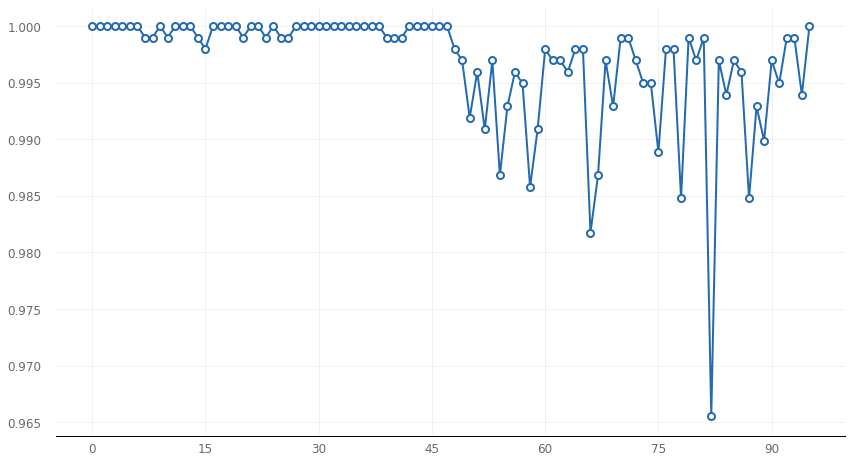

In [0]:
analysis_dyn.plot_line('val_accuracy')

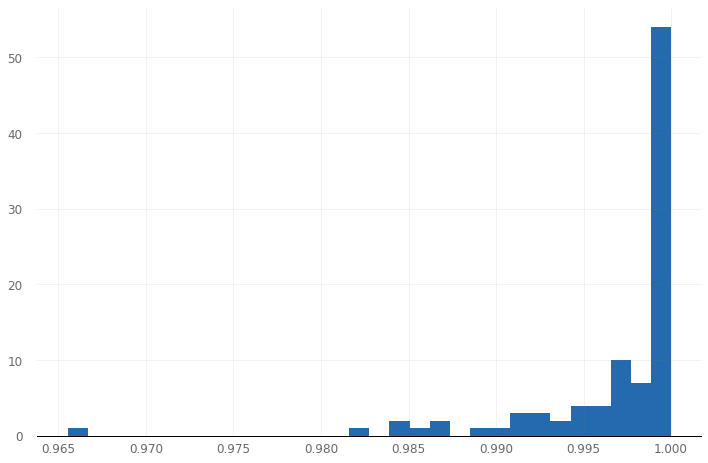

In [0]:
analysis_dyn.plot_hist('val_accuracy',bins=30)

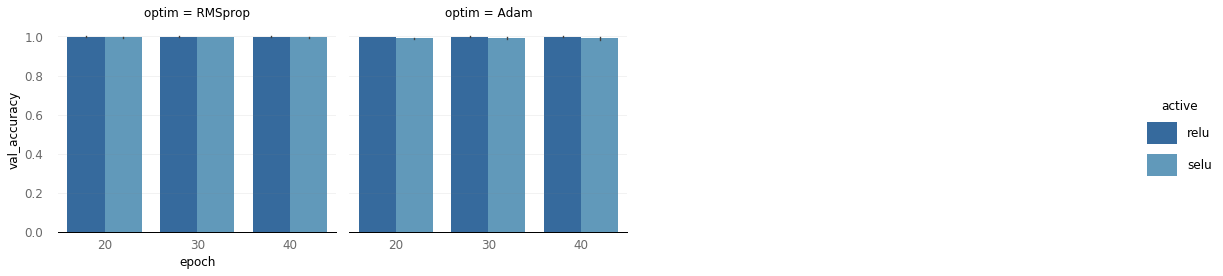

In [0]:
# a four dimensional bar grid
analysis_dyn.plot_bars('epoch', 'val_accuracy', 'active', 'optim')

In [0]:
# Running the above model using best param as shown in td.data

In [0]:
np.random.seed(0)
tf.set_random_seed(0)
sess = tf.Session(graph=tf.get_default_graph())
K.set_session(sess)
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=7, activation='relu',kernel_initializer='he_uniform',input_shape=(128,9)))
model.add(Conv1D(filters=32, kernel_size=7, activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.7))
model.add(MaxPooling1D(pool_size=3))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.fit(X_train_dyn,Y_train_dyn, epochs=20, batch_size=32,validation_data=(X_test_dyn, Y_test_dyn), verbose=1)

Train on 3285 samples, validate on 1387 samples
Epoch 1/20
3285/3285 [==============================] - 3s 862us/step - loss: 0.6880 - accuracy: 0.7163 - val_loss: 0.3144 - val_accuracy: 0.9221
Epoch 2/20
3285/3285 [==============================] - 2s 548us/step - loss: 0.0829 - accuracy: 0.9723 - val_loss: 0.1566 - val_accuracy: 0.9640
Epoch 3/20
3285/3285 [==============================] - 2s 540us/step - loss: 0.0324 - accuracy: 0.9896 - val_loss: 0.1378 - val_accuracy: 0.9748
Epoch 4/20
3285/3285 [==============================] - 2s 532us/step - loss: 0.0170 - accuracy: 0.9942 - val_loss: 0.1562 - val_accuracy: 0.9704
Epoch 5/20
3285/3285 [==============================] - 2s 511us/step - loss: 0.0121 - accuracy: 0.9954 - val_loss: 0.1747 - val_accuracy: 0.9697
Epoch 6/20
3285/3285 [==============================] - 2s 526us/step - loss: 0.0104 - accuracy: 0.9970 - val_loss: 0.2708 - val_accuracy: 0.9279
Epoch 7/20
3285/3285 [==============================] - 2s 542us/step - loss

In [0]:
model.save('dyn_model.h5')

In [0]:
print((model.evaluate(X_test_dyn,Y_test_dyn,verbose=0)))
print(['val_loss','val_acc'])

[0.18647087772561047, 0.9805335402488708]
['val_loss', 'val_acc']


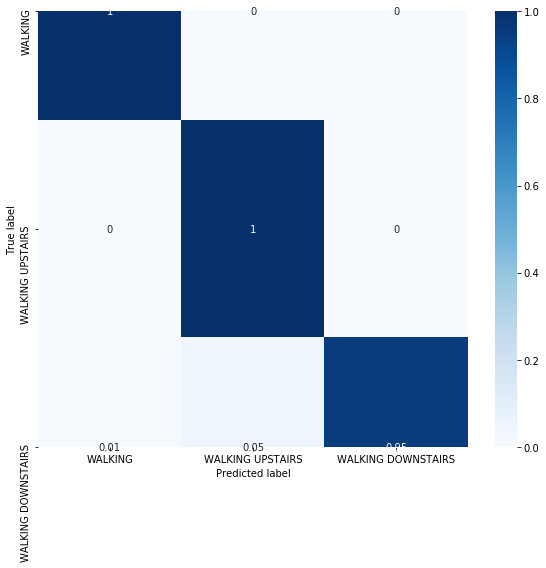

In [0]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sns


ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING UPSTAIRS',
    2: 'WALKING DOWNSTAIRS',
}
classes = list(ACTIVITIES.values())
Y_pred_d = model.predict(X_test_dyn)
y_test_d = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test_dyn, axis=1)])
Y_pred_d = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred_d, axis=1)])
#confusion matrix https://androidkt.com/keras-confusion-matrix-in-tensorboard/
con_mat = confusion_matrix(y_test_d,Y_pred_d)
con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
con_mat_df = pd.DataFrame(con_mat_norm,index = classes, columns = classes)
figure = plt.figure(figsize=(8, 8))
sns.heatmap(con_mat_df, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

## COMBINED FINAL PREDICTION PIPELINE  FOR DEPLOYMENT:

In [0]:
# reference https://github.com/UdiBhaskar/Human-Activity-Recognition--Using-Deep-NN/blob/master/Human%20Activity%20Detection-Without%20Verbose%20.ipynb
from keras.models import load_model
import pickle
model_2class = load_model('model_c1.h5')
model_dynamic = load_model('dyn_model.h5')
model_static = load_model('static_model_static.h5')


In [0]:
import talos
import wrangle

scalers = {}
for i in range(X_train_c1.shape[1]):
    scalers[i] = StandardScaler()
    X_train_final[:, i, :] = scalers[i].fit_transform(X_train[:, i, :]) 

for i in range(X_test_c1.shape[1]):
    X_test_final[:, i, :] = scalers[i].transform(X_test[:, i, :]) 

In [0]:
#scaling the data
def transform_data(X,scale):
    X_temp = X.reshape((X.shape[0] * X.shape[1], X.shape[2]))
    X_temp = scale.transform(X_temp)
    return X_temp.reshape(X.shape)

In [0]:
def predict_activity(X):
    ##predicting whether dynamic or static
    predict_2class = model_2class.predict((X,scalers1))
    Y_pred_2class =  np.argmax(predict_2class, axis=1)
    #static data filter
    X_static = X[Y_pred_2class==1]
    #dynamic data filter
    X_dynamic = X[Y_pred_2class==0]
    #predicting static activities
    predict_static = model_static.predict(transform_data(X_c2,scalers2))
    predict_static = np.argmax(predict_static,axis=1)
    #adding 4 because need to get inal prediction lable as output
    predict_static = predict_static + 4
    #predicting dynamic activites
    predict_dynamic = model_dynamic.predict(transform_data(X_dyn,scalers3))
    predict_dynamic = np.argmax(predict_dynamic,axis=1)
    #adding 1 because need to get inal prediction lable as output
    predict_dynamic = predict_dynamic + 1
    ##appending final output to one list in the same sequence of input data
    i,j = 0,0 
    final_pred = []
    for mask in Y_pred_2class:
        if mask == 1:
            final_pred.append(predict_static[i])
            i = i + 1
        else:
            final_pred.append(predict_dynamic[j])
            j = j + 1 
    return final_pred


In [0]:
# predictions of train and test data 
final_pred_train = predict_activity(X_train)
final_pred_test = predict_activity(X_test)

In [1]:
from sklearn.metrics import accuracy_score
print('Accuracy of train data',accuracy_score(Y_train,final_pred_train))
print('Accuracy of test data',accuracy_score(Y_test,final_pred_test))

Accuracy of train data 0.973249458541893
Accuracy of test data 0.9623424838819138


In [0]:
cfm = metrics.confusion_matrix(Y_test, final_pred_test,labels=range(1,7))
cfm

array([[478,  10,   0,   0,   0,   0],
       [  3, 469,   3,   0,   2,   0],
       [  1,   2, 413,   0,   0,   0],
       [  1,   2,   0, 447,  31,   0],
       [  0,   3,   0,  27, 501,   0],
       [  0,   0,   0,   3,   0, 534]])

# CONCLUSION :
* THUS USING DIVIDE AND CONQUER MODEL USING CNN WE ACHIEVED 96 % ACCURACY FOR  ACTIVITY PREDICTION
